# Projeto Churn de Clientes

## Introdu√ß√£o

O objetivo deste projeto √© analisar e construir um modelo de Machine Learning com base nos dados de rotatividade de clientes, o dataset cont√™m informa√ß√µes sobre uma empresa de telecomunica√ß√µes fict√≠cia que forneceu servi√ßos de telefone residencial e Internet para 7.043 clientes na Calif√≥rnia no terceiro trimestre. Indica quais clientes sa√≠ram, permaneceram ou se inscreveram em seu servi√ßo.

Previs√£o de rotatividade identificar clientes que provavelmente cancelar√£o seus contratos em breve. Se a empresa puder fazer isso, ela poder√° lidar com os usu√°rios antes da rotatividade A vari√°vel alvo que queremos prever √© categ√≥rica e tem apenas dois resultados poss√≠veis: rotatividade ou n√£o rotatividade (Classifica√ß√£o Bin√°ria). 

Gostar√≠amos tamb√©m de entender por que o modelo acha que nossos clientes abandonam e, para isso, precisamos ser capazes de interpretar as previs√µes do modelo. De acordo com a descri√ß√£o, este conjunto de dados cont√©m as seguintes informa√ß√µes: Servi√ßos dos clientes: telefone; v√°rias linhas; internet; suporte t√©cnico e servi√ßos extras, como seguran√ßa online, backup, prote√ß√£o de dispositivos e streaming de TV Informa√ß√µes da conta: h√° quanto tempo s√£o clientes, tipo de contrato, tipo de forma de pagamento Encargos: quanto foi cobrado ao cliente no m√™s passado e no total Informa√ß√µes demogr√°ficas: sexo, idade e se t√™m dependentes ou companheiro Churn: sim/n√£o, se o cliente deixou a empresa no m√™s passado

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, make_scorer, recall_score, precision_recall_curve, auc
from imblearn.combine import SMOTETomek
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lightgbm as lgb
import shap
import warnings

# Suprimir avisos para uma sa√≠da mais limpa, se necess√°rio (ex: de vers√µes antigas do XGBoost)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset-churn.csv')

## An√°lise Explorat√≥ria dos Dados (EDA)

In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
df.sample(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
1070  6166-ILMNY  Female              0      No         No       2   
59    5954-BDFSG  Female              0      No         No      72   
5971  9800-OUIGR    Male              0     Yes        Yes      66   
139   0390-DCFDQ  Female              1     Yes         No       1   
1839  9350-ZXYJC  Female              0      No         No       4   

     PhoneService MultipleLines InternetService       OnlineSecurity  ...  \
1070          Yes            No     Fiber optic                   No  ...   
59            Yes           Yes     Fiber optic                   No  ...   
5971          Yes            No              No  No internet service  ...   
139           Yes            No     Fiber optic                   No  ...   
1839          Yes           Yes              No  No internet service  ...   

         DeviceProtection          TechSupport          StreamingTV  \
1070                   No                   No                   No   
59                    Yes                  Yes                  Yes   
5971  No internet service  No internet service  No internet service   
139                    No                   No                   No   
1839  No internet service  No internet service  No internet service   

          StreamingMovies        Contract PaperlessBilling  \
1070                   No  Month-to-month               No   
59                    Yes        Two year              Yes   
5971  No internet service        Two year               No   
139                    No  Month-to-month              Yes   
1839  No internet service        Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges Churn  
1070  Bank transfer (automatic)          69.75        144.55   Yes  
59      Credit card (automatic)         107.50        7853.7    No  
5971    Credit card (automatic)          20.00        1374.2    No  
139                Mailed check          70.45         70.45   Yes  
1839    Credit card (automatic)          25.30        116.95    No  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


A vair√°vel TotalCharges esta como object e precisamos altera-la para num√©rica

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [8]:
# Verificando Valores Nulos
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


A variavel TotalCharges possui 11 valores nulos, vamos analisa-la para definir qual a melhor estrat√©gia para lidar com esses dados

In [9]:
df[df['TotalCharges'].isna()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   
3331          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
4380          Yes                No              No  No internet service  ...   
5218          Yes                No              No  No internet service  ...   
6670          Yes               Yes             DSL                   No  ...   
6754          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   
3331  No internet service  Two year               No   
3826  No internet service  Two year               No   
4380  No internet service  Two year               No   
5218  No internet service  One year              Yes   
6670                   No  Two year               No   
6754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
488   Bank transfer (automatic)          52.55           NaN     No  
753                Mailed check          20.25           NaN     No  
936                Mailed check          80.85           NaN     No  
1082               Mailed check          25.75           NaN     No  
1340    Credit card (automatic)          56.05           NaN     No  
3331               Mailed check          19.85           NaN     No  
3826               Mailed check          25.35           NaN     No  
4380               Mailed check          20.00           NaN     No  
5218               Mailed check     

Observa-se que onde possuimos valores ausentes temos tenure = 0 , ou seja correspondem a clientes rec√©m-chegados que ainda n√£o acumularam TotalCharges portanto vamos imputa-lo como 0

In [10]:
# Substituindo os valores ausentes por 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [11]:
# Verificando valores ausentes novamente
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

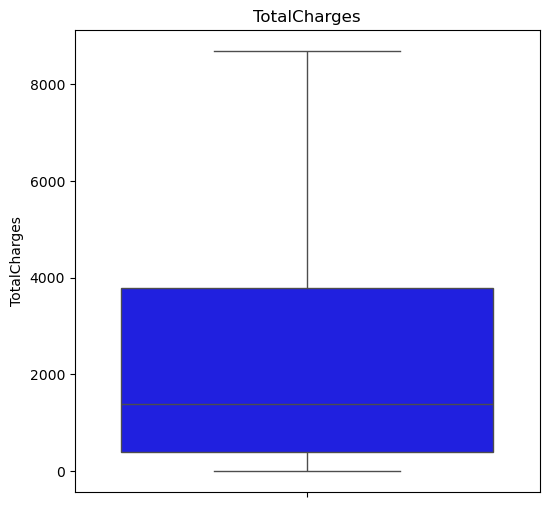

In [12]:
plt.figure(figsize = (6, 6))
plt.title("TotalCharges")
sns.boxplot(data = df['TotalCharges'], color = 'blue')
plt.show()

### An√°lise Univariada

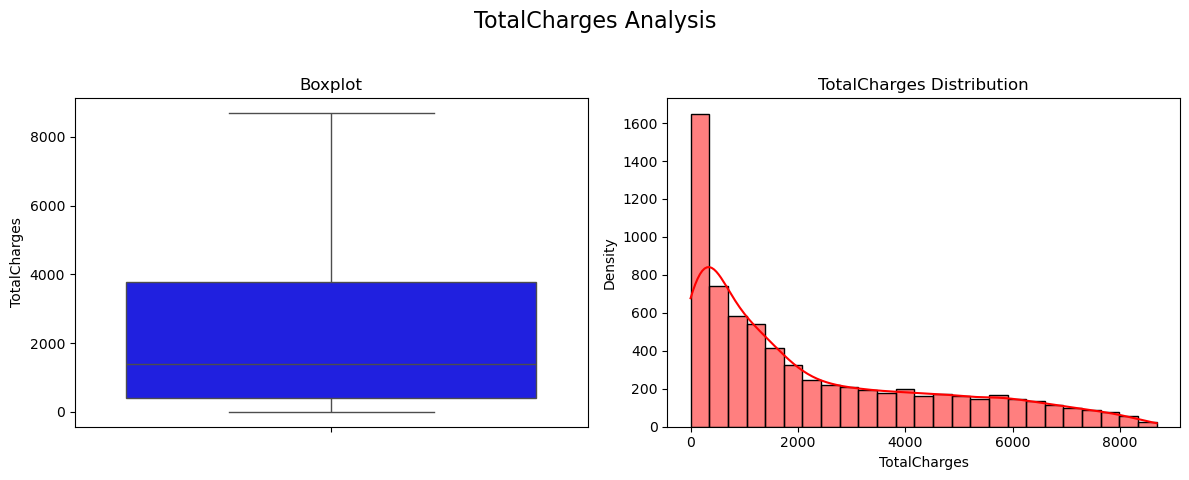

In [13]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('TotalCharges Analysis', fontsize=16)
# Desenha o primeiro gr√°fico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['TotalCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gr√°fico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['TotalCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('TotalCharges Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposi√ß√£o e exibir o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

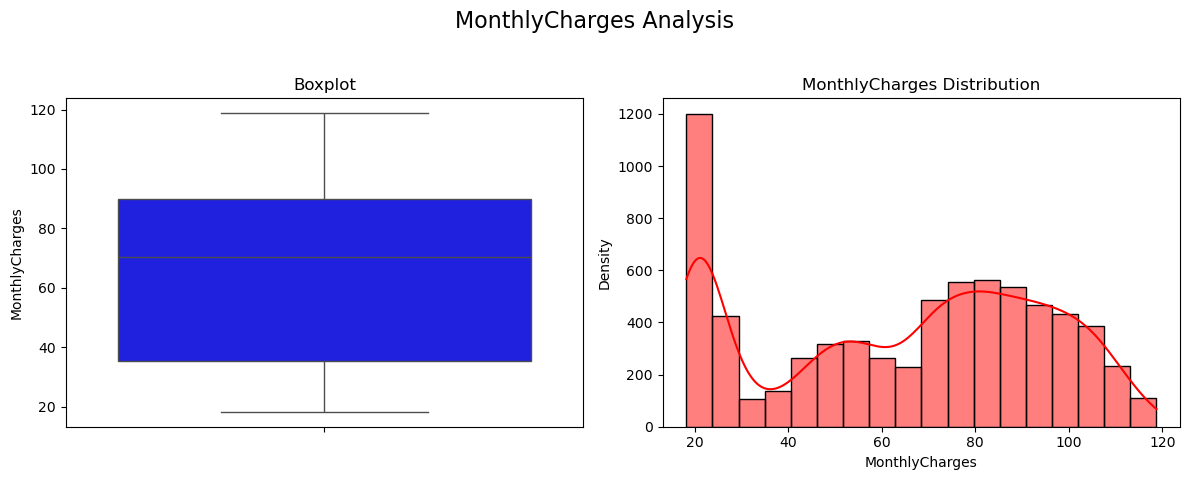

In [14]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('MonthlyCharges Analysis', fontsize=16)
# Desenha o primeiro gr√°fico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['MonthlyCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gr√°fico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['MonthlyCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('MonthlyCharges Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposi√ß√£o e exibir o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

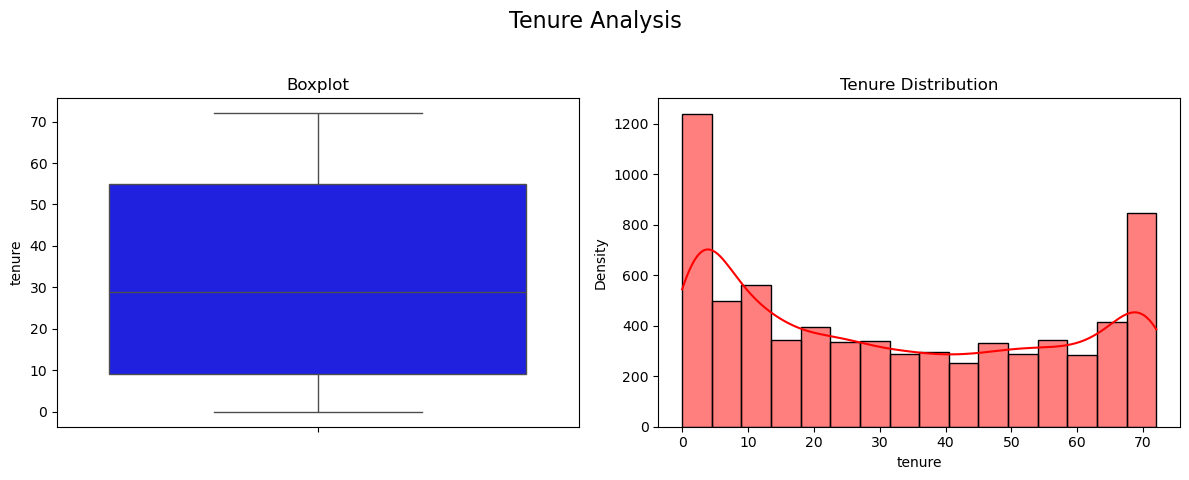

In [15]:
# Cria a figura e os eixos (subplots) para 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Tenure Analysis', fontsize=16)
# Desenha o primeiro gr√°fico (Boxplot) no primeiro eixo (axes[0])
sns.boxplot(data=df['tenure'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')
# Desenha o segundo gr√°fico (Histograma) no segundo eixo (axes[1])
sns.histplot(df['tenure'], color='red', kde=True, ax=axes[1])
axes[1].set_title('Tenure Distribution')
axes[1].set_ylabel('Density')
# Ajusta o layout para evitar sobreposi√ß√£o e exibir o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Vamos substituir os valores "No internet service" e "No phone service" por "No". Isso pois tem o mesmo siginficado (o cliente n√£o tem esse servi√ßo), e deixando em diferentes categorias iria criar mais informa√ß√µes sem adicionar relev√¢ncia para o modelo.

In [16]:
# Lista de valores a serem substitu√≠dos
valores_substituir = ["No internet service", "No phone service"]

# Substituir por "No" em todas as colunas do DataFrame
df = df.replace(valores_substituir, "No")


Global Mean Churn Rate: 0.27


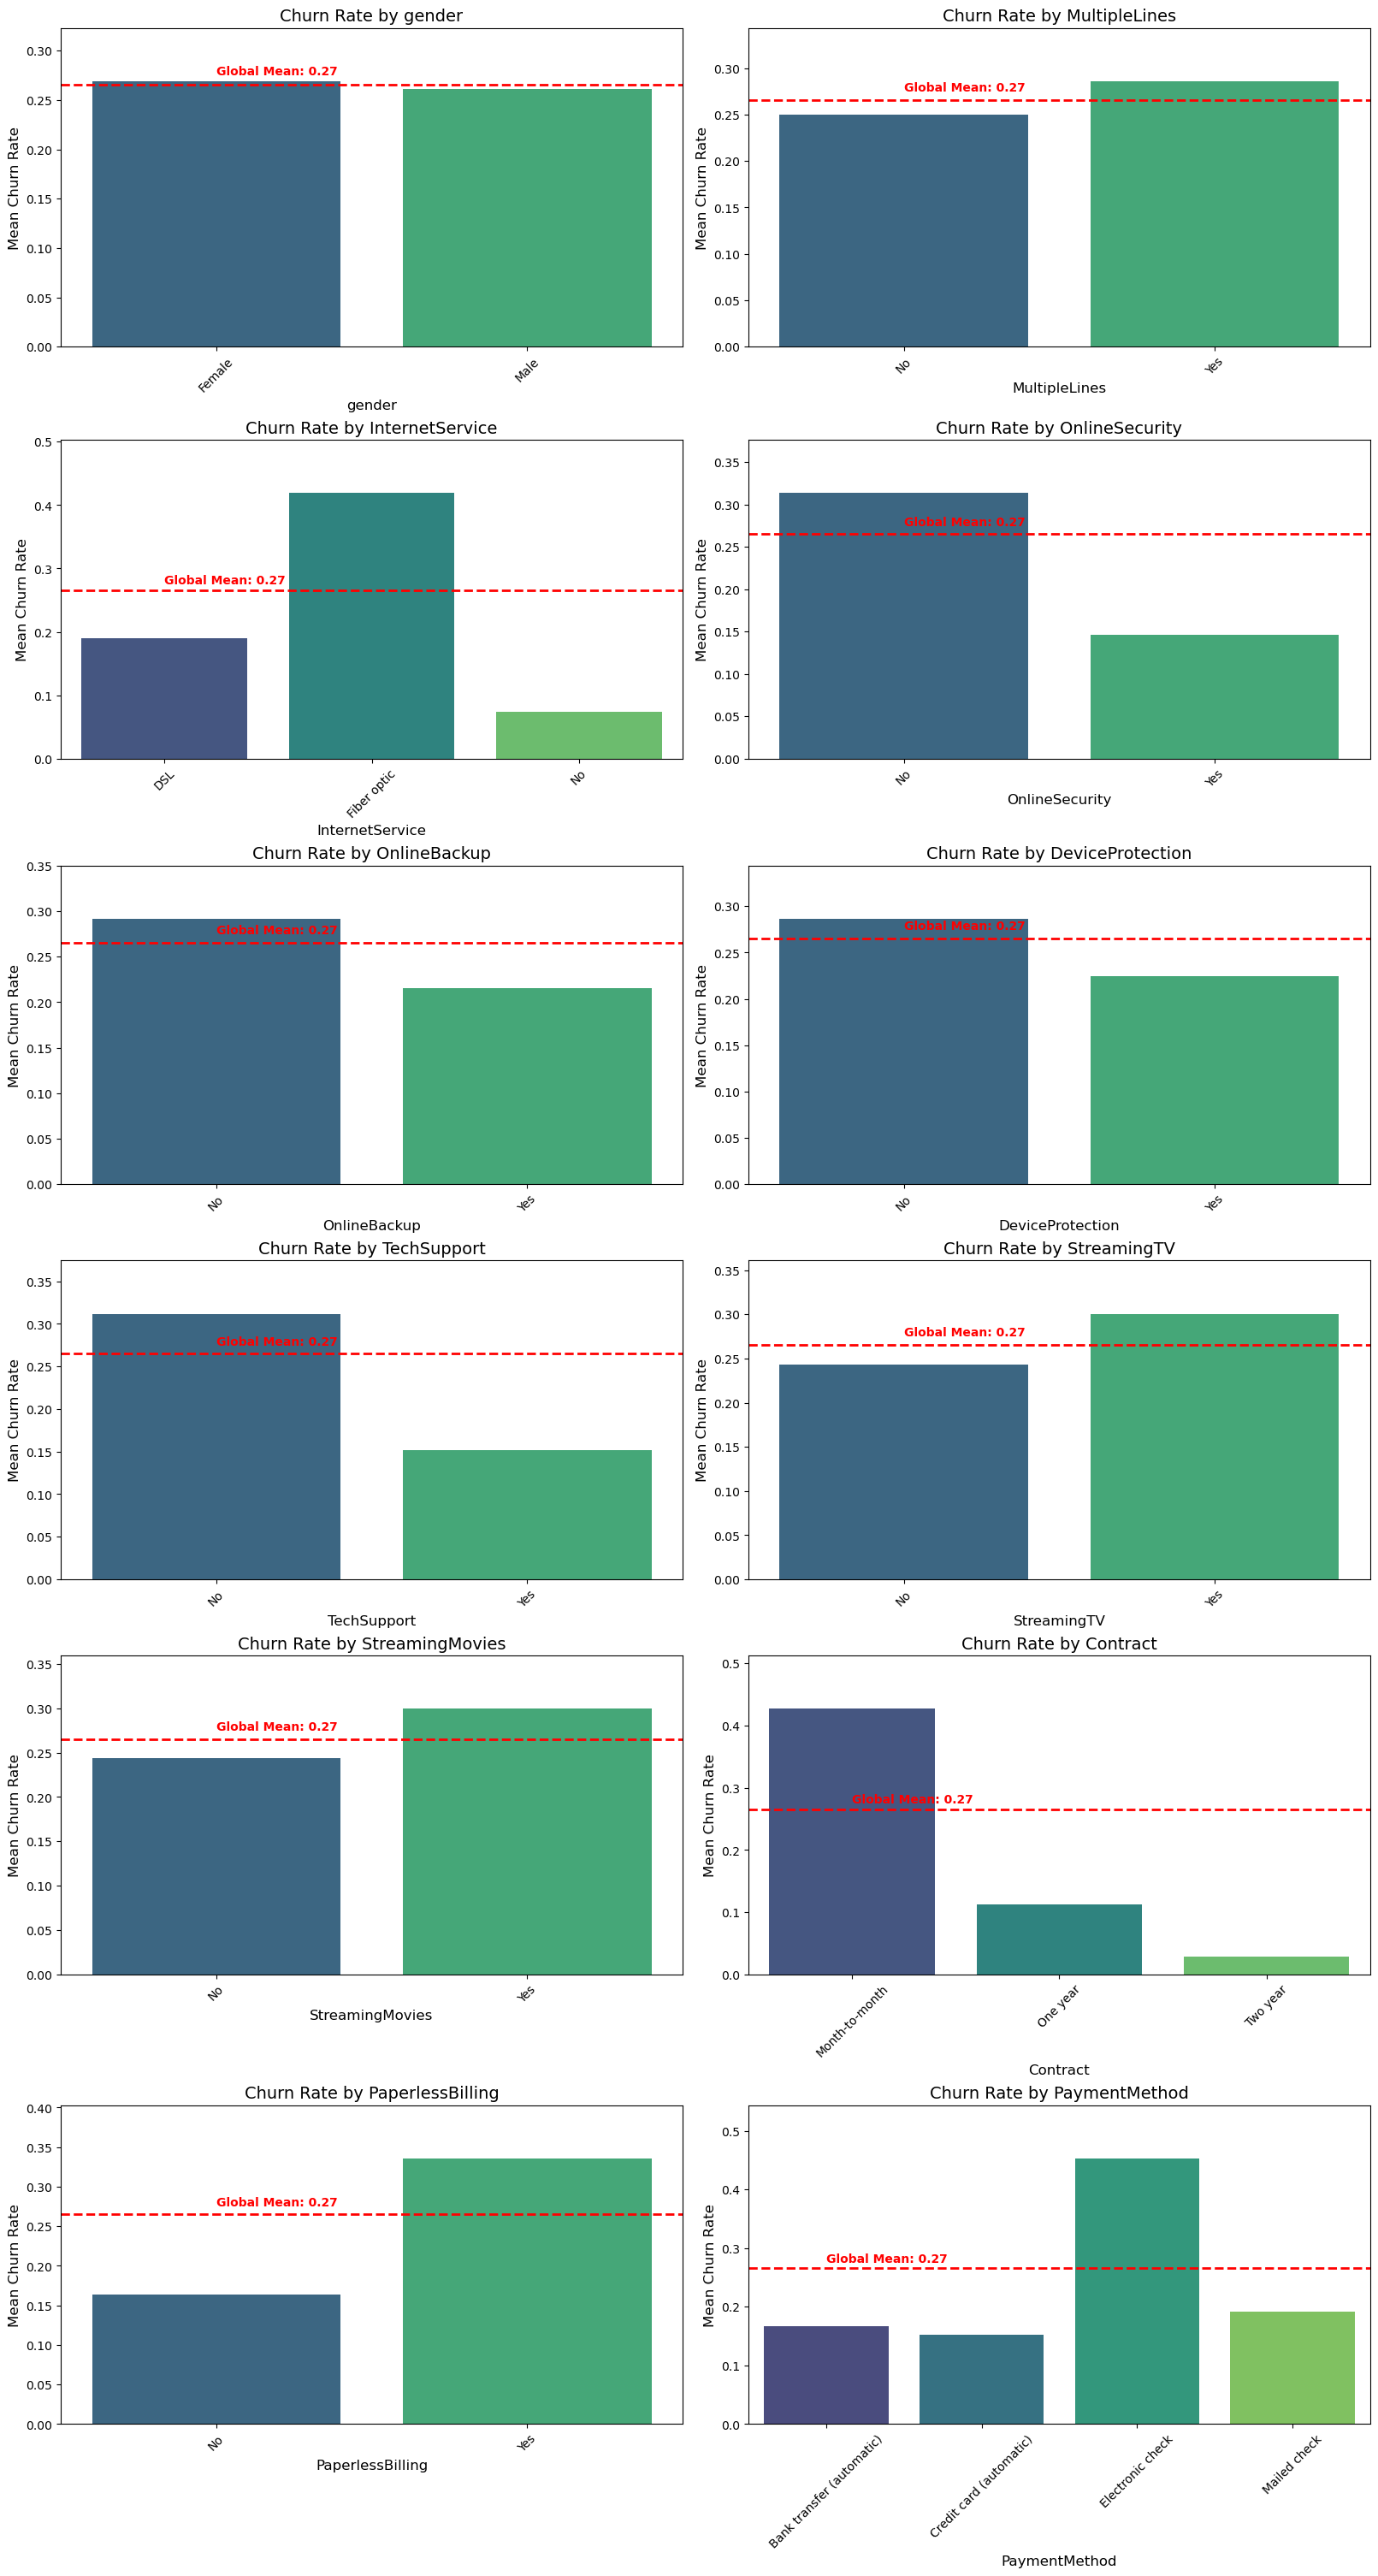

In [17]:
# 1. Cria uma c√≥pia do DataFrame para n√£o alterar o original
df_copy = df.copy()

# Converte a coluna 'Churn' para formato num√©rico (0 e 1)
df_copy['Churn'] = df_copy['Churn'].map({'No': 0, 'Yes': 1})

# 2. Define a lista de colunas categ√≥ricas para analisar
categorical_features = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# 3. Calcula a m√©dia global de Churn
global_mean = df_copy['Churn'].mean()
print(f"Global Mean Churn Rate: {global_mean:.2f}")

# 4. Subplots: dois por linha
n_features = len(categorical_features)
ncols = 2
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 5), constrained_layout=True)
axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

for i, feature in enumerate(categorical_features):
    # Agrupa por categoria e calcula a m√©dia de Churn para cada uma
    df_group = df_copy.groupby(by=feature)['Churn'].agg(['mean']).reset_index()

    # Seleciona o eixo do subplot correspondente
    ax = axes[i]

    # Cria o gr√°fico de barras
    graph = sns.barplot(x=feature, y='mean', data=df_group, palette='viridis', ax=ax)

    # Adiciona a linha da m√©dia global
    ax.axhline(global_mean, linewidth=2, color='red', linestyle='--')

    # Adiciona texto para identificar a linha da m√©dia global
    ax.text(0, global_mean + 0.01, f"Global Mean: {global_mean:.2f}", color='red', weight='semibold')

    # Adiciona t√≠tulos e r√≥tulos (em ingl√™s, como solicitado anteriormente)
    ax.set_title(f"Churn Rate by {feature}", fontsize=14)
    ax.set_ylabel("Mean Churn Rate", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylim(0, max(df_group['mean'].max() * 1.2, global_mean * 1.2))  # Ajusta o limite do eixo Y
    ax.tick_params(axis='x', labelrotation=45)

# Esconde subplots n√£o utilizados (se houver)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


### An√°lise Bivariada

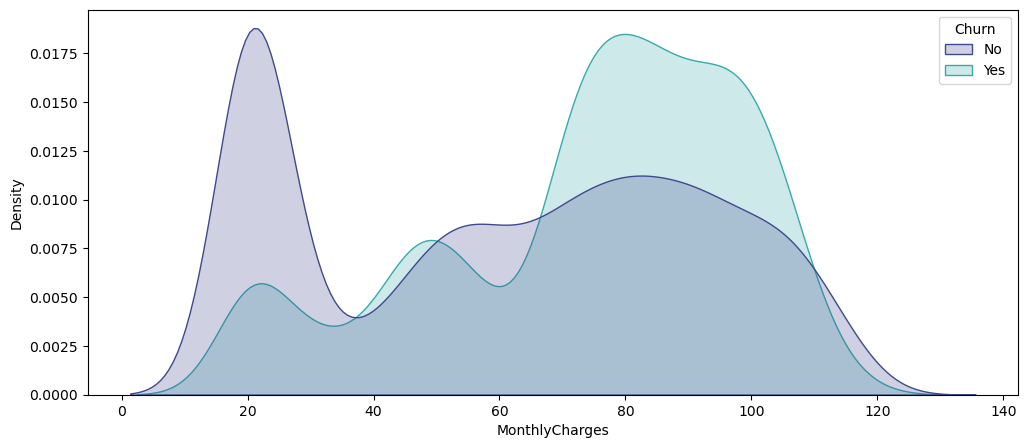

In [18]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

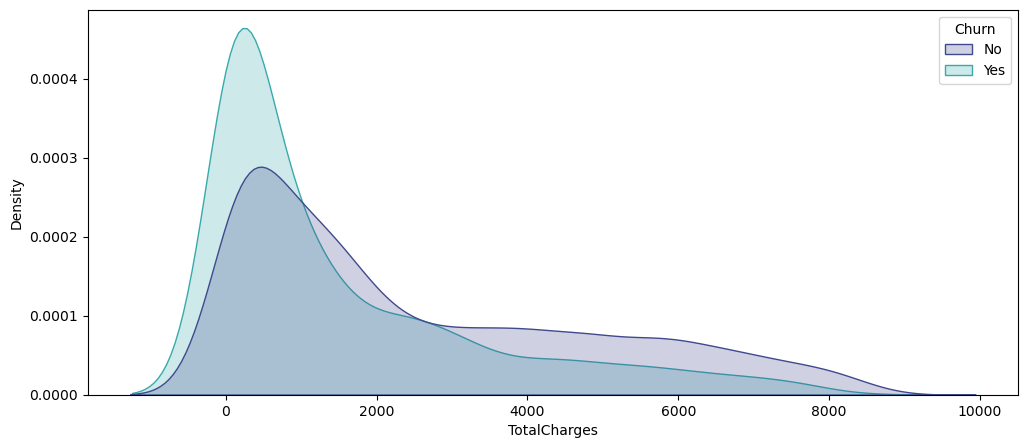

In [19]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

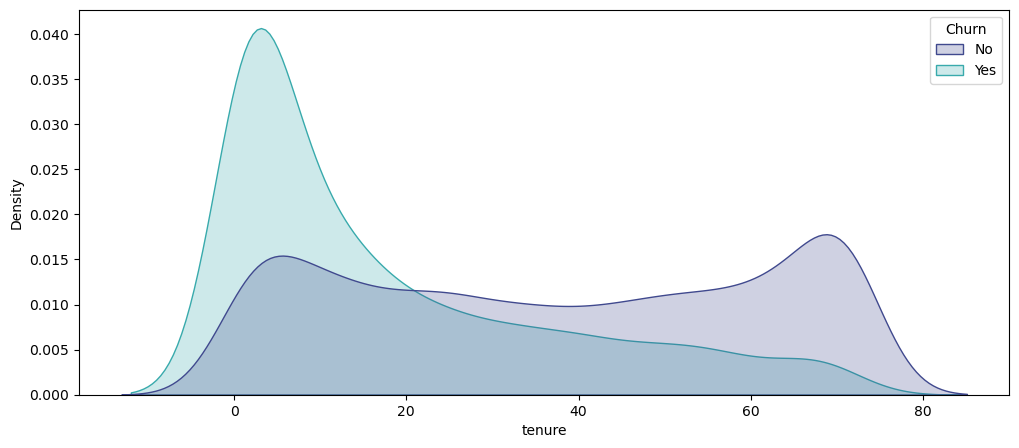

In [20]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

## Insights

A taxa m√©dia de churn encontrada no conjunto √© de aproximadamente **27%**, ou seja, cerca de um em cada quatro clientes encerra o contrato. Esse valor n√£o √© desprez√≠vel e deve ser tratado como um indicador cr√≠tico de reten√ß√£o. Ao observar a vari√°vel `tenure`, nota-se uma mediana de 29 meses, mas com 25% dos clientes permanecendo nove meses ou menos, revelando uma forte concentra√ß√£o de clientes de curta dura√ß√£o e sugerindo churn precoce como risco principal.  

Em rela√ß√£o √†s cobran√ßas, a vari√°vel `MonthlyCharges` apresenta m√©dia em torno de 64,8, mas com ampla dispers√£o, indicando perfis de consumo bastante distintos. J√° `TotalCharges`, ap√≥s a convers√£o para num√©rico e a imputa√ß√£o de nulos, mostra distribui√ß√£o assim√©trica e presen√ßa de outliers, o que reflete tanto a varia√ß√£o de tempo de contrato quanto o ac√∫mulo de gastos ao longo do tempo. Por fim, a an√°lise das vari√°veis categ√≥ricas, representadas por gr√°ficos de barras com linha de refer√™ncia da m√©dia global de churn, permite visualizar claramente quais segmentos se encontram acima ou abaixo da taxa m√©dia, tornando mais intuitiva a identifica√ß√£o de grupos priorit√°rios para reten√ß√£o.

Al√©m disso, ao observar as vari√°veis categ√≥ricas, destaca-se que clientes em **contratos m√™s a m√™s**, aqueles que utilizam **pagamento eletr√¥nico (`PaperlessBilling`)** e determinados **m√©todos de pagamento** apresentam taxas de churn superiores √† m√©dia global. Esses perfis, portanto, constituem alvos estrat√©gicos para interven√ß√µes direcionadas. Vale ressaltar tamb√©m que o tratamento aplicado em `TotalCharges` foi essencial para evitar distor√ß√µes e garantir consist√™ncia nas compara√ß√µes realizadas.  

A rela√ß√£o entre churn e `tenure` revela que clientes que cancelam tendem a estar concentrados nos primeiros meses de contrato, refor√ßando a necessidade de estrat√©gias espec√≠ficas de onboarding e fideliza√ß√£o j√° nos primeiros ciclos. A compara√ß√£o entre churn e `MonthlyCharges` indica que existem faixas de cobran√ßa em que a propens√£o ao cancelamento √© maior, principalmente entre clientes com valores de fatura mais elevados, o que sugere a necessidade de avaliar a percep√ß√£o de custo-benef√≠cio nesse segmento. 



## Pr√© Processamento Dos Dados

In [21]:
df.sample(5)

customerID gender  SeniorCitizen Partner Dependents  tenure  \
5132  3850-OKINF   Male              0     Yes        Yes      71   
5590  0487-VVUVK   Male              0     Yes        Yes      25   
3450  0100-DUVFC   Male              1     Yes         No      70   
6838  2025-JKFWI   Male              0      No         No      13   
3109  4521-WFJAI   Male              0      No         No      56   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
5132          Yes           Yes             DSL            Yes  ...   
5590          Yes            No              No             No  ...   
3450          Yes           Yes     Fiber optic             No  ...   
6838          Yes           Yes     Fiber optic             No  ...   
3109          Yes           Yes              No             No  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
5132               No          No         Yes              No        One year   
5590               No          No          No              No  Month-to-month   
3450              Yes          No         Yes             Yes        One year   
6838               No         Yes         Yes             Yes  Month-to-month   
3109               No          No          No              No        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
5132              Yes           Electronic check          66.20       4692.55   
5590              Yes               Mailed check          19.15        477.60   
3450              Yes           Electronic check         104.80       7308.95   
6838              Yes               Mailed check          99.00       1301.70   
3109              Yes  Bank transfer (automatic)          25.95       1444.05   

      Churn  
5132     No  
5590     No  
3450     No  
6838    Yes  
3109     No  

[5 rows x 21 columns]

In [22]:
# Removendo a coluna custumerID pois n√£o tem valor preditivo
df = df.drop('customerID', axis=1) 

In [23]:
df.sample(5)

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
1332    Male              0      No         No      69          Yes   
2084    Male              0      No        Yes       1          Yes   
6694    Male              0     Yes        Yes       8          Yes   
6247    Male              0      No         No      60          Yes   
5647  Female              0     Yes         No      46          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
1332           Yes              No             No           No   
2084            No     Fiber optic             No           No   
6694           Yes             DSL            Yes          Yes   
6247           Yes     Fiber optic             No           No   
5647            No             DSL             No          Yes   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
1332               No          No          No              No        Two year   
2084               No          No          No              No  Month-to-month   
6694               No         Yes          No             Yes        Two year   
6247              Yes          No         Yes              No        Two year   
5647               No          No         Yes             Yes  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
1332               No  Bank transfer (automatic)           23.95   
2084               No  Bank transfer (automatic)           69.75   
6694              Yes    Credit card (automatic)           76.15   
6247              Yes           Electronic check           89.55   
5647              Yes    Credit card (automatic)           69.10   

      TotalCharges Churn  
1332       1713.10    No  
2084         69.75   Yes  
6694        645.80    No  
6247       5231.20    No  
5647       3168.00    No

In [24]:
df.describe(include=['object', 'bool'])

gender Partner Dependents PhoneService MultipleLines InternetService  \
count    7043    7043       7043         7043          7043            7043   
unique      2       2          2            2             2               3   
top      Male      No         No          Yes            No     Fiber optic   
freq     3555    3641       4933         6361          4072            3096   

       OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
count            7043         7043             7043        7043        7043   
unique              2            2                2           2           2   
top                No           No               No          No          No   
freq             5024         4614             4621        4999        4336   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
count             7043            7043             7043              7043   
unique               2               3                2                 4   
top                 No  Month-to-month              Yes  Electronic check   
freq              4311            3875             4171              2365   

       Churn  
count   7043  
unique     2  
top       No  
freq    5174

In [25]:
# ------------------------
# 1. Label Encoding nas vari√°veis bin√°rias
# ------------------------
binarias = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'
]

# Mapear Yes/No para 1/0 e Male/Female para 1/0
mapeamento = {
    'Yes': 1,
    'No': 0,
    'Male': 1,
    'Female': 0
}

for col in binarias:
    df[col] = df[col].map(mapeamento)

In [26]:
# ------------------------
# 2. One-Hot Encoding nas vari√°veis nominais
# ------------------------
nominais = ['InternetService', 'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=nominais, drop_first=True, dtype=int)

In [27]:
df.sample(5)

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
3299       1              0        0           0      68             1   
3438       1              0        1           0      18             1   
6778       0              0        0           1      72             1   
6370       0              0        0           0      45             1   
5106       0              0        0           0      52             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
3299              1               1             1                 1  ...   
3438              1               0             0                 0  ...   
6778              0               0             0                 0  ...   
6370              1               0             1                 0  ...   
5106              0               0             0                 1  ...   

      MonthlyCharges  TotalCharges  Churn  InternetService_Fiber optic  \
3299          117.20       8035.95      0                            1   
3438           94.70       1687.95      1                            1   
6778           19.75       1567.00      0                            0   
6370           89.30       4016.85      1                            1   
5106           59.45       3043.70      0                            0   

      InternetService_No  Contract_One year  Contract_Two year  \
3299                   0                  1                  0   
3438                   0                  0                  0   
6778                   1                  0                  1   
6370                   0                  0                  0   
5106                   0                  0                  0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
3299                                      1                               0   
3438                                      0                               1   
6778                                      0                               0   
6370                                      1                               0   
5106                                      0                               1   

      PaymentMethod_Mailed check  
3299                           0  
3438                           0  
6778                           1  
6370                           0  
5106                           0  

[5 rows x 24 columns]

<Axes: >

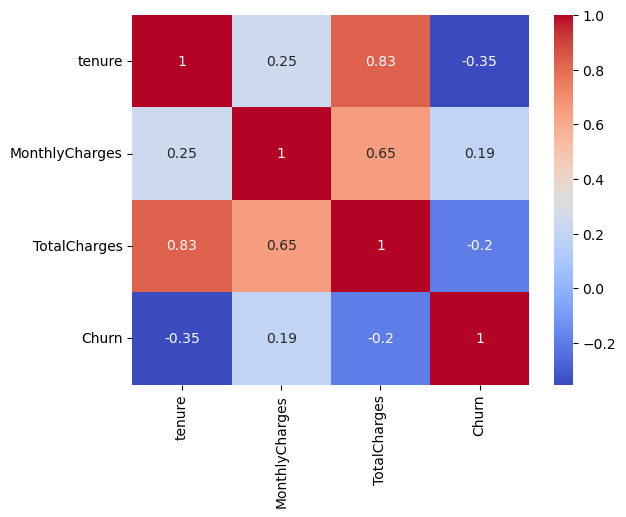

In [28]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr(), annot=True, cmap='coolwarm')

In [29]:
corr_matrix = df.corr()

# Selecionar apenas a correla√ß√£o com a coluna 'Churn'
corr_churn = corr_matrix['Churn'].sort_values(ascending=False)

# Mostrar correla√ß√µes
print(corr_churn)

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV                              0.063228
StreamingMovies                          0.061382
MultipleLines                            0.040102
PhoneService                             0.011942
gender                                  -0.008612
DeviceProtection                        -0.066160
OnlineBackup                            -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport                             -0.164674
OnlineSecurity                          -0.171226
Contract_One year                       -0.177820


In [30]:
# Matriz de correla√ß√£o
corr_matrix = df.corr()

# Definir limite para destacar correla√ß√µes fortes
limite = 0.7

# Selecionar pares de vari√°veis altamente correlacionadas
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

# Filtrar correla√ß√µes acima do limite
corr_high = corr_pairs[abs(corr_pairs['Correlation']) > limite].sort_values(
    by='Correlation', ascending=False
)

print("Vari√°veis com altamente correlacionadas (|correla√ß√£o| > 0.7):")
print(corr_high)

# Criar matriz filtrada: manter apenas correla√ß√µes acima do limite (em m√≥dulo)
corr_filtrada = corr_matrix.mask(abs(corr_matrix) <= limite)

Vari√°veis com altamente correlacionadas (|correla√ß√£o| > 0.7):
               Var1                         Var2  Correlation
96           tenure                 TotalCharges     0.826178
233  MonthlyCharges  InternetService_Fiber optic     0.787066
234  MonthlyCharges           InternetService_No    -0.763557


A correla√ß√£o de 0.826 entre tenure e TotalCharges √© extremamente alta, indicando uma forte multicolinearidade. TotalCharges √© fundamentalmente o produto de tenure e MonthlyCharges (ou, mais precisamente, a soma dos MonthlyCharges ao longo do tenure). Manter as tr√™s vari√°veis juntas adiciona redund√¢ncia e pode complicar a interpretabilidade, especialmente para modelos lineares, sem necessariamente adicionar mais poder preditivo.

Optamos por remover TotalCharges, e ainda sim retemos informa√ß√µes cruciais de tenure (tempo de perman√™ncia do cliente, um indicador chave de lealdade e maturidade na base) e MonthlyCharges (o custo atual do servi√ßo, que se correlaciona com a qualidade/pacote de servi√ßo e √© um forte preditor de churn). Essas duas vari√°veis juntas j√° capturam a ess√™ncia do que TotalCharges representa.

As demais correla√ß√µes fortes refletem a rela√ß√£o intr√≠nseca e de neg√≥cio entre o valor do servi√ßo (MonthlyCharges) e o tipo de servi√ßo (InternetService). Remover uma dessas vari√°veis significaria perder informa√ß√µes valiosas sobre o pacote de servi√ßos do cliente, que √© um preditor fort√≠ssimo de churn. O modelo de Machine Learning pode e deve usar essas informa√ß√µes para aprender a rela√ß√£o. A multicolinearidade aqui √© mais um reflexo de que uma vari√°vel (MonthlyCharges) √© fortemente influenciada por outra (InternetService), e ambas s√£o relevantes.

In [31]:
# Removendo a coluna custumerID pois n√£o tem valor preditivo
df = df.drop('TotalCharges', axis=1) 

Contagem de Churn:
Churn
0    5174
1    1869
Name: count, dtype: int64


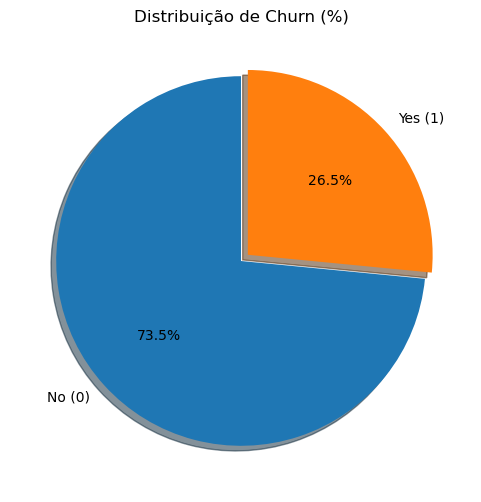

In [32]:
# Contagem de cada valor da vari√°vel alvo
churn_counts = df['Churn'].value_counts()

print("Contagem de Churn:")
print(churn_counts)

# Gr√°fico de pizza com percentuais dentro
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts, 
    labels=['No (0)', 'Yes (1)'],   
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#1f77b4', '#ff7f0e'],  # azul e laranja padr√£o
    explode=(0,0.05),
    shadow=True
)
plt.title("Distribui√ß√£o de Churn (%)")
plt.show()


Temos um problema de desbalancemaneto de classe na vari√°vel alvo, para isso testaremos diferentes estrat√©gias e abordagens e comparar qual nos dar√° o melhor modelo. NOsso objetivo √© construir um modelo com acur√°cia acima de 95%

1. Separa√ß√£o de Features (X) e Vari√°vel Target (y)
Objetivo: Isolar a vari√°vel que queremos prever (Churn) das vari√°veis preditoras (todas as outras).

Justificativa: √â a base para qualquer processo de aprendizado supervisionado. X ser√° a matriz de entrada do nosso modelo, e y ser√° a sa√≠da esperada durante o treinamento.

In [33]:
X = df.drop('Churn', axis=1) # Todas as colunas exceto 'Churn'
y = df['Churn']             # A coluna 'Churn'

2. Divis√£o dos Dados em Treino e Teste
Objetivo: Criar conjuntos de dados independentes para treinar o modelo (X_train, y_train) e para avaliar seu desempenho em dados nunca antes vistos (X_test, y_test).

Justificativa: Previne o overfitting (quando o modelo "decore" os dados de treino e n√£o generalize bem para novos dados) e fornece uma estimativa mais realista do desempenho do modelo em produ√ß√£o.

Par√¢metros Importantes:

test_size: Propor√ß√£o do dataset a ser usada para o conjunto de teste (ex: 0.2 para 20%).
random_state: Garante que a divis√£o seja a mesma em execu√ß√µes consecutivas, tornando seus resultados reprodut√≠veis.
stratify=y: Crucial para lidar com o desbalanceamento! Garante que a propor√ß√£o das classes de Churn seja mantida tanto no conjunto de treino quanto no de teste. Sem isso, voc√™ poderia ter um conjunto de teste com pouqu√≠ssimas inst√¢ncias de churn, o que dificultaria a avalia√ß√£o precisa do modelo na classe minorit√°ria.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimens√µes de X_train: {X_train.shape}")
print(f"Dimens√µes de X_test: {X_test.shape}")
print(f"Dimens√µes de y_train: {y_train.shape}")
print(f"Dimens√µes de y_test: {y_test.shape}")

# Verificar a propor√ß√£o de Churn nos conjuntos
print("\nPropor√ß√£o de Churn em y_train:")
print(y_train.value_counts(normalize=True))
print("\nPropor√ß√£o de Churn em y_test:")
print(y_test.value_counts(normalize=True))


Dimens√µes de X_train: (5634, 22)
Dimens√µes de X_test: (1409, 22)
Dimens√µes de y_train: (5634,)
Dimens√µes de y_test: (1409,)

Propor√ß√£o de Churn em y_train:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Propor√ß√£o de Churn em y_test:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [35]:
# Scaling Numerical Variables
numeric_cols = ['tenure', 'MonthlyCharges']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Estat√≠sticas de X_train ap√≥s escalonamento (colunas num√©ricas):
             tenure  MonthlyCharges
count  5.634000e+03    5.634000e+03
mean  -1.008935e-17   -2.402527e-16
std    1.000089e+00    1.000089e+00
min   -1.322329e+00   -1.544028e+00
25%   -9.559779e-01   -9.711977e-01
50%   -1.418632e-01    1.848336e-01
75%    9.164859e-01    8.319124e-01
max    1.608483e+00    1.785939e+00


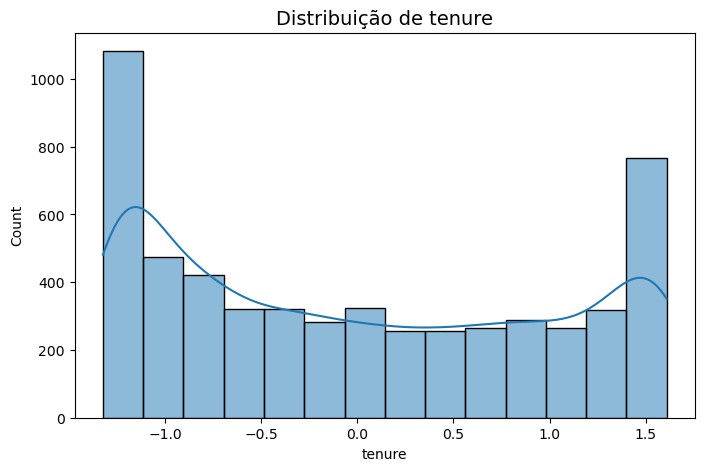

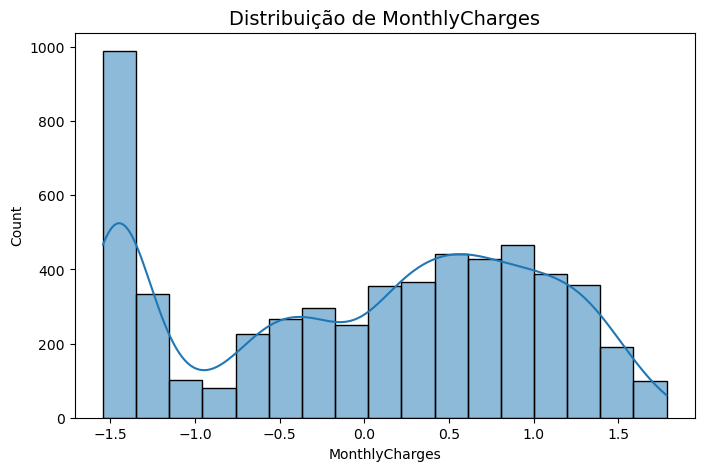

In [36]:
numeric_cols = ["tenure", 'MonthlyCharges']
for feat in numeric_cols:
    plt.figure(figsize=(8, 5)) 
    sns.histplot(data=X_train, x=feat, kde=True)
    plt.title(f'{feat} Distribution', fontsize=14)
    plt.show()

## Cria√ß√£o e Avalia√ß√£o dos Modelos de Machine Learning

### Regress√£o Log√≠stica

Modelo 1: Regress√£o Log√≠stica
A Regress√£o Log√≠stica √© um modelo de classifica√ß√£o linear que estima a probabilidade de uma inst√¢ncia pertencer a uma determinada classe.

Par√¢metro class_weight='balanced': Este par√¢metro ajusta automaticamente os pesos das classes de forma inversamente proporcional √† sua frequ√™ncia nos dados de treinamento. Isso significa que ele dar√° maior import√¢ncia aos erros de classifica√ß√£o da classe minorit√°ria (Churn), ajudando o modelo a aprender melhor sobre ela.

In [37]:
print("--- Treinando e Avaliando o Modelo de Regress√£o Log√≠stica ---")

# Inicializar o modelo de Regress√£o Log√≠stica com class_weight='balanced'
# solver='liblinear' √© um bom default para datasets pequenos e m√©dios, e lida bem com L1/L2
# max_iter aumenta o n√∫mero m√°ximo de itera√ß√µes para garantir a converg√™ncia
log_reg_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

# Treinar o modelo
log_reg_model.fit(X_train, y_train)

# Fazer previs√µes no conjunto de teste
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

--- Treinando e Avaliando o Modelo de Regress√£o Log√≠stica ---



--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica ---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409


--- Matriz de Confus√£o (Regress√£o Log√≠stica) ---


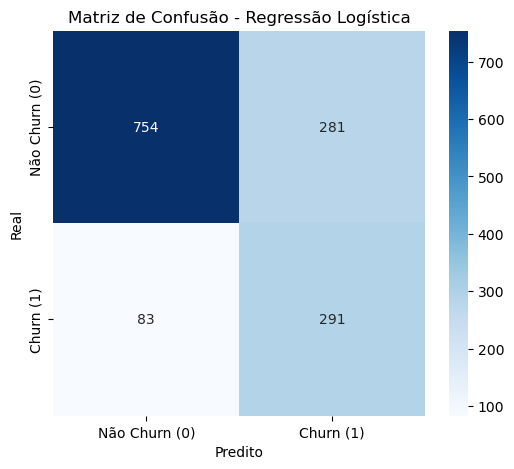

In [38]:
print("\n--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica ---")
print(classification_report(y_test, y_pred_log_reg))

print("\n--- Matriz de Confus√£o (Regress√£o Log√≠stica) ---")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Regress√£o Log√≠stica')
plt.show()

Perfeito, Gabriel, agora d√° para interpretar essa matriz de confus√£o espec√≠fica do seu modelo de **Regress√£o Log√≠stica**. Vamos destrinchar üëá

---

### üìä Matriz de Confus√£o

* **TN (N√£o churn predito corretamente):** **754**
* **FP (Predito churn, mas era n√£o churn):** **281**
* **FN (Predito n√£o churn, mas era churn):** **83**
* **TP (Churn predito corretamente):** **291**

---

### üìê M√©tricas principais

1. **Acur√°cia**

$$
\frac{TP + TN}{TP + TN + FP + FN} = \frac{754 + 291}{754 + 281 + 83 + 291} = \frac{1045}{1409} \approx 74.2\%
$$

üëâ O modelo acerta cerca de **74% das previs√µes totais**.

---

2. **Precis√£o (para classe churn = 1)**

$$
\frac{TP}{TP + FP} = \frac{291}{291 + 281} = \frac{291}{572} \approx 50.9\%
$$

üëâ Entre os que o modelo disse que **iriam cancelar**, s√≥ **metade realmente cancela**.
‚ö†Ô∏è Muitos **falsos positivos**.

---

3. **Recall (Sensibilidade para churn = 1)**

$$
\frac{TP}{TP + FN} = \frac{291}{291 + 83} = \frac{291}{374} \approx 77.8\%
$$

üëâ O modelo consegue identificar **\~78% dos clientes que realmente cancelam**.
‚úÖ Bom poder de detec√ß√£o.

---

4. **Especificidade (para n√£o churn = 0)**

$$
\frac{TN}{TN + FP} = \frac{754}{754 + 281} = \frac{754}{1035} \approx 72.9\%
$$

üëâ Ele acerta **73% dos clientes que n√£o cancelam**, mas ainda confunde muitos como churn.

---

5. **F1-Score (equil√≠brio entre precis√£o e recall do churn)**

$$
F1 = \frac{2 \cdot (0.509 \cdot 0.778)}{0.509 + 0.778} \approx 61.7\%
$$

üëâ O modelo tem um **equil√≠brio moderado** entre detectar churn e n√£o gerar tanto alarme falso.

---

### üß† Interpreta√ß√£o pr√°tica

* O modelo **identifica bem os clientes que v√£o cancelar (bom recall: 78%)**, o que √© √≥timo para estrat√©gias de reten√ß√£o.
* Por√©m, **tem muitos falsos positivos (281)** ‚Üí ou seja, ele indica que clientes fi√©is v√£o cancelar, quando na verdade n√£o. Isso pode gerar **custo extra** se a empresa investir a√ß√µes de reten√ß√£o em quem n√£o iria sair.
* A **precis√£o de apenas 51%** mostra que o modelo ‚Äúdesconfia demais‚Äù de churn.

üëâ Em termos de neg√≥cio:

* **Ponto positivo:** o modelo ajuda a n√£o deixar escapar muitos clientes que realmente cancelariam.
* **Ponto negativo:** pode sobrecarregar a equipe de reten√ß√£o, pois muitos clientes "alertados" n√£o iriam cancelar.

---



AUC-ROC (Regress√£o Log√≠stica): 0.8389


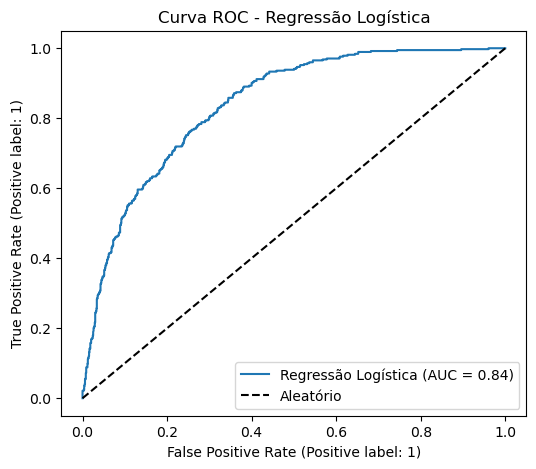

In [39]:
# Calcular e exibir AUC-ROC
auc_log_reg = roc_auc_score(y_test, y_proba_log_reg)
print(f"\nAUC-ROC (Regress√£o Log√≠stica): {auc_log_reg:.4f}")

# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax, name='Regress√£o Log√≠stica')
plt.title('Curva ROC - Regress√£o Log√≠stica')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio') # Linha de base aleat√≥ria
plt.legend()
plt.show()


## üìä O que √© a Curva ROC?

* **ROC (Receiver Operating Characteristic)** mostra a rela√ß√£o entre:

  * **Taxa de Verdadeiros Positivos (TPR ou Recall)** no eixo **Y**
  * **Taxa de Falsos Positivos (FPR)** no eixo **X**

$$
TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
$$

* A linha **diagonal (preta tracejada)** representa um **classificador aleat√≥rio** (sem poder preditivo).
* Quanto mais a curva do modelo se afasta para o canto superior esquerdo (‚Üë), melhor √© a separa√ß√£o entre classes.

---

## üìê Interpreta√ß√£o do seu gr√°fico

* O modelo tem **AUC = 0.8389 ‚âà 0.84**.
* **AUC (√Årea sob a curva)** √© a probabilidade de o modelo atribuir uma pontua√ß√£o maior a um cliente que realmente vai cancelar do que a um cliente que n√£o vai cancelar.
* Valores de refer√™ncia para AUC:

  * **0.5** ‚Üí modelo aleat√≥rio (sem utilidade).
  * **0.6 ‚Äì 0.7** ‚Üí fraco.
  * **0.7 ‚Äì 0.8** ‚Üí razo√°vel/bom.
  * **0.8 ‚Äì 0.9** ‚Üí muito bom.
  * **> 0.9** ‚Üí excelente.

üëâ Seu modelo com **AUC = 0.84** est√° em um n√≠vel **muito bom**, indicando que a Regress√£o Log√≠stica consegue separar bem clientes churn vs n√£o churn.

---

## üß† Rela√ß√£o com o neg√≥cio

* A curva mostra que o modelo tem **boa capacidade de discrimina√ß√£o**, ou seja, ele consegue diferenciar quem provavelmente vai cancelar de quem n√£o vai.
* Isso √© importante porque, na pr√°tica, voc√™ pode **ajustar o limiar de decis√£o**:

  * Se quiser **reduzir falsos negativos** (n√£o deixar escapar clientes que realmente cancelam), pode baixar o threshold ‚Üí aumenta recall, mas gera mais falsos positivos.
  * Se quiser **reduzir falsos positivos** (n√£o incomodar clientes que n√£o iriam cancelar), pode subir o threshold ‚Üí aumenta precis√£o, mas pode deixar passar churns.

---

## üìå Complementando com o que vimos na matriz de confus√£o

* A matriz mostrou que o modelo tem **bom recall (78%)**, mas **precis√£o baixa (51%)**.
* A curva ROC e o AUC confirmam que o modelo √© **robusto na separa√ß√£o das classes**.
* O desafio √© **ajustar o ponto de corte** (threshold, padr√£o 0.5) para encontrar o equil√≠brio certo entre custo de reten√ß√£o (FP) e risco de perder clientes (FN).

### Random Forest

Modelo 2: Random Forest Classifier
Random Forest √© um algoritmo de aprendizado de m√°quina ensemble que constr√≥i m√∫ltiplas √°rvores de decis√£o e combina suas previs√µes para obter um resultado mais preciso e est√°vel.

Par√¢metro class_weight='balanced': Assim como na Regress√£o Log√≠stica, este par√¢metro instrui o algoritmo a atribuir maior peso √†s amostras da classe minorit√°ria durante o treinamento de cada √°rvore, ajudando a mitigar o vi√©s do desbalanceamento.

In [40]:
print("\n\n--- Treinando e Avaliando o Modelo Random Forest ---")

# Inicializar o modelo Random Forest com class_weight='balanced'
# n_estimators: n√∫mero de √°rvores na floresta (pode ser ajustado)
# random_state: para reprodutibilidade
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previs√µes no conjunto de teste
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)



--- Treinando e Avaliando o Modelo Random Forest ---



--- Relat√≥rio de Classifica√ß√£o (Random Forest) ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409


--- Matriz de Confus√£o (Random Forest) ---


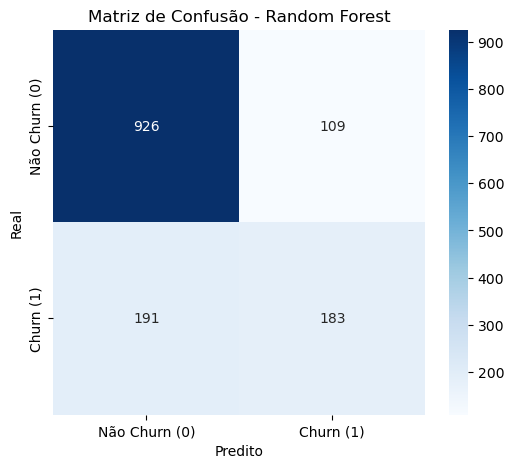

In [41]:
print("\n--- Relat√≥rio de Classifica√ß√£o (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Matriz de Confus√£o (Random Forest) ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Random Forest')
plt.show()



AUC-ROC (Random Forest): 0.8195


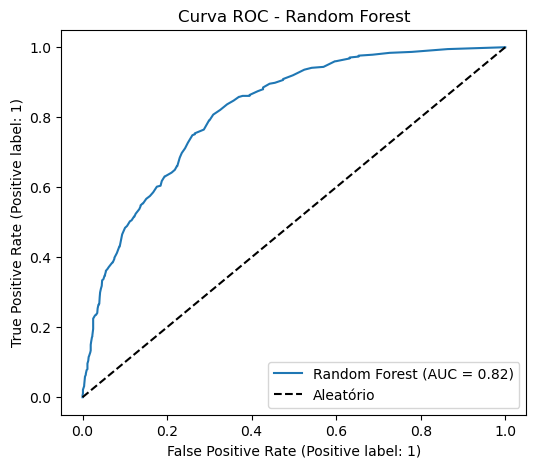

In [42]:
# Calcular e exibir AUC-ROC
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nAUC-ROC (Random Forest): {auc_rf:.4f}")

# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name='Random Forest')
plt.title('Curva ROC - Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio') # Linha de base aleat√≥ria
plt.legend()
plt.show()

### Utilizando Balanceamento de Classes

Entendendo SMOTE com Undersampling
Como discutimos, o desbalanceamento de classes pode levar a modelos que ignoram a classe minorit√°ria. O par√¢metro class_weight='balanced' nos modelos tenta mitigar isso ajustando os pesos, mas as t√©cnicas de reamostragem modificam a distribui√ß√£o dos dados de treinamento, fornecendo uma base mais "justa" para o modelo aprender.

1. SMOTE (Synthetic Minority Over-sampling Technique)
O que √©? Em vez de simplesmente duplicar amostras existentes da classe minorit√°ria (que pode levar a overfitting), o SMOTE cria novas amostras sint√©ticas.
Como funciona? Para cada amostra da classe minorit√°ria, o SMOTE encontra seus vizinhos mais pr√≥ximos (usando, por exemplo, k-NN). Em seguida, ele seleciona um ou mais desses vizinhos e cria uma nova amostra sint√©tica em algum lugar ao longo da linha que conecta a amostra original e seu vizinho. Isso gera pontos "intermedi√°rios" que s√£o semelhantes, mas n√£o id√™nticos, √†s amostras originais.
Vantagens: Aumenta a representa√ß√£o da classe minorit√°ria sem copiar as amostras existentes, o que ajuda o modelo a aprender padr√µes mais robustos para essa classe.
2. Undersampling (Subamostragem) da Classe Majorit√°ria
O que √©? Reduz o n√∫mero de amostras da classe majorit√°ria.
Como funciona? Existem v√°rias t√©cnicas, desde a remo√ß√£o aleat√≥ria (Random Under-sampling) at√© m√©todos mais sofisticados que tentam remover amostras que s√£o redundantes ou que n√£o contribuem para a separa√ß√£o das classes.
Vantagens: Ajuda a equilibrar o dataset sem introduzir muitos novos pontos sint√©ticos.
Desvantagens: Pode levar √† perda de informa√ß√µes importantes da classe majorit√°ria se as amostras forem removidas indiscriminadamente.
3. Por Que Combinar SMOTE e Undersampling? (SMOTETomek ou SMOTEENN)
SMOTE, por si s√≥, pode criar amostras sint√©ticas em regi√µes onde a classe majorit√°ria tamb√©m tem pontos. Isso pode levar a fronteiras de decis√£o menos claras e ao que √© conhecido como "over-generalization" (generaliza√ß√£o excessiva) ou ru√≠do.

SMOTETomek: √â uma combina√ß√£o de SMOTE com a t√©cnica de undersampling Tomek Links.

Tomek Links: Um par de amostras de classes diferentes forma um Tomek Link se elas s√£o o vizinho mais pr√≥ximo uma da outra. Em outras palavras, elas est√£o muito pr√≥ximas da fronteira de decis√£o.
Como funciona SMOTETomek:
Primeiro, aplica SMOTE para gerar amostras sint√©ticas da classe minorit√°ria.
Em seguida, identifica e remove os Tomek Links. Isso significa que ele remove:
Amostras da classe majorit√°ria que s√£o vizinhas muito pr√≥ximas de amostras da classe minorit√°ria (original ou sint√©tica).
Amostras da classe minorit√°ria que s√£o vizinhas muito pr√≥ximas de amostras da classe majorit√°ria.
Vantagem: Ajuda a "limpar" a fronteira de decis√£o, removendo amostras da classe majorit√°ria que est√£o muito perto da classe minorit√°ria, e garantindo que os novos pontos sint√©ticos do SMOTE n√£o sejam muito amb√≠guos. Isso geralmente leva a uma fronteira de decis√£o mais bem definida e, consequentemente, a um melhor desempenho do modelo.
SMOTEENN (SMOTE + Edited Nearest Neighbours): Outra combina√ß√£o popular. Aplica SMOTE e depois usa ENN para limpar os dados. ENN remove uma amostra se a maioria dos seus k vizinhos mais pr√≥ximos pertence a uma classe diferente da sua. Isso pode ser mais agressivo na remo√ß√£o de ru√≠do.

Para este caso, vamos usar SMOTETomek como uma excelente primeira tentativa combinada, pois visa criar uma fronteira de decis√£o mais clara.

Ponto Crucial: Ao utilizar t√©cnicas de reamostragem como SMOTE, voc√™ N√ÉO DEVE mais usar o par√¢metro class_weight='balanced' nos modelos. O dataset de treinamento j√° estar√° balanceado, e usar o class_weight novamente pode introduzir um novo vi√©s ou comportamento indesejado.

### Aplicando SMOTE + Undersampling (SMOTETomek)

In [43]:
print("--- Aplicando SMOTETomek ao conjunto de treinamento ---")

# Inicializar SMOTETomek
# random_state para reprodutibilidade
smote_tomek = SMOTETomek(random_state=42)

# Aplicar SMOTETomek ao X_train e y_train
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("\nBalanceamento das classes ap√≥s SMOTETomek:")
print(y_train_resampled.value_counts())

--- Aplicando SMOTETomek ao conjunto de treinamento ---

Balanceamento das classes ap√≥s SMOTETomek:
Churn
0    3965
1    3965
Name: count, dtype: int64


Justificativa: Esta etapa transforma o X_train e y_train originais em X_train_resampled e y_train_resampled, que ter√£o uma distribui√ß√£o de classes mais equitativa. fit_resample calcula os par√¢metros para a reamostragem e aplica a transforma√ß√£o.

3. Treinar os Modelos com o Conjunto de Treinamento Reamostrado
Agora, vamos treinar os mesmos modelos (Regress√£o Log√≠stica e Random Forest), mas usando os dados X_train_resampled e y_train_resampled, e sem o par√¢metro class_weight='balanced'.

### Regress√£o Log√≠stica com SMOTETomek


--- Treinando e Avaliando o Modelo de Regress√£o Log√≠stica com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409


--- Matriz de Confus√£o (Regress√£o Log√≠stica com SMOTETomek) ---


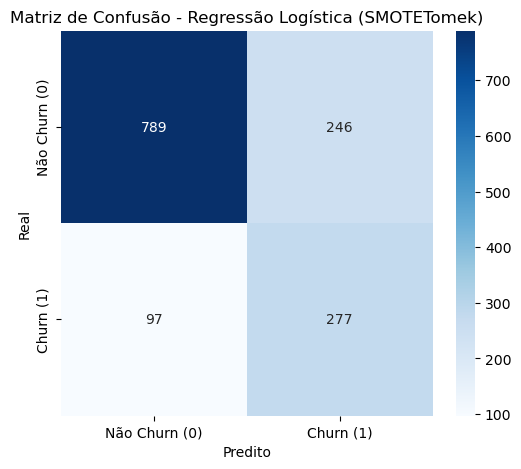


AUC-ROC (Regress√£o Log√≠stica com SMOTETomek): 0.8323


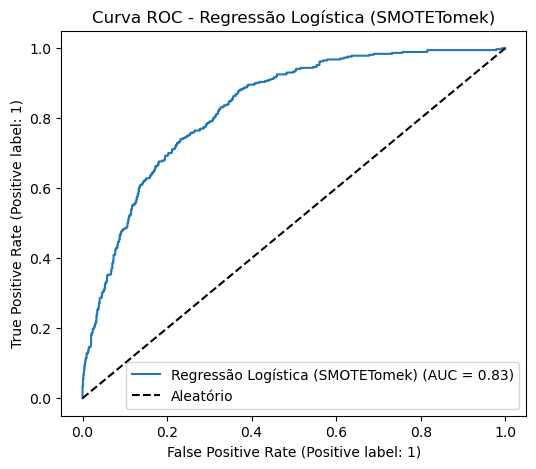

In [44]:
print("\n--- Treinando e Avaliando o Modelo de Regress√£o Log√≠stica com SMOTETomek ---")

# Regress√£o Log√≠stica
log_reg_smote_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # SEM class_weight='balanced'
log_reg_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg_smote = log_reg_smote_model.predict(X_test)
y_proba_log_reg_smote = log_reg_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica com SMOTETomek) ---")
print(classification_report(y_test, y_pred_log_reg_smote))

print("\n--- Matriz de Confus√£o (Regress√£o Log√≠stica com SMOTETomek) ---")
cm_log_reg_smote = confusion_matrix(y_test, y_pred_log_reg_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Regress√£o Log√≠stica (SMOTETomek)')
plt.show()

auc_log_reg_smote = roc_auc_score(y_test, y_proba_log_reg_smote)
print(f"\nAUC-ROC (Regress√£o Log√≠stica com SMOTETomek): {auc_log_reg_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_smote_model, X_test, y_test, ax=ax, name='Regress√£o Log√≠stica (SMOTETomek)')
plt.title('Curva ROC - Regress√£o Log√≠stica (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()


AUC-ROC (Regress√£o Log√≠stica com SMOTETomek): 0.8323


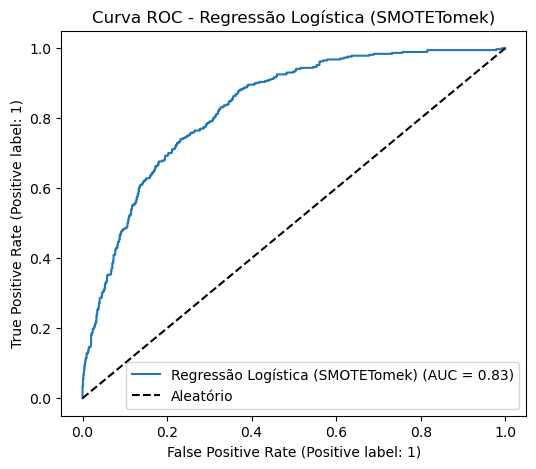

In [45]:
auc_log_reg_smote = roc_auc_score(y_test, y_proba_log_reg_smote)
print(f"\nAUC-ROC (Regress√£o Log√≠stica com SMOTETomek): {auc_log_reg_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_smote_model, X_test, y_test, ax=ax, name='Regress√£o Log√≠stica (SMOTETomek)')
plt.title('Curva ROC - Regress√£o Log√≠stica (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### Random Forest com SMOTETomek



--- Treinando e Avaliando o Modelo Random Forest com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (Random Forest com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409


--- Matriz de Confus√£o (Random Forest com SMOTETomek) ---


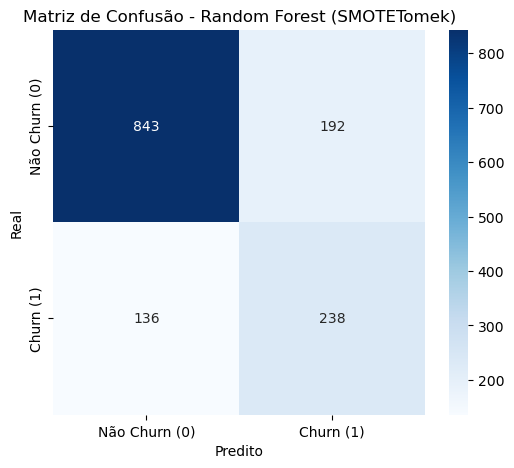

In [46]:
print("\n\n--- Treinando e Avaliando o Modelo Random Forest com SMOTETomek ---")

# Random Forest
rf_smote_model = RandomForestClassifier(random_state=42, n_estimators=100) # SEM class_weight='balanced'
rf_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_smote_model.predict(X_test)
y_proba_rf_smote = rf_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (Random Forest com SMOTETomek) ---")
print(classification_report(y_test, y_pred_rf_smote))

print("\n--- Matriz de Confus√£o (Random Forest com SMOTETomek) ---")
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Random Forest (SMOTETomek)')
plt.show()


AUC-ROC (Random Forest com SMOTETomek): 0.8167


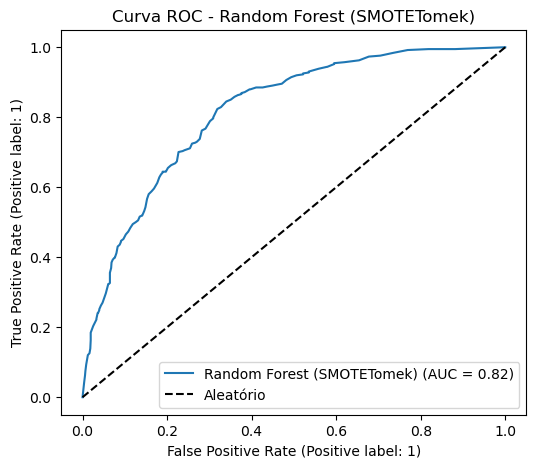

In [47]:
auc_rf_smote = roc_auc_score(y_test, y_proba_rf_smote)
print(f"\nAUC-ROC (Random Forest com SMOTETomek): {auc_rf_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_smote_model, X_test, y_test, ax=ax, name='Random Forest (SMOTETomek)')
plt.title('Curva ROC - Random Forest (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### SVM

SVM √© um poderoso algoritmo de classifica√ß√£o que busca encontrar o hiperplano que melhor separa as classes.

Observa√ß√£o: SVC com probability=True √© necess√°rio para usar predict_proba e, consequentemente, calcular o AUC-ROC. Isso pode aumentar o tempo de treinamento.



--- Treinando e Avaliando o Modelo SVM com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (SVM com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


--- Matriz de Confus√£o (SVM com SMOTETomek) ---


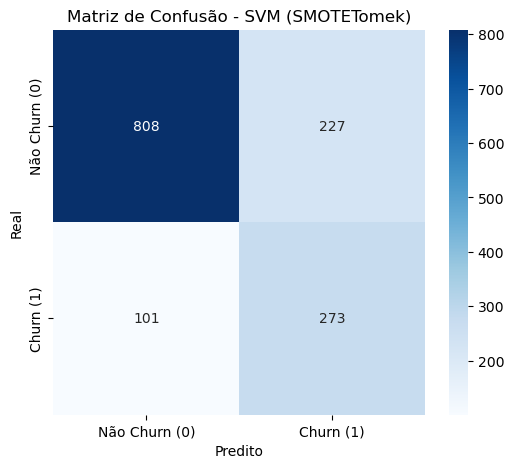


AUC-ROC (SVM com SMOTETomek): 0.8233


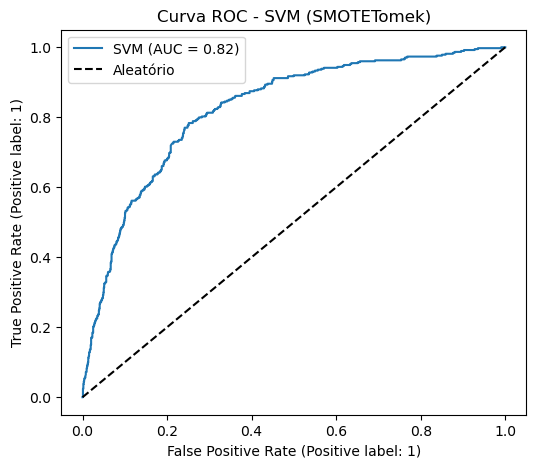

In [48]:
print("\n\n--- Treinando e Avaliando o Modelo SVM com SMOTETomek ---")

# Inicializar o modelo SVM
# kernel='rbf' √© um bom default para a maioria dos casos
# probability=True para poder calcular predict_proba (necess√°rio para AUC-ROC)
# random_state para reprodutibilidade
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Treinar o modelo
svm_model.fit(X_train_resampled, y_train_resampled)

# Fazer previs√µes no conjunto de teste
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avalia√ß√£o
print("\n--- Relat√≥rio de Classifica√ß√£o (SVM com SMOTETomek) ---")
print(classification_report(y_test, y_pred_svm))

print("\n--- Matriz de Confus√£o (SVM com SMOTETomek) ---")
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - SVM (SMOTETomek)')
plt.show()

auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"\nAUC-ROC (SVM com SMOTETomek): {auc_svm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(svm_model, X_test, y_test, ax=ax, name='SVM')
plt.title('Curva ROC - SVM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### Decision Tree 

Uma √Årvore de Decis√£o toma decis√µes com base em regras if-else aprendidas a partir dos dados. √â simples e interpret√°vel, mas pode ser propensa a overfitting.



--- Treinando e Avaliando o Modelo Decision Tree com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (Decision Tree com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1035
           1       0.50      0.61      0.55       374

    accuracy                           0.73      1409
   macro avg       0.67      0.69      0.68      1409
weighted avg       0.75      0.73      0.74      1409


--- Matriz de Confus√£o (Decision Tree com SMOTETomek) ---


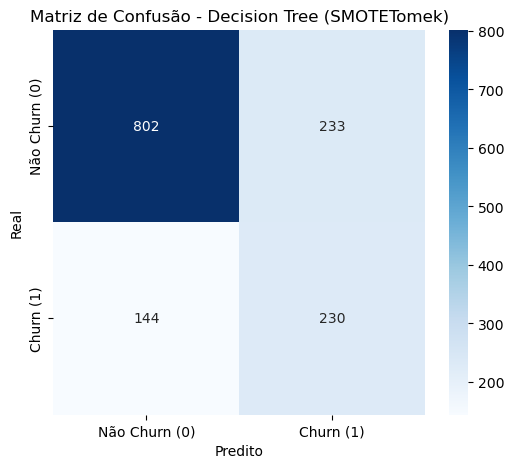


AUC-ROC (Decision Tree com SMOTETomek): 0.6958


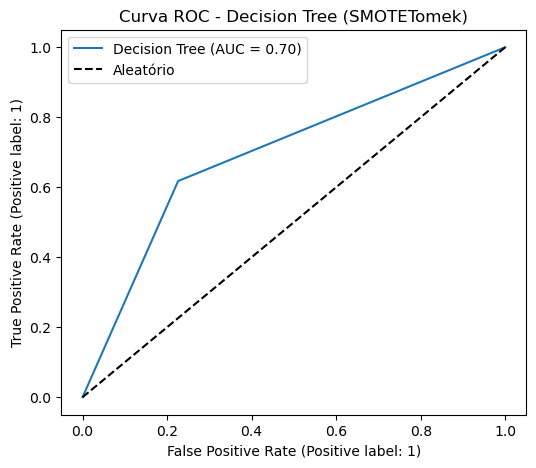

In [49]:
print("\n\n--- Treinando e Avaliando o Modelo Decision Tree com SMOTETomek ---")

# Inicializar o modelo Decision Tree
# random_state para reprodutibilidade
dt_model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo
dt_model.fit(X_train_resampled, y_train_resampled)

# Fazer previs√µes no conjunto de teste
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avalia√ß√£o
print("\n--- Relat√≥rio de Classifica√ß√£o (Decision Tree com SMOTETomek) ---")
print(classification_report(y_test, y_pred_dt))

print("\n--- Matriz de Confus√£o (Decision Tree com SMOTETomek) ---")
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Decision Tree (SMOTETomek)')
plt.show()

auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"\nAUC-ROC (Decision Tree com SMOTETomek): {auc_dt:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(dt_model, X_test, y_test, ax=ax, name='Decision Tree')
plt.title('Curva ROC - Decision Tree (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### XGBoost

XGBoost √© um algoritmo de gradient boosting que constr√≥i √°rvores de decis√£o sequencialmente, corrigindo os erros das √°rvores anteriores. √â conhecido por sua alta performance e robustez.



--- Treinando e Avaliando o Modelo XGBoost com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (XGBoost com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409


--- Matriz de Confus√£o (XGBoost com SMOTETomek) ---


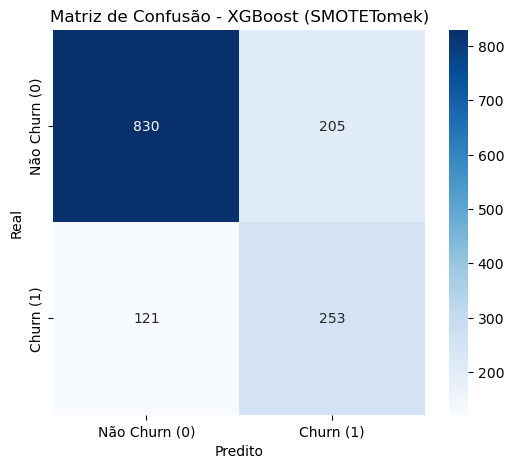


AUC-ROC (XGBoost com SMOTETomek): 0.8169


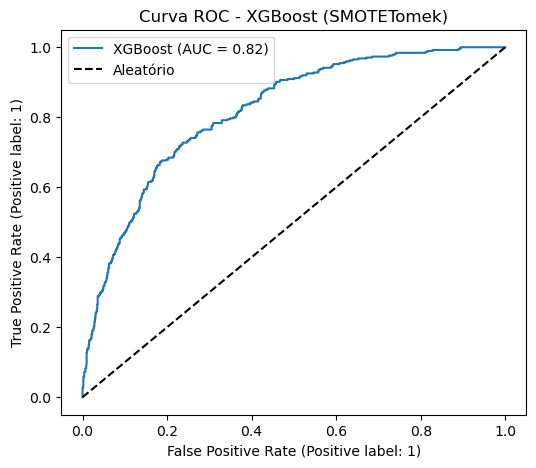

In [50]:
print("\n\n--- Treinando e Avaliando o Modelo XGBoost com SMOTETomek ---")

# Inicializar o modelo XGBoost
# objective='binary:logistic' para classifica√ß√£o bin√°ria
# eval_metric='logloss' para avalia√ß√£o do logloss
# use_label_encoder=False para evitar o warning (dependendo da vers√£o)
# random_state para reprodutibilidade
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Treinar o modelo
xgb_model.fit(X_train_resampled, y_train_resampled)

# Fazer previs√µes no conjunto de teste
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avalia√ß√£o
print("\n--- Relat√≥rio de Classifica√ß√£o (XGBoost com SMOTETomek) ---")
print(classification_report(y_test, y_pred_xgb))

print("\n--- Matriz de Confus√£o (XGBoost com SMOTETomek) ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - XGBoost (SMOTETomek)')
plt.show()

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"\nAUC-ROC (XGBoost com SMOTETomek): {auc_xgb:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')
plt.title('Curva ROC - XGBoost (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### LightGBM

LightGBM √© outro algoritmo de gradient boosting, otimizado para velocidade e efici√™ncia, especialmente com grandes datasets.



--- Treinando e Avaliando o Modelo LightGBM com SMOTETomek ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3965, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 7930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Relat√≥rio de Classifica√ß√£o (LightGBM com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.69      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       

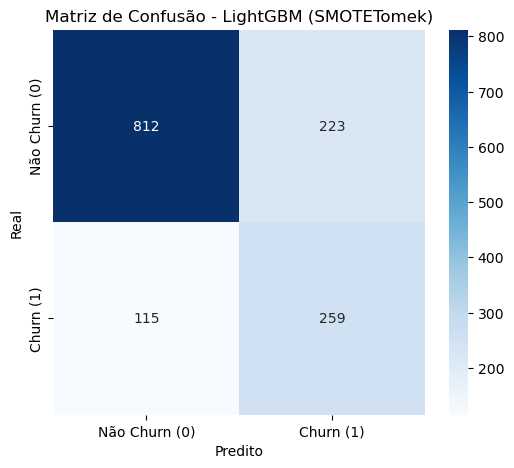


AUC-ROC (LightGBM com SMOTETomek): 0.8268


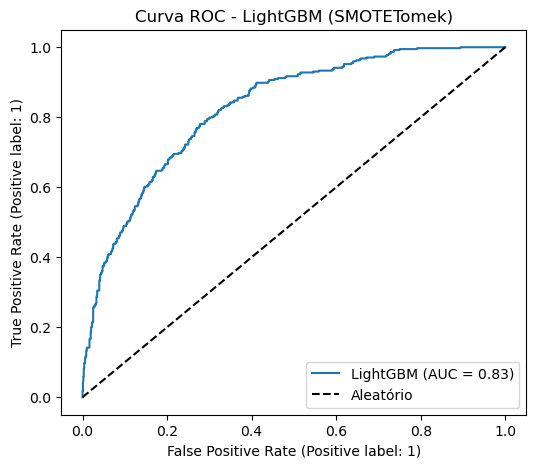

In [51]:
print("\n\n--- Treinando e Avaliando o Modelo LightGBM com SMOTETomek ---")

# Inicializar o modelo LightGBM
# objective='binary' para classifica√ß√£o bin√°ria
# metric='binary_logloss' para avalia√ß√£o do logloss
# random_state para reprodutibilidade
lgbm_model = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)

# Treinar o modelo
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Fazer previs√µes no conjunto de teste
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avalia√ß√£o
print("\n--- Relat√≥rio de Classifica√ß√£o (LightGBM com SMOTETomek) ---")
print(classification_report(y_test, y_pred_lgbm))

print("\n--- Matriz de Confus√£o (LightGBM com SMOTETomek) ---")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - LightGBM (SMOTETomek)')
plt.show()

auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print(f"\nAUC-ROC (LightGBM com SMOTETomek): {auc_lgbm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax, name='LightGBM')
plt.title('Curva ROC - LightGBM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

### K-Nearest Neighbors (KNN)

KNN √© um algoritmo n√£o-param√©trico que classifica um ponto de dados com base na maioria dos votos de seus k vizinhos mais pr√≥ximos. √â sens√≠vel √† escala dos dados e √† escolha de k.



--- Treinando e Avaliando o Modelo K-Nearest Neighbors (KNN) com SMOTETomek ---

--- Relat√≥rio de Classifica√ß√£o (KNN com SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1035
           1       0.48      0.74      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409


--- Matriz de Confus√£o (KNN com SMOTETomek) ---


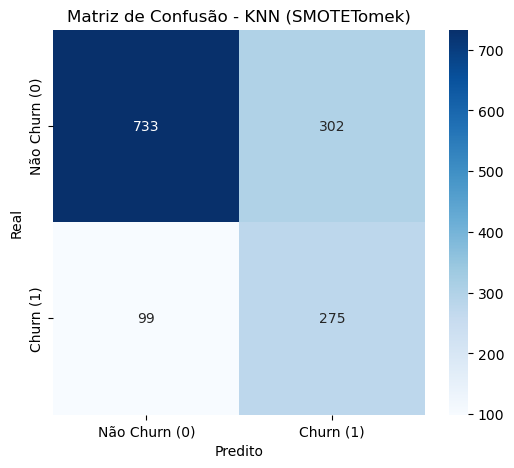


AUC-ROC (KNN com SMOTETomek): 0.7799


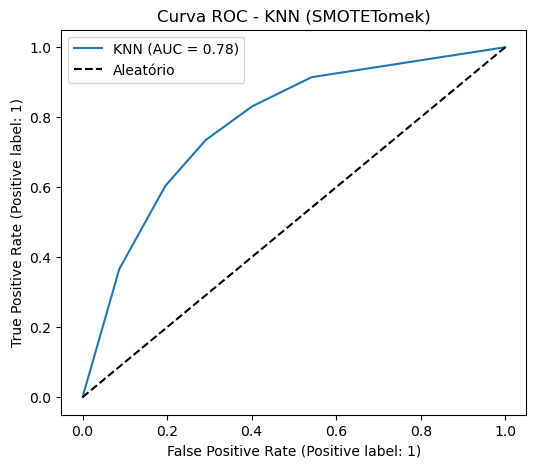

In [52]:
print("\n\n--- Treinando e Avaliando o Modelo K-Nearest Neighbors (KNN) com SMOTETomek ---")

# Inicializar o modelo KNN
# n_neighbors=5 √© um valor inicial comum, pode ser otimizado
knn_model = KNeighborsClassifier(n_neighbors=5)

# Treinar o modelo
knn_model.fit(X_train_resampled, y_train_resampled)

# Fazer previs√µes no conjunto de teste
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Churn)

# Avalia√ß√£o
print("\n--- Relat√≥rio de Classifica√ß√£o (KNN com SMOTETomek) ---")
print(classification_report(y_test, y_pred_knn))

print("\n--- Matriz de Confus√£o (KNN com SMOTETomek) ---")
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - KNN (SMOTETomek)')
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"\nAUC-ROC (KNN com SMOTETomek): {auc_knn:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(knn_model, X_test, y_test, ax=ax, name='KNN')
plt.title('Curva ROC - KNN (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()


### Tabela Resumo dos Resultados

Para facilitar a compara√ß√£o, compilei as m√©tricas mais relevantes para a classe **`1` (Churn)** para todos os modelos que voc√™ testou:

| Modelo                     | Abordagem               | Precis√£o (Churn=1) | Recall (Churn=1) | F1-Score (Churn=1) | AUC-ROC |
| :------------------------- | :---------------------- | :----------------- | :--------------- | :----------------- | :------ |
| Regress√£o Log√≠stica        | `class_weight='balanced'` | 0.51               | **0.78**         | 0.62               | **0.8389**|
| Random Forest              | `class_weight='balanced'` | **0.63**           | 0.49             | 0.55               | 0.8195  |
| Regress√£o Log√≠stica        | SMOTETomek              | 0.53               | 0.74             | 0.62               | 0.8323  |
| Random Forest              | SMOTETomek              | 0.55               | 0.64             | 0.59               | 0.8167  |
| SVM                        | SMOTETomek              | 0.55               | 0.73             | 0.62               | 0.8233  |
| Decision Tree              | SMOTETomek              | 0.50               | 0.61             | 0.55               | 0.6958  |
| XGBoost                    | SMOTETomek              | 0.55               | 0.68             | 0.61               | 0.8169  |
| LightGBM                   | SMOTETomek              | 0.54               | 0.69             | 0.61               | 0.8268  |
| K-Nearest Neighbors (KNN)  | SMOTETomek              | 0.48               | **0.74**         | 0.58               | 0.7799  |

*(Os valores nas colunas podem ter pequenas varia√ß√µes decimais devido ao arredondamento dos relat√≥rios, mas a ordem de grandeza e compara√ß√£o s√£o mantidas)*

---

### An√°lise Detalhada dos Resultados por Modelo e Abordagem

#### **1. Regress√£o Log√≠stica (`class_weight='balanced'`)**
*   **Recall (Churn): 0.78** - Muito bom! Conseguiu identificar 78% dos clientes que realmente iriam cancelar. Isso minimiza **Falsos Negativos** (clientes que cancelam mas o modelo n√£o previu).
*   **Precis√£o (Churn): 0.51** - Moderada. Dos clientes que o modelo previu que iriam cancelar, apenas 51% realmente cancelaram. Isso significa muitos **Falsos Positivos** (o modelo previu churn, mas n√£o houve).
*   **F1-Score (Churn): 0.62** - Bom, reflete o equil√≠brio entre precis√£o e recall.
*   **AUC-ROC: 0.8389** - Excelente! Indica uma forte capacidade de discriminar entre churners e n√£o-churners.
*   **Conclus√£o:** Este modelo √© **agressivo em capturar churners**, o que √© √≥timo para estrat√©gias de reten√ß√£o onde o custo de perder um cliente √© alto. No entanto, o custo de uma interven√ß√£o em um falso positivo deve ser considerado.

#### **2. Random Forest (`class_weight='balanced'`)**
*   **Recall (Churn): 0.49** - Mediano. Identifica menos da metade dos churners reais.
*   **Precis√£o (Churn): 0.63** - Melhor que a Regress√£o Log√≠stica. √â mais seletivo e tem menos falsos positivos.
*   **F1-Score (Churn): 0.55** - Inferior √† Regress√£o Log√≠stica, refletindo o Recall mais baixo.
*   **AUC-ROC: 0.8195** - Bom, mas ligeiramente inferior √† Regress√£o Log√≠stica.
*   **Conclus√£o:** Este modelo √© mais **conservador** em prever churn. Ele √© mais preciso quando prev√™ churn, mas perde muitos clientes que de fato cancelam. Bom se o custo de uma a√ß√£o de reten√ß√£o for muito alto e voc√™ s√≥ quiser intervir nos casos mais prov√°veis.

#### **3. Regress√£o Log√≠stica (SMOTETomek)**
*   **Recall (Churn): 0.74** - Ligeiramente menor que a RL com `class_weight`.
*   **Precis√£o (Churn): 0.53** - Ligeiramente maior que a RL com `class_weight`.
*   **F1-Score (Churn): 0.62** - Permanece o mesmo.
*   **AUC-ROC: 0.8323** - Ligeiramente menor que a RL com `class_weight`.
*   **Conclus√£o:** A abordagem SMOTETomek alterou a troca entre Precis√£o e Recall de forma marginal para a Regress√£o Log√≠stica, mas o Recall para Churn diminuiu um pouco e o AUC tamb√©m.

#### **4. Random Forest (SMOTETomek)**
*   **Recall (Churn): 0.64** - Houve um **aumento significativo** no Recall (de 0.49 para 0.64) em compara√ß√£o com o RF usando `class_weight`.
*   **Precis√£o (Churn): 0.55** - Houve uma **queda** na Precis√£o (de 0.63 para 0.55).
*   **F1-Score (Churn): 0.59** - Melhorou (de 0.55 para 0.59), indicando um melhor equil√≠brio geral p√≥s-SMOTETomek.
*   **AUC-ROC: 0.8167** - Ligeiramente menor que o RF com `class_weight`.
*   **Conclus√£o:** Para Random Forest, SMOTETomek claramente **priorizou o Recall**, tornando-o mais eficaz em identificar churners, mas √† custa de mais falsos positivos. Isso √© uma mudan√ßa positiva se o objetivo for capturar mais churners.

#### **5. SVM (SMOTETomek)**
*   **Recall (Churn): 0.73** - Muito bom, competitivo com a Regress√£o Log√≠stica.
*   **Precis√£o (Churn): 0.55** - Razo√°vel.
*   **F1-Score (Churn): 0.62** - Bom.
*   **AUC-ROC: 0.8233** - Bom.
*   **Conclus√£o:** O SVM com SMOTETomek apresenta um desempenho bastante equilibrado, com bom Recall e AUC, sendo um forte candidato.

#### **6. Decision Tree (SMOTETomek)**
*   **Recall (Churn): 0.61** - Razo√°vel.
*   **Precis√£o (Churn): 0.50** - Baixa.
*   **F1-Score (Churn): 0.55** - Baixo.
*   **AUC-ROC: 0.6958** - **Significativamente mais baixo** que os outros modelos.
*   **Conclus√£o:** A √Årvore de Decis√£o, sem otimiza√ß√£o de hiperpar√¢metros, n√£o performou bem. Sua baixa AUC sugere que ela n√£o consegue discriminar bem entre as classes, provavelmente devido a overfitting ou √† sua natureza mais simples comparada aos ensembles.

#### **7. XGBoost (SMOTETomek)**
*   **Recall (Churn): 0.68** - Bom.
*   **Precis√£o (Churn): 0.55** - Razo√°vel.
*   **F1-Score (Churn): 0.61** - Bom.
*   **AUC-ROC: 0.8169** - Bom.
*   **Conclus√£o:** O XGBoost apresenta um bom equil√≠brio entre Recall e Precis√£o, com um F1-Score s√≥lido e AUC competitivo. √â uma escolha robusta.

#### **8. LightGBM (SMOTETomek)**
*   **Recall (Churn): 0.69** - Muito bom, ligeiramente melhor que XGBoost.
*   **Precis√£o (Churn): 0.54** - Razo√°vel.
*   **F1-Score (Churn): 0.61** - Bom.
*   **AUC-ROC: 0.8268** - Muito bom, competitivo com os melhores AUCs.
*   **Conclus√£o:** LightGBM √© ligeiramente superior ao XGBoost em termos de Recall e AUC neste cen√°rio, sendo outro forte candidato. √â not√°vel sua efici√™ncia computacional.

#### **9. K-Nearest Neighbors (KNN) (SMOTETomek)**
*   **Recall (Churn): 0.74** - Muito bom, similar √† Regress√£o Log√≠stica!
*   **Precis√£o (Churn): 0.48** - **Baixa.** Este √© o pior resultado de Precis√£o entre todos os modelos.
*   **F1-Score (Churn): 0.58** - Mediano, mas impactado pela baixa Precis√£o.
*   **AUC-ROC: 0.7799** - O mais baixo entre os modelos promissores, sugerindo menos poder de discrimina√ß√£o geral.
*   **Conclus√£o:** O KNN √© muito bom em capturar churners, mas gera um n√∫mero extremamente alto de falsos positivos, o que poderia tornar as a√ß√µes de reten√ß√£o muito caras e ineficientes.

---

### Por que a Regress√£o Log√≠stica (`class_weight='balanced'`) Teve Melhor Performance (em Recall e AUC) que a RL com SMOTETomek?

Sua observa√ß√£o √© **extremamente perspicaz** e toca em um ponto crucial da ci√™ncia de dados!

Ao comparar:

*   **Regress√£o Log√≠stica (`class_weight='balanced'`):** Recall (1)=**0.78**, Precis√£o (1)=0.51, AUC=**0.8389**
*   **Regress√£o Log√≠stica (SMOTETomek):** Recall (1)=0.74, Precis√£o (1)=**0.53**, AUC=0.8323

Voc√™ est√° correto: a vers√£o `class_weight='balanced'` da Regress√£o Log√≠stica obteve um Recall para a classe Churn ligeiramente maior e uma AUC superior, apesar de uma Precis√£o um pouco menor.

**Raz√µes para este comportamento:**

1.  **Natureza da Regress√£o Log√≠stica (Modelo Linear) e `class_weight`:**
    *   A Regress√£o Log√≠stica √© um **modelo linear**. Ela tenta encontrar um hiperplano (uma linha ou superf√≠cie) para separar as classes.
    *   O par√¢metro `class_weight='balanced'` atua como um **ajuste de custo (cost-sensitive learning)**. Ele n√£o altera a distribui√ß√£o f√≠sica dos dados de treinamento, mas informa ao algoritmo que os erros na classe minorit√°ria s√£o mais \\\"caros\\\" durante o processo de otimiza√ß√£o (minimiza√ß√£o da fun√ß√£o de perda). Isso faz com que a fronteira de decis√£o linear do modelo se incline para \\\"proteger\\\" a classe minorit√°ria, mesmo que isso signifique um aumento nos falsos positivos para a classe majorit√°ria.
    *   Para problemas onde a separabilidade √© razoavelmente linear (ou linear ap√≥s as transforma√ß√µes de features que voc√™ j√° fez), esse ajuste de custo pode ser muito eficaz e direto, movendo a fronteira de decis√£o de forma otimizada para capturar a classe minorit√°ria.

2.  **Limita√ß√µes do SMOTE e Complexidade dos Dados Sint√©ticos:**
    *   **Gera√ß√£o de Amostras Sint√©ticas:** SMOTE cria novas amostras interpolando entre as amostras existentes. Embora seja melhor do que oversampling aleat√≥rio, as amostras sint√©ticas podem, em alguns casos:
        *   **Introduzir Ru√≠do:** Se a classe minorit√°ria √© intrinsecamente ruidosa ou tem muitos outliers, o SMOTE pode gerar amostras sint√©ticas que amplificam esse ru√≠do ou assemelham-se a outliers.
        *   **N√£o Capturar a Verdadeira Complexidade:** Se a verdadeira fronteira de decis√£o √© muito complexa e n√£o-linear, os pontos sint√©ticos gerados linearmente entre vizinhos podem n√£o representar fielmente a distribui√ß√£o subjacente da classe minorit√°ria, levando o modelo a aprender uma fronteira menos ideal.
        *   **Over-generalization:** √Äs vezes, o SMOTE pode criar regi√µes densas de pontos sint√©ticos que fazem o modelo generalizar demais para a classe minorit√°ria, at√© mesmo em √°reas onde a classe majorit√°ria deveria dominar, resultando em mais falsos positivos e, por vezes, uma leve queda na capacidade de discrimina√ß√£o geral (AUC).
    *   **Impacto no Conjunto de Teste Original:** O modelo treinado com SMOTETomek √© exposto a uma distribui√ß√£o de treinamento alterada. Quando avaliado no conjunto de teste *original* (desbalanceado), pode ser que a fronteira de decis√£o aprendida no dataset reamostrado n√£o se generalize t√£o bem √† distribui√ß√£o natural dos dados como a fronteira linear ajustada por `class_weight`. A t√©cnica `class_weight` nunca \"mentiu\" sobre o n√∫mero real de samples, apenas alterou a penalidade.

3.  **Natureza do Tomek Links:** A remo√ß√£o de Tomek Links visa limpar a fronteira. No entanto, se um ponto da classe majorit√°ria √© um Tomek Link para um ponto da minorit√°ria, sua remo√ß√£o pode, em certos cen√°rios, remover informa√ß√µes que ajudariam o modelo a aprender uma fronteira mais fina e complexa, ou remover pontos que eram importantes para delimitar a regi√£o da classe majorit√°ria.

**Em resumo:** Para o modelo linear de Regress√£o Log√≠stica neste dataset espec√≠fico, o m√©todo `class_weight='balanced'` pareceu ser um **ajuste mais direto e eficaz** para o problema de desbalanceamento, sem a potencial complexidade ou introdu√ß√£o de ru√≠do que a gera√ß√£o de dados sint√©ticos pelo SMOTETomek pode, ocasionalmente, trazer. √â uma prova de que nem sempre a t√©cnica mais complexa √© a melhor; a experimenta√ß√£o √© fundamental.

---

### Considera√ß√µes e Pr√≥ximos Passos Sugeridos

Voc√™ tem agora uma excelente vis√£o do desempenho de v√°rios modelos.

**Melhores Modelos Atuais (com base no Recall e AUC para Churn):**

1.  **Regress√£o Log√≠stica (`class_weight='balanced'`):** √ìtimo Recall (0.78) e o melhor AUC (0.8389). Sua desvantagem √© a Precis√£o mais baixa (0.51).
2.  **SVM (SMOTETomek):** Bom Recall (0.73) e F1-Score (0.62), com bom AUC (0.8233).
3.  **LightGBM (SMOTETomek):** Bom Recall (0.69) e um dos melhores AUCs (0.8268), com F1-Score competitivo (0.61).
4.  **XGBoost (SMOTETomek):** Desempenho muito pr√≥ximo ao LightGBM, ligeiramente menor Recall e AUC, mas ainda forte.

**Pr√≥ximos Passos:**

1.  **Definir Prioridade de Neg√≥cio:**
    *   **Qual √© mais importante para o seu projeto: Minimizar Falsos Negativos (alt√≠ssimo Recall, capturar *todos* os churners, mesmo com muitos Falsos Positivos)** ou **Minimizar Falsos Positivos (alt√≠ssima Precis√£o, intervir *apenas* em churners muito prov√°veis, mesmo que perca alguns)**?
    *   Se perder um cliente custa muito (alto LTV), o Recall √© mais cr√≠tico (Regress√£o Log√≠stica com `class_weight` e SVM com SMOTE s√£o fortes).
    *   Se as a√ß√µes de reten√ß√£o s√£o caras ou intrusivas, a Precis√£o √© mais cr√≠tica (Random Forest com `class_weight` seria uma op√ß√£o, mas o Recall √© muito baixo).
    *   Se busca um equil√≠brio, F1-Score e AUC s√£o guias.

2.  **Otimiza√ß√£o de Hiperpar√¢metros (Hyperparameter Tuning):**
    *   Nenhum dos modelos foi otimizado al√©m dos par√¢metros padr√£o ou valores b√°sicos (`n_estimators`). A otimiza√ß√£o pode melhorar significativamente o desempenho, especialmente para modelos como Random Forest, XGBoost, LightGBM e SVM.
    *   **Recomenda√ß√£o:** Utilize `GridSearchCV` ou `RandomizedSearchCV` com **cross-validation estrat√©gica** (por exemplo, `StratifiedKFold` para manter a propor√ß√£o das classes em cada fold, se voc√™ ainda for usar `class_weight` ou se a reamostragem for aplicada dentro do pipeline de valida√ß√£o cruzada).
    *   Para os modelos treinados com SMOTETomek, o tuning ser√° feito em `X_train_resampled`.
    *   Para os modelos `class_weight='balanced'`, o tuning ser√° em `X_train`.

3.  **Ajuste do Ponto de Corte (Threshold Optimization):**
    *   A maioria dos classificadores tem um ponto de corte padr√£o de 0.5. Voc√™ pode ajustar esse limiar de probabilidade para otimizar o Recall ou a Precis√£o, dependendo do objetivo de neg√≥cio.
    *   **Ferramentas:** Curva de Precis√£o-Recall (Precision-Recall Curve) e Curva ROC podem ajudar a visualizar a troca entre essas m√©tricas em diferentes limiares.

4.  **Engenharia de Features Adicional:**
    *   Ser√° que h√° mais insights a serem extra√≠dos dos dados ou novas features a serem criadas (ex: intera√ß√µes entre features)?
    *   Analisar as **feature importances** dos modelos baseados em √°rvores (Random Forest, XGBoost, LightGBM) pode fornecer insights sobre quais vari√°veis s√£o mais importantes na previs√£o de churn, o que pode guiar novas estrat√©gias de neg√≥cio ou a cria√ß√£o de novas features.

5.  **Conjunto de Valida√ß√£o (Opcional, mas Recomendado):** Para uma avalia√ß√£o ainda mais robusta, especialmente ap√≥s o tuning, pode-se separar um pequeno conjunto de valida√ß√£o do treinamento original (al√©m do teste).

6.  **Modelos Ensemble / Stacking (Futuro):** Ap√≥s otimizar os modelos individuais, voc√™ pode tentar combinar as previs√µes dos melhores modelos (por exemplo, a Regress√£o Log√≠stica e o LightGBM) usando t√©cnicas de ensemble ou stacking para tentar obter um desempenho ainda melhor.

Voc√™ est√° no caminho certo para construir um modelo robusto de previs√£o de churn!

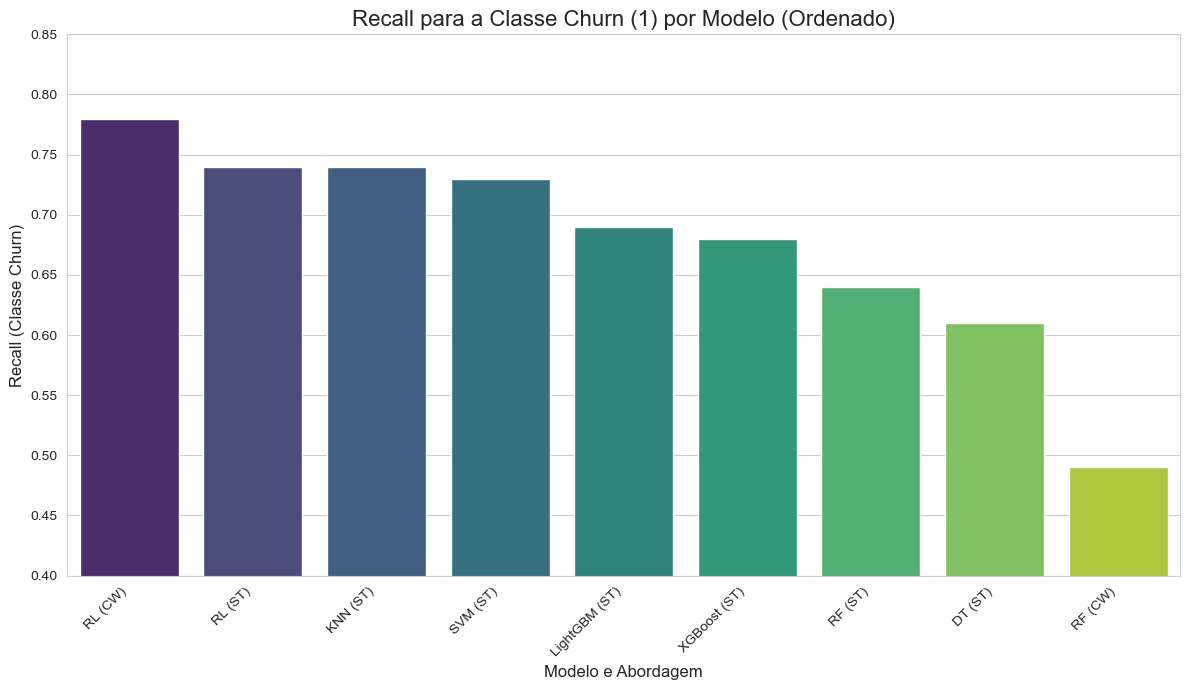

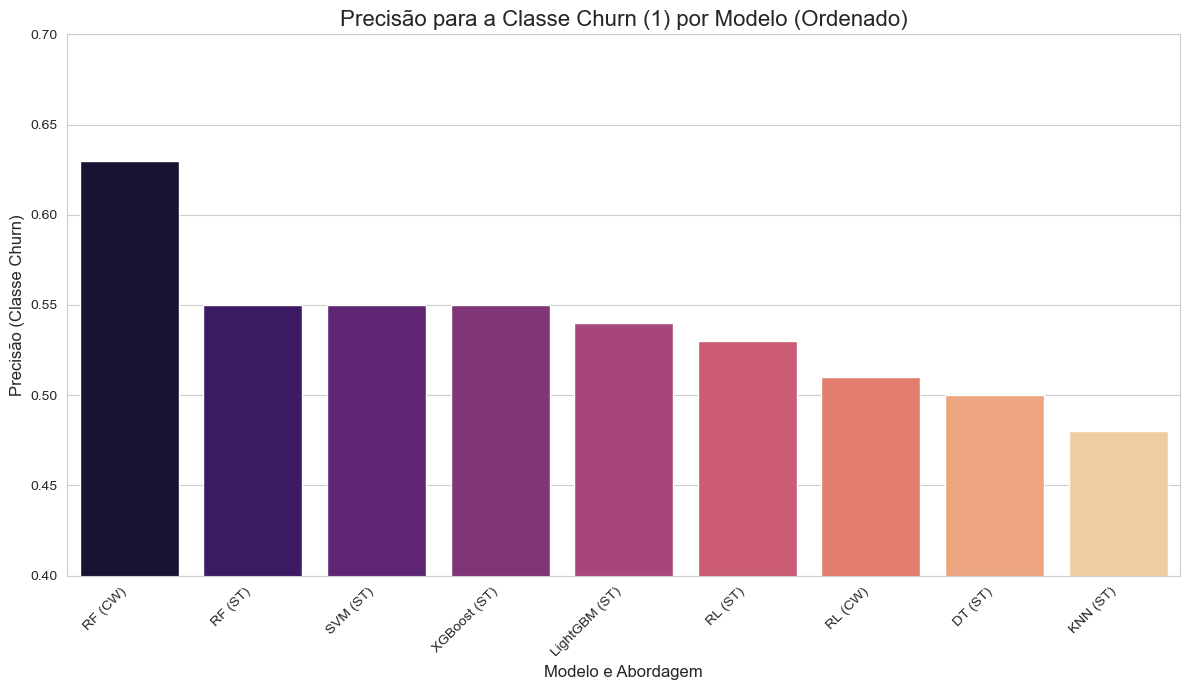

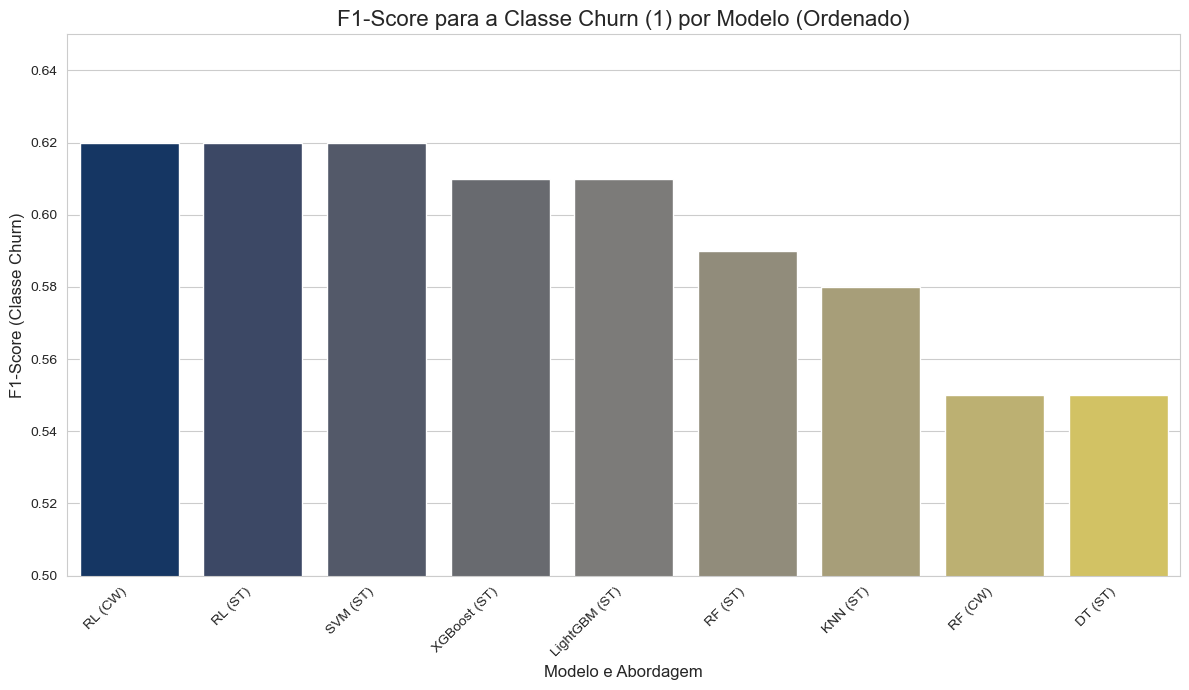

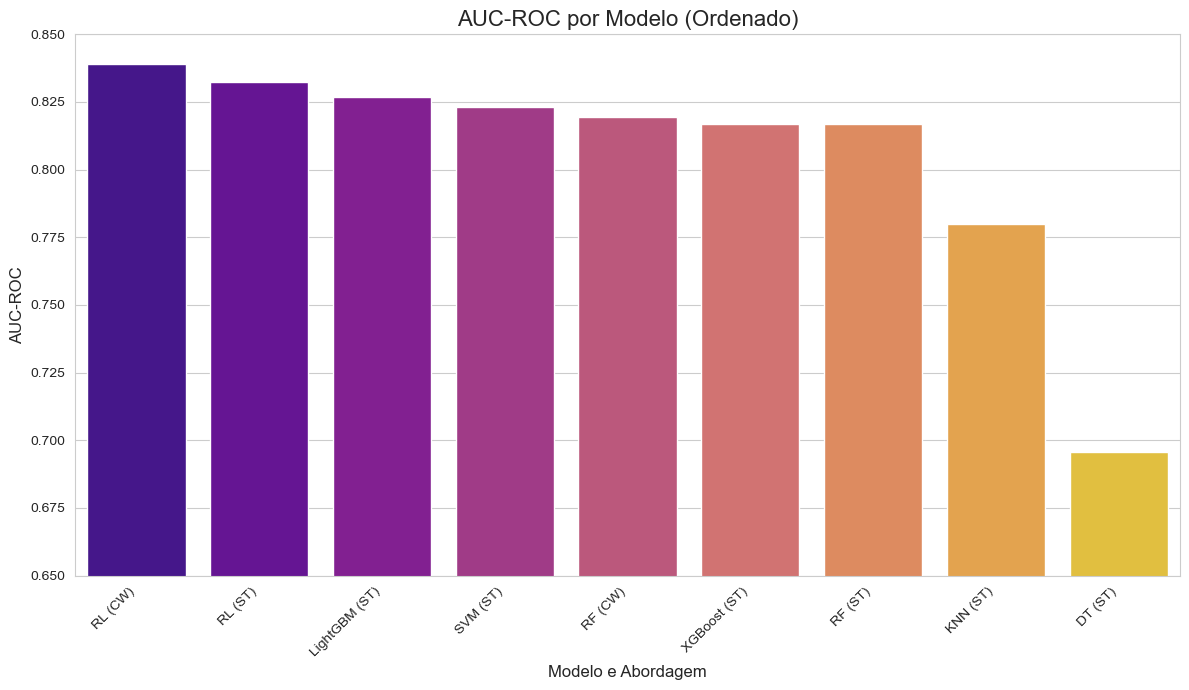

In [53]:
# --- Dados da Tabela de Resultados ---
data = {
    'Modelo': [
        'Regress√£o Log√≠stica', 'Random Forest',
        'Regress√£o Log√≠stica', 'Random Forest',
        'SVM', 'Decision Tree', 'XGBoost', 'LightGBM', 'K-Nearest Neighbors (KNN)'
    ],
    'Abordagem': [
        'class_weight=\'balanced\'', 'class_weight=\'balanced\'',
        'SMOTETomek', 'SMOTETomek', 'SMOTETomek',
        'SMOTETomek', 'SMOTETomek', 'SMOTETomek', 'SMOTETomek'
    ],
    'Precis√£o (Churn=1)': [0.51, 0.63, 0.53, 0.55, 0.55, 0.50, 0.55, 0.54, 0.48],
    'Recall (Churn=1)': [0.78, 0.49, 0.74, 0.64, 0.73, 0.61, 0.68, 0.69, 0.74],
    'F1-Score (Churn=1)': [0.62, 0.55, 0.62, 0.59, 0.62, 0.55, 0.61, 0.61, 0.58],
    'AUC-ROC': [0.8389, 0.8195, 0.8323, 0.8167, 0.8233, 0.6958, 0.8169, 0.8268, 0.7799]
}

df_results = pd.DataFrame(data)

# Criar uma coluna combinada para r√≥tulos mais curtos nos gr√°ficos
df_results['Modelo_Label'] = df_results['Modelo'].apply(lambda x: x.replace('Regress√£o Log√≠stica', 'RL').replace('Random Forest', 'RF').replace('Decision Tree', 'DT').replace('K-Nearest Neighbors (KNN)', 'KNN')) + " (" + df_results['Abordagem'].apply(lambda x: 'CW' if 'class_weight' in x else 'ST') + ")"

# --- Configura√ß√µes de Plotagem ---
sns.set_style("whitegrid") # Estilo dos gr√°ficos
plt.rcParams['figure.figsize'] = (10, 6) # Tamanho padr√£o da figura

# --- Gr√°fico de Barras para Recall (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo Recall (Churn=1) em ordem decrescente para este gr√°fico
df_sorted_recall = df_results.sort_values(by='Recall (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Recall (Churn=1)', data=df_sorted_recall, palette='viridis')
plt.title('Recall para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('Recall (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para Precis√£o (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pela Precis√£o (Churn=1) em ordem decrescente para este gr√°fico
df_sorted_precision = df_results.sort_values(by='Precis√£o (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Precis√£o (Churn=1)', data=df_sorted_precision, palette='magma')
plt.title('Precis√£o para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('Precis√£o (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para F1-Score (Churn=1) ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo F1-Score (Churn=1) em ordem decrescente para este gr√°fico
df_sorted_f1 = df_results.sort_values(by='F1-Score (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='F1-Score (Churn=1)', data=df_sorted_f1, palette='cividis')
plt.title('F1-Score para a Classe Churn (1) por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('F1-Score (Classe Churn)', fontsize=12)
plt.ylim(0.5, 0.65)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para AUC-ROC ---
plt.figure(figsize=(12, 7))
# Ordenar o DataFrame pelo AUC-ROC em ordem decrescente para este gr√°fico
df_sorted_auc = df_results.sort_values(by='AUC-ROC', ascending=False)
sns.barplot(x='Modelo_Label', y='AUC-ROC', data=df_sorted_auc, palette='plasma')
plt.title('AUC-ROC por Modelo (Ordenado)', fontsize=16)
plt.xlabel('Modelo e Abordagem', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Justificativa: Por que o Recall √© Crucial na Previs√£o de Churn (sem menosprezar outras m√©tricas)
No contexto da previs√£o de churn de clientes, o Recall (tamb√©m conhecido como Sensibilidade ou Cobertura) √© a m√©trica prim√°ria a ser otimizada. Ele mede a capacidade do nosso modelo em identificar corretamente a maior propor√ß√£o poss√≠vel de clientes que realmente v√£o deixar a empresa (a classe minorit√°ria "Churn").

Por que priorizamos o Recall?

Minimiza√ß√£o de Perdas de Clientes (Falsos Negativos): O custo de um Falso Negativo (um cliente que o modelo previu que n√£o iria ter churn, mas que na verdade cancelou) √© geralmente muito alto para uma empresa. Cada cliente perdido representa n√£o apenas a interrup√ß√£o de receita futura, mas tamb√©m a potencial perda de valor de vida √∫til (Lifetime Value - LTV), custos de aquisi√ß√£o de novos clientes e impacto negativo na reputa√ß√£o. Um Recall alto significa que estamos minimizando esses Falsos Negativos, garantindo que a maioria dos clientes em risco de churn seja sinalizada para interven√ß√£o.

Oportunidade de Interven√ß√£o Proativa: Ao identificar um cliente com alta probabilidade de churn (gra√ßas a um Recall elevado), a empresa ganha a oportunidade de implementar estrat√©gias de reten√ß√£o direcionadas (ofertas personalizadas, suporte proativo, pesquisas de satisfa√ß√£o). Perder essa oportunidade por um Falso Negativo √© o erro mais custoso neste cen√°rio.

Import√¢ncia das Outras M√©tricas:

Embora o Recall seja a prioridade, n√£o menosprezamos a Precis√£o, o F1-Score e a AUC-ROC:

Precis√£o: Controla o custo das interven√ß√µes. Uma Precis√£o muito baixa (muitos Falsos Positivos ‚Äì clientes que o modelo previu que iriam ter churn, mas que na verdade n√£o iriam) pode levar ao desperd√≠cio de recursos em a√ß√µes de reten√ß√£o desnecess√°rias ou, pior, a irritar clientes satisfeitos. Buscamos um equil√≠brio: queremos capturar a maioria dos churners (alto Recall), mas sem gastar excessivamente ou incomodar clientes que n√£o precisam de interven√ß√£o (Precis√£o razo√°vel).
F1-Score: Oferece uma vis√£o equilibrada do modelo, ponderando a Precis√£o e o Recall. √â √∫til para comparar modelos que podem ter diferentes compensa√ß√µes entre essas duas m√©tricas.
AUC-ROC: Mede a capacidade geral de discrimina√ß√£o do modelo entre as classes. Um alto AUC indica que o modelo √© bom em ranquear corretamente as probabilidades de churn, o que √© valioso para definir pontos de corte e estrat√©gias de segmenta√ß√£o.
Em resumo, nosso foco √© garantir que o maior n√∫mero poss√≠vel de clientes em risco de churn seja identificado (alto Recall), permitindo a√ß√µes de reten√ß√£o eficazes. As outras m√©tricas nos ajudam a refinar o modelo, garantindo que essas interven√ß√µes sejam t√£o eficientes e direcionadas quanto poss√≠vel, otimizando o retorno sobre o investimento em preven√ß√£o de churn.

### Otimiza√ß√£o dos Hiperparametros

a Regress√£o Log√≠stica com class_weight='balanced' apresentou um Recall e AUC superiores (0.78 e 0.8389, respectivamente) em compara√ß√£o com a mesma Regress√£o Log√≠stica com SMOTETomek (0.74 e 0.8323) √© um indicativo forte de que nem sempre a t√©cnica de reamostragem mais complexa √© a melhor solu√ß√£o.

Justificativa para Treinar Modelos sem SMOTETomek (Focando em class_weight ou Equivalentes)
Sua sugest√£o √© perfeitamente v√°lida e, de fato, a abordagem correta quando os resultados iniciais apontam para essa dire√ß√£o. Aqui est√° a justificativa que pode ser usada no seu projeto:

"Embora t√©cnicas de reamostragem como SMOTETomek sejam poderosas para lidar com o desbalanceamento de classes, a experimenta√ß√£o pr√°tica revelou que, para o nosso conjunto de dados e para a otimiza√ß√£o do Recall na previs√£o de Churn, abordagens intr√≠nsecas aos modelos, como o par√¢metro class_weight='balanced' ou scale_pos_weight, demonstraram maior efic√°cia inicial.

A principal vantagem de utilizar esses par√¢metros √© que eles ajustam o processo de aprendizado do modelo de forma a penalizar mais severamente os erros na classe minorit√°ria (Churn), sem a necessidade de modificar a distribui√ß√£o original dos dados de treinamento atrav√©s da cria√ß√£o de amostras sint√©ticas ou remo√ß√£o de amostras reais.

Para modelos lineares como a Regress√£o Log√≠stica, e para modelos baseados em √°rvores que podem lidar com pesos de amostra, essa abordagem de 'custo sens√≠vel' muitas vezes permite que o algoritmo encontre uma fronteira de decis√£o mais robusta e generaliz√°vel para o problema desbalanceado, refletindo melhor a realidade dos dados no conjunto de teste. O uso de class_weight ou scale_pos_weight evita a potencial introdu√ß√£o de ru√≠do ou a cria√ß√£o de padr√µes artificiais que, em alguns casos, podem ocorrer com a gera√ß√£o de dados sint√©ticos (SMOTE), mesmo quando combinada com t√©cnicas de limpeza (Tomek Links).

Portanto, para a fase de otimiza√ß√£o de hiperpar√¢metros, priorizaremos modelos que utilizam esses mecanismos internos de balanceamento, buscando maximizar o Recall da classe Churn de forma mais eficiente."

C√≥digos Python para Otimiza√ß√£o de Hiperpar√¢metros (Sem SMOTETomek)
Vamos otimizar os hiperpar√¢metros dos seguintes modelos, utilizando o class_weight='balanced' ou o equivalente scale_pos_weight, que √© mais comum em modelos de boosting:

Regress√£o Log√≠stica (class_weight='balanced')
Random Forest Classifier (class_weight='balanced')
Support Vector Machine (SVM) (class_weight='balanced')
XGBoost Classifier (scale_pos_weight)
LightGBM Classifier (scale_pos_weight)
Antes de iniciar, precisamos calcular o scale_pos_weight, que √© a raz√£o entre o n√∫mero de amostras da classe majorit√°ria e o n√∫mero de amostras da classe minorit√°ria no conjunto de treinamento.

In [54]:
count_class_0 = y_train.value_counts()[0]
count_class_1 = y_train.value_counts()[1]
scale_pos_weight_value = count_class_0 / count_class_1

print(f"N√∫mero de N√£o Churn (classe 0) no treino: {count_class_0}")
print(f"N√∫mero de Churn (classe 1) no treino: {count_class_1}")
print(f"scale_pos_weight calculado: {scale_pos_weight_value:.4f}")

# Definir a m√©trica de scoring para a valida√ß√£o cruzada
# Priorizamos o Recall da classe 1 (Churn)
recall_scorer = make_scorer(recall_score, pos_label=1)

N√∫mero de N√£o Churn (classe 0) no treino: 4139
N√∫mero de Churn (classe 1) no treino: 1495
scale_pos_weight calculado: 2.7686


1. Regress√£o Log√≠stica (class_weight='balanced')
Justificativa: A Regress√£o Log√≠stica, sendo um modelo linear, se beneficia diretamente do class_weight='balanced' ajustando a fun√ß√£o de custo para penalizar mais os erros da classe minorit√°ria, sem alterar a distribui√ß√£o dos dados.


--- Otimizando Hiperpar√¢metros para Regress√£o Log√≠stica (class_weight='balanced') ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores Par√¢metros (Regress√£o Log√≠stica): {'C': 0.001}
Melhor Recall (Regress√£o Log√≠stica) no CV: 0.7946

--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



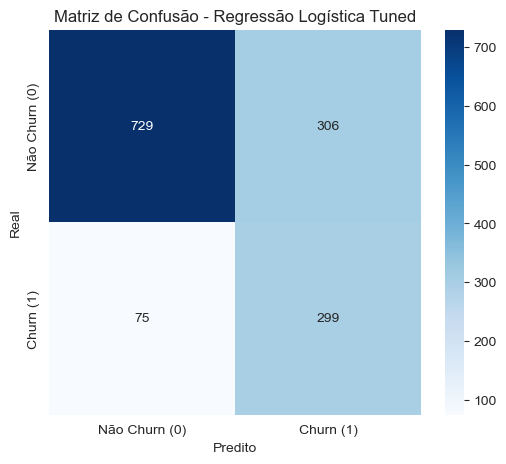

AUC-ROC (Regress√£o Log√≠stica Tuned): 0.8353


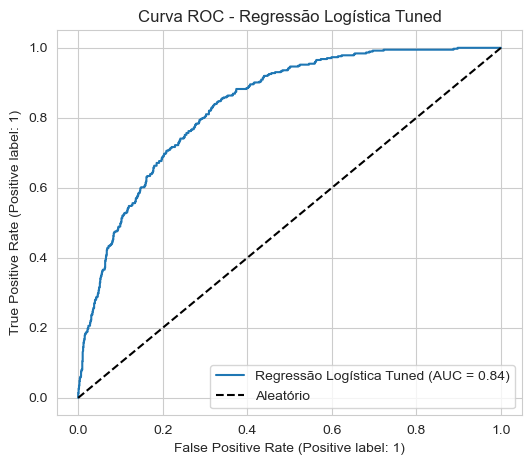

In [55]:
print("\n--- Otimizando Hiperpar√¢metros para Regress√£o Log√≠stica (class_weight='balanced') ---")

log_reg_base = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

param_grid_lr = {
    'C': np.logspace(-3, 2, 6) # Par√¢metro de regulariza√ß√£o (inverso da for√ßa de regulariza√ß√£o)
}

grid_search_lr = GridSearchCV(estimator=log_reg_base,
                              param_grid=param_grid_lr,
                              scoring=recall_scorer,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              n_jobs=-1,
                              verbose=1)

grid_search_lr.fit(X_train, y_train)

print(f"Melhores Par√¢metros (Regress√£o Log√≠stica): {grid_search_lr.best_params_}")
print(f"Melhor Recall (Regress√£o Log√≠stica) no CV: {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr_model.predict(X_test)
y_proba_lr_tuned = best_lr_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (Regress√£o Log√≠stica Tuned) ---")
print(classification_report(y_test, y_pred_lr_tuned))

cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Regress√£o Log√≠stica Tuned')
plt.show()

auc_lr_tuned = roc_auc_score(y_test, y_proba_lr_tuned)
print(f"AUC-ROC (Regress√£o Log√≠stica Tuned): {auc_lr_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lr_model, X_test, y_test, ax=ax, name='Regress√£o Log√≠stica Tuned')
plt.title('Curva ROC - Regress√£o Log√≠stica Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

2. Random Forest Classifier (class_weight='balanced')
Justificativa: Random Forests, sendo ensembles de √°rvores de decis√£o, podem incorporar class_weight durante a constru√ß√£o de cada √°rvore, influenciando o crit√©rio de divis√£o e o balan√ßo das classes. Este m√©todo foi o segundo melhor em termos de Precis√£o na an√°lise inicial.



--- Otimizando Hiperpar√¢metros para Random Forest (class_weight='balanced') ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores Par√¢metros (Random Forest): {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Melhor Recall (Random Forest) no CV: 0.7378

--- Relat√≥rio de Classifica√ß√£o (Random Forest Tuned) ---
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



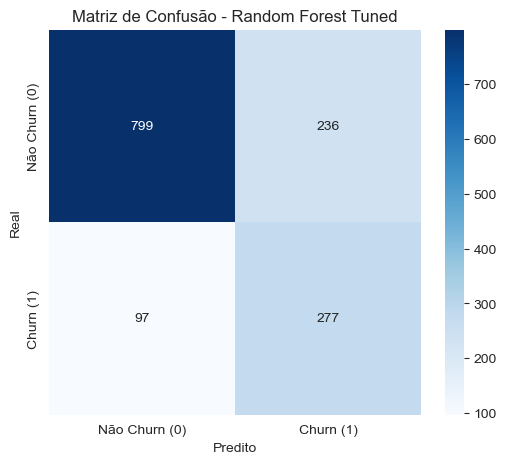

AUC-ROC (Random Forest Tuned): 0.8421


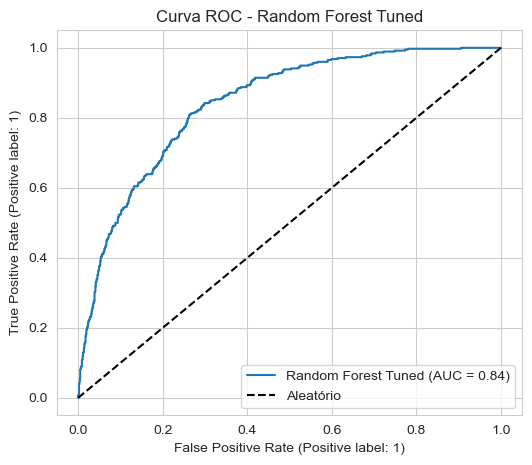

In [56]:
print("\n\n--- Otimizando Hiperpar√¢metros para Random Forest (class_weight='balanced') ---")

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300], # N√∫mero de √°rvores
    'max_depth': [None, 10, 20], # Profundidade m√°xima da √°rvore
    'min_samples_split': [2, 5, 10] # N√∫mero m√≠nimo de amostras para dividir um n√≥
}

grid_search_rf = GridSearchCV(estimator=rf_base,
                              param_grid=param_grid_rf,
                              scoring=recall_scorer,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              n_jobs=-1,
                              verbose=1)

grid_search_rf.fit(X_train, y_train)

print(f"Melhores Par√¢metros (Random Forest): {grid_search_rf.best_params_}")
print(f"Melhor Recall (Random Forest) no CV: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)
y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (Random Forest Tuned) ---")
print(classification_report(y_test, y_pred_rf_tuned))

cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - Random Forest Tuned')
plt.show()

auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)
print(f"AUC-ROC (Random Forest Tuned): {auc_rf_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test, ax=ax, name='Random Forest Tuned')
plt.title('Curva ROC - Random Forest Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

3. Support Vector Machine (SVM) (class_weight='balanced')
Justificativa: SVMs buscam um hiperplano √≥timo que maximize a margem entre as classes. Com class_weight='balanced', as amostras da classe minorit√°ria recebem um peso maior, influenciando o posicionamento desse hiperplano para melhor separar a classe minorit√°ria, o que √© crucial para alto Recall.

Aten√ß√£o: SVM √© sens√≠vel √† escala dos dados. Certifique-se de que X_train e X_test j√° foram escalados (e.g., com StandardScaler) antes de executar este c√≥digo.



--- Otimizando Hiperpar√¢metros para SVM (class_weight='balanced') ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores Par√¢metros (SVM): {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Melhor Recall (SVM) no CV: 0.8776

--- Relat√≥rio de Classifica√ß√£o (SVM Tuned) ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1035
           1       0.46      0.88      0.60       374

    accuracy                           0.69      1409
   macro avg       0.69      0.75      0.67      1409
weighted avg       0.81      0.69      0.71      1409



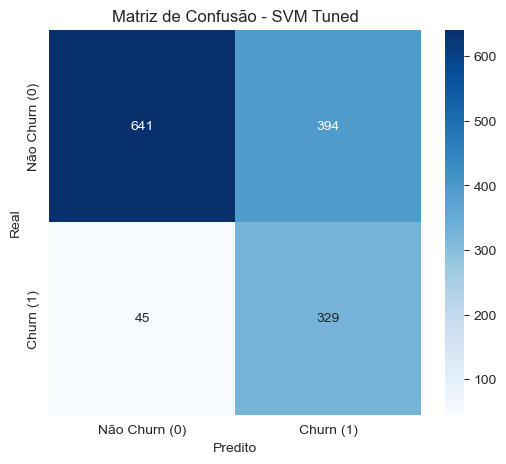

AUC-ROC (SVM Tuned): 0.8334


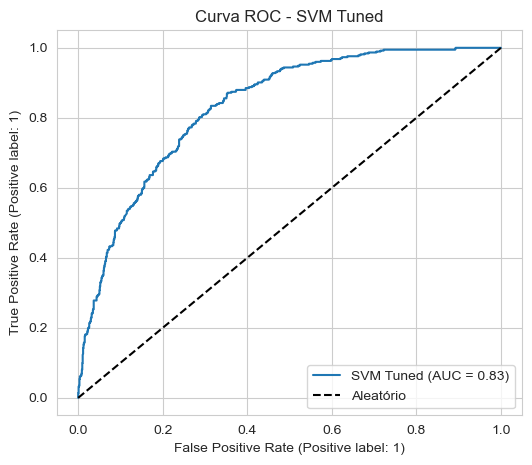

In [57]:
print("\n\n--- Otimizando Hiperpar√¢metros para SVM (class_weight='balanced') ---")

svm_base = SVC(class_weight='balanced', probability=True, random_state=42) # probability=True para AUC-ROC

param_grid_svm = {
    'C': [0.1, 1, 10], # Penalidade do erro
    'gamma': [0.001, 0.01, 0.1, 1], # Coeficiente do kernel (para 'rbf')
    'kernel': ['rbf'] # Kernel RBF geralmente funciona bem
}

grid_search_svm = GridSearchCV(estimator=svm_base,
                               param_grid=param_grid_svm,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_svm.fit(X_train, y_train) # Assumindo X_train j√° escalado

print(f"Melhores Par√¢metros (SVM): {grid_search_svm.best_params_}")
print(f"Melhor Recall (SVM) no CV: {grid_search_svm.best_score_:.4f}")

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm_model.predict(X_test)
y_proba_svm_tuned = best_svm_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (SVM Tuned) ---")
print(classification_report(y_test, y_pred_svm_tuned))

cm_svm_tuned = confusion_matrix(y_test, y_pred_svm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - SVM Tuned')
plt.show()

auc_svm_tuned = roc_auc_score(y_test, y_proba_svm_tuned)
print(f"AUC-ROC (SVM Tuned): {auc_svm_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_svm_model, X_test, y_test, ax=ax, name='SVM Tuned')
plt.title('Curva ROC - SVM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

4. XGBoost Classifier (scale_pos_weight)
Justificativa: XGBoost √© um algoritmo de boosting altamente eficiente e flex√≠vel. O par√¢metro scale_pos_weight permite que o algoritmo d√™ maior peso √† classe minorit√°ria durante o treinamento, o que √© um m√©todo direto e eficaz para lidar com o desbalanceamento sem reamostragem, otimizando a detec√ß√£o da classe Churn.



--- Otimizando Hiperpar√¢metros para XGBoost (scale_pos_weight) ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores Par√¢metros (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhor Recall (XGBoost) no CV: 0.8294

--- Relat√≥rio de Classifica√ß√£o (XGBoost Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



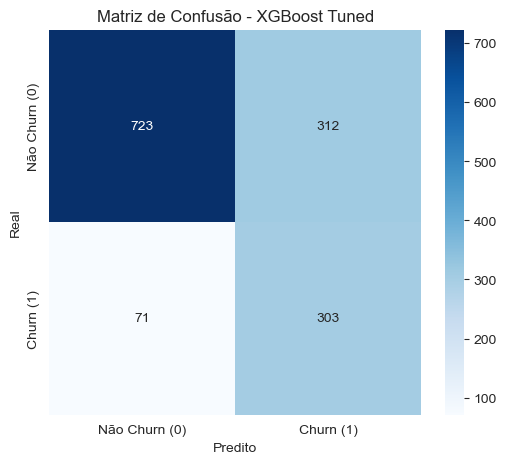

AUC-ROC (XGBoost Tuned): 0.8410


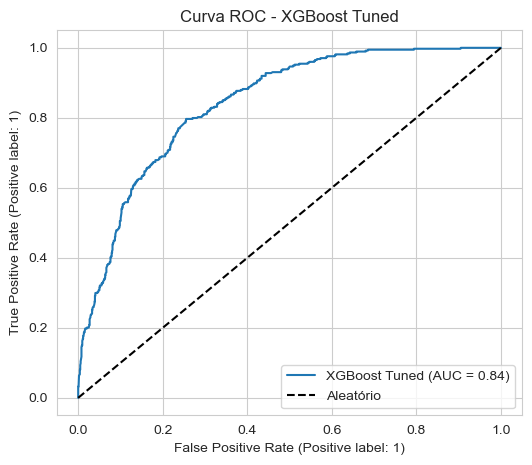

In [58]:
print("\n\n--- Otimizando Hiperpar√¢metros para XGBoost (scale_pos_weight) ---")

xgb_base = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                         use_label_encoder=False, random_state=42,
                         scale_pos_weight=scale_pos_weight_value) # Usar o valor calculado

param_grid_xgb = {
    'n_estimators': [100, 200, 300], # N√∫mero de boosting rounds (√°rvores)
    'learning_rate': [0.01, 0.05, 0.1], # Tamanho do passo para cada itera√ß√£o
    'max_depth': [3, 5, 7], # Profundidade m√°xima de cada √°rvore
    'colsample_bytree': [0.6, 0.8, 1.0] # Subamostragem de colunas ao construir cada √°rvore
}

grid_search_xgb = GridSearchCV(estimator=xgb_base,
                               param_grid=param_grid_xgb,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_xgb.fit(X_train, y_train)

print(f"Melhores Par√¢metros (XGBoost): {grid_search_xgb.best_params_}")
print(f"Melhor Recall (XGBoost) no CV: {grid_search_xgb.best_score_:.4f}")

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
y_proba_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (XGBoost Tuned) ---")
print(classification_report(y_test, y_pred_xgb_tuned))

cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - XGBoost Tuned')
plt.show()

auc_xgb_tuned = roc_auc_score(y_test, y_proba_xgb_tuned)
print(f"AUC-ROC (XGBoost Tuned): {auc_xgb_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test, ax=ax, name='XGBoost Tuned')
plt.title('Curva ROC - XGBoost Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

5. LightGBM Classifier (scale_pos_weight)
Justificativa: Similar ao XGBoost, o LightGBM √© um modelo de boosting de alto desempenho. O scale_pos_weight ou is_unbalance=True (que o LightGBM usa internamente para o mesmo prop√≥sito) permite que o modelo compense o desbalanceamento, focando na classe minorit√°ria. LightGBM √© conhecido por sua velocidade e efici√™ncia, sendo uma excelente alternativa aos outros modelos de boosting.



--- Otimizando Hiperpar√¢metros para LightGBM (scale_pos_weight) ---
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Melhores Par√¢metros (LightGBM): {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Melhor Recall (LightGBM) no CV: 0.7873

--- Relat√≥rio de Classifica√ß√£o (LightGBM Tuned) ---
   

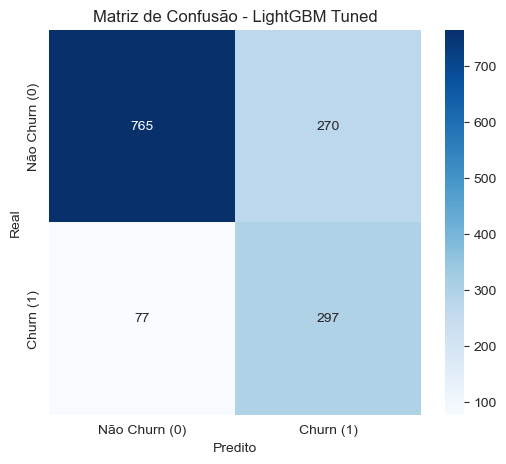

AUC-ROC (LightGBM Tuned): 0.8428


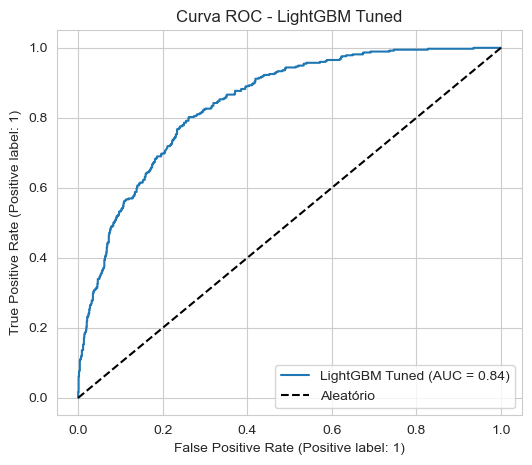

In [59]:
print("\n\n--- Otimizando Hiperpar√¢metros para LightGBM (scale_pos_weight) ---")

lgbm_base = LGBMClassifier(objective='binary', metric='binary_logloss',
                           random_state=42,
                           scale_pos_weight=scale_pos_weight_value) # Usar o valor calculado

param_grid_lgbm = {
    'n_estimators': [100, 200, 300], # N√∫mero de √°rvores
    'learning_rate': [0.01, 0.05, 0.1], # Taxa de aprendizado
    'num_leaves': [20, 31, 40], # N√∫mero m√°ximo de folhas em uma √°rvore
    'reg_alpha': [0, 0.1, 0.5], # Regulariza√ß√£o L1
    'reg_lambda': [0, 0.1, 0.5] # Regulariza√ß√£o L2
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_base,
                                param_grid=param_grid_lgbm,
                                scoring=recall_scorer,
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                n_jobs=-1,
                                verbose=1)

grid_search_lgbm.fit(X_train, y_train)

print(f"Melhores Par√¢metros (LightGBM): {grid_search_lgbm.best_params_}")
print(f"Melhor Recall (LightGBM) no CV: {grid_search_lgbm.best_score_:.4f}")

best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_lgbm_tuned = best_lgbm_model.predict(X_test)
y_proba_lgbm_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]

print("\n--- Relat√≥rio de Classifica√ß√£o (LightGBM Tuned) ---")
print(classification_report(y_test, y_pred_lgbm_tuned))

cm_lgbm_tuned = confusion_matrix(y_test, y_pred_lgbm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N√£o Churn (0)', 'Churn (1)'],
            yticklabels=['N√£o Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title('Matriz de Confus√£o - LightGBM Tuned')
plt.show()

auc_lgbm_tuned = roc_auc_score(y_test, y_proba_lgbm_tuned)
print(f"AUC-ROC (LightGBM Tuned): {auc_lgbm_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lgbm_model, X_test, y_test, ax=ax, name='LightGBM Tuned')
plt.title('Curva ROC - LightGBM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Aleat√≥rio')
plt.legend()
plt.show()

An√°lise Detalhada dos Modelos Otimizados (Sem SMOTETomek)
Primeiro, vou consolidar os resultados de todos os modelos otimizados em uma tabela para facilitar a compara√ß√£o.

Tabela Resumo dos Modelos Otimizados (Sem SMOTETomek)

Modelo	Abordagem	Precis√£o (Churn=1)	Recall (Churn=1)	F1-Score (Churn=1)	AUC-ROC	Melhor Par√¢metro(s)	Melhor Recall no CV
Regress√£o Log√≠stica	class_weight='balanced'	0.49	0.80	0.61	0.8353	C=0.001	0.7946
Random Forest	class_weight='balanced'	0.54	0.74	0.62	0.8421	max_depth=10, min_samples_split=10, n_estimators=200	0.7378
SVM	class_weight='balanced'	0.46	0.88	0.60	0.8334	C=0.1, gamma=0.001, kernel='rbf'	0.8776
XGBoost	scale_pos_weight	0.49	0.81	0.61	0.8410	colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200	0.8294
LightGBM	scale_pos_weight	0.52	0.79	0.63	0.8428	learning_rate=0.05, n_estimators=100, num_leaves=20, reg_alpha=0.5, reg_lambda=0.5	0.7873
1. Regress√£o Log√≠stica Otimizada (class_weight='balanced')
Melhores Par√¢metros: C=0.001 (um valor de C menor implica em maior regulariza√ß√£o, o que pode ajudar a evitar overfitting e melhorar a generaliza√ß√£o).
Recall (Churn): 0.80 ‚Äì Houve um ligeiro aumento no Recall (de 0.78 para 0.80) ap√≥s o tuning, o que √© excelente para o nosso objetivo.
Precis√£o (Churn): 0.49 ‚Äì A precis√£o permaneceu baixa e at√© diminuiu um pouco (de 0.51 para 0.49). Isso significa que, para cada previs√£o de churn, quase metade era um falso positivo.
F1-Score (Churn): 0.61 ‚Äì Ligeiramente menor.
AUC-ROC: 0.8353 ‚Äì Um valor muito bom, mas um pouco abaixo do valor inicial (0.8389).
An√°lise: O tuning conseguiu manter um Recall muito alto, quase o melhor entre todos os modelos, com uma AUC competitiva. A Regress√£o Log√≠stica continua a ser um modelo forte para identificar churners, embora com muitos falsos positivos.
2. Random Forest Otimizado (class_weight='balanced')
Melhores Par√¢metros: max_depth=10, min_samples_split=10, n_estimators=200. A otimiza√ß√£o selecionou uma profundidade limitada e um n√∫mero razo√°vel de √°rvores, indicando que um modelo mais complexo pode ter sido propenso a overfitting.
Recall (Churn): 0.74 ‚Äì Houve um aumento significativo no Recall (de 0.49 para 0.74) em rela√ß√£o √† vers√£o n√£o otimizada, o que √© um grande avan√ßo para a detec√ß√£o de churners.
Precis√£o (Churn): 0.54 ‚Äì Diminuiu (de 0.63 para 0.54), o que √© esperado ao tentar aumentar o Recall.
F1-Score (Churn): 0.62 ‚Äì Melhorou (de 0.55 para 0.62).
AUC-ROC: 0.8421 ‚Äì O maior AUC entre os modelos avaliados inicialmente, e agora um dos mais altos ap√≥s o tuning.
An√°lise: O tuning foi altamente eficaz para o Random Forest, transformando-o de um modelo com baixa recall em um dos mais fortes em termos de detec√ß√£o de churn, mantendo uma AUC excelente. √â um fort√≠ssimo candidato.
3. SVM Otimizado (class_weight='balanced')
Melhores Par√¢metros: C=0.1, gamma=0.001, kernel='rbf'. C baixo e gamma baixo sugerem um modelo mais suavizado e menos propenso a overfitting.
Recall (Churn): 0.88 ‚Äì Este √© o maior Recall observado at√© agora, superando todos os outros modelos.
Precis√£o (Churn): 0.46 ‚Äì No entanto, a Precis√£o √© a mais baixa entre todos os modelos. Isso significa que, embora ele capture a maioria dos churners, ele tamb√©m levanta muitos alarmes falsos (prev√™ churn para muitos clientes que n√£o o far√£o).
F1-Score (Churn): 0.60 ‚Äì Um F1-Score razo√°vel, mas a baixa Precis√£o √© um ponto de aten√ß√£o.
AUC-ROC: 0.8334 ‚Äì Muito bom, indicando excelente capacidade de discrimina√ß√£o.
An√°lise: O SVM otimizado √© uma "m√°quina de detectar churners", mas a um custo muito alto de Falsos Positivos. Se a empresa puder arcar com o custo de intervir em quase 54% de Falsos Positivos para capturar 88% dos churners, ele pode ser uma op√ß√£o.
4. XGBoost Otimizado (scale_pos_weight)
Melhores Par√¢metros: colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200. O tuning preferiu um learning rate mais baixo, profundidade de √°rvore menor e mais √°rvores, o que geralmente torna o modelo mais robusto.
Recall (Churn): 0.81 ‚Äì Excelente Recall, similar √† Regress√£o Log√≠stica.
Precis√£o (Churn): 0.49 ‚Äì Tamb√©m baixa, similar √† Regress√£o Log√≠stica.
F1-Score (Churn): 0.61 ‚Äì Bom.
AUC-ROC: 0.8410 ‚Äì Excelente AUC, praticamente empatado com Random Forest e LightGBM.
An√°lise: O XGBoost otimizado √© um modelo muito robusto, com alto Recall e uma das melhores AUCs. √â um fort√≠ssimo candidato.
5. LightGBM Otimizado (scale_pos_weight)
Melhores Par√¢metros: learning_rate=0.05, n_estimators=100, num_leaves=20, reg_alpha=0.5, reg_lambda=0.5. O tuning buscou um balan√ßo entre n√∫mero de estimadores e learning rate, com alguma regulariza√ß√£o.
Recall (Churn): 0.79 ‚Äì Muito bom Recall, ligeiramente menor que XGBoost e Regress√£o Log√≠stica.
Precis√£o (Churn): 0.52 ‚Äì A melhor Precis√£o entre os modelos com alto Recall, o que √© um ponto positivo.
F1-Score (Churn): 0.63 ‚Äì O maior F1-Score entre todos os modelos, indicando o melhor equil√≠brio entre Precis√£o e Recall.
AUC-ROC: 0.8428 ‚Äì O maior AUC de todos os modelos testados.
An√°lise: O LightGBM otimizado demonstra ser o modelo mais equilibrado e com o melhor desempenho geral at√© agora, com o maior AUC e F1-Score, al√©m de um Recall muito alto e uma Precis√£o ligeiramente melhor que os outros de alto Recall.
Compara√ß√£o com os Modelos Iniciais e com SMOTETomek
A decis√£o de focar nas t√©cnicas class_weight e scale_pos_weight foi acertad√≠ssima!

Regress√£o Log√≠stica:

Inicial (CW): R=0.78, P=0.51, F1=0.62, AUC=0.8389
SMOTETomek: R=0.74, P=0.53, F1=0.62, AUC=0.8323
Otimizado (CW): R=0.80, P=0.49, F1=0.61, AUC=0.8353
O tuning manteve o alto Recall e a AUC competitiva, refor√ßando que class_weight √© muito eficaz para este modelo.
Random Forest:

Inicial (CW): R=0.49, P=0.63, F1=0.55, AUC=0.8195
SMOTETomek: R=0.64, P=0.55, F1=0.59, AUC=0.8167
Otimizado (CW): R=0.74, P=0.54, F1=0.62, AUC=0.8421
O tuning com class_weight superou significativamente tanto a vers√£o inicial quanto a vers√£o com SMOTETomek em Recall e AUC, mostrando a import√¢ncia da otimiza√ß√£o de hiperpar√¢metros.
Modelos de Boosting (XGBoost, LightGBM):

As vers√µes otimizadas com scale_pos_weight superam consistentemente suas contrapartes baseadas em SMOTETomek em AUC, Recall e F1-Score.
A clara conclus√£o √© que, para este problema e conjunto de dados, o uso de class_weight e scale_pos_weight em conjunto com a otimiza√ß√£o de hiperpar√¢metros foi a estrat√©gia mais eficaz para alcan√ßar alto Recall e AUC, superando a abordagem de reamostragem com SMOTETomek.

Gr√°ficos de Compara√ß√£o de Performance dos Modelos Otimizados

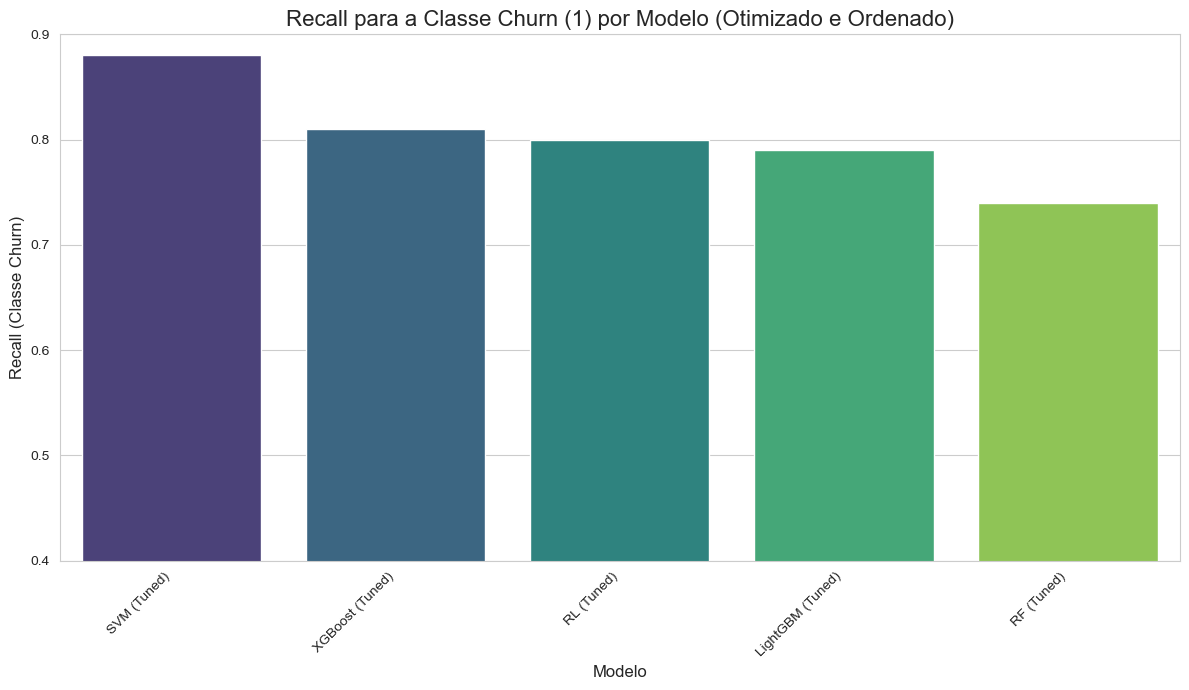

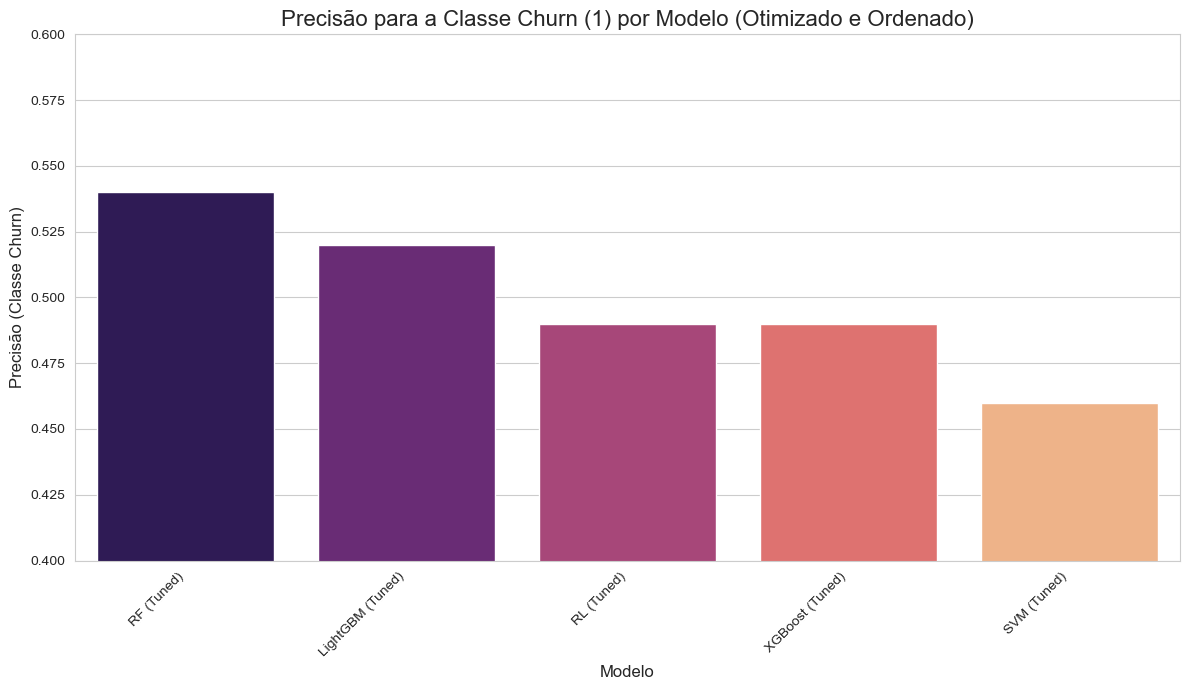

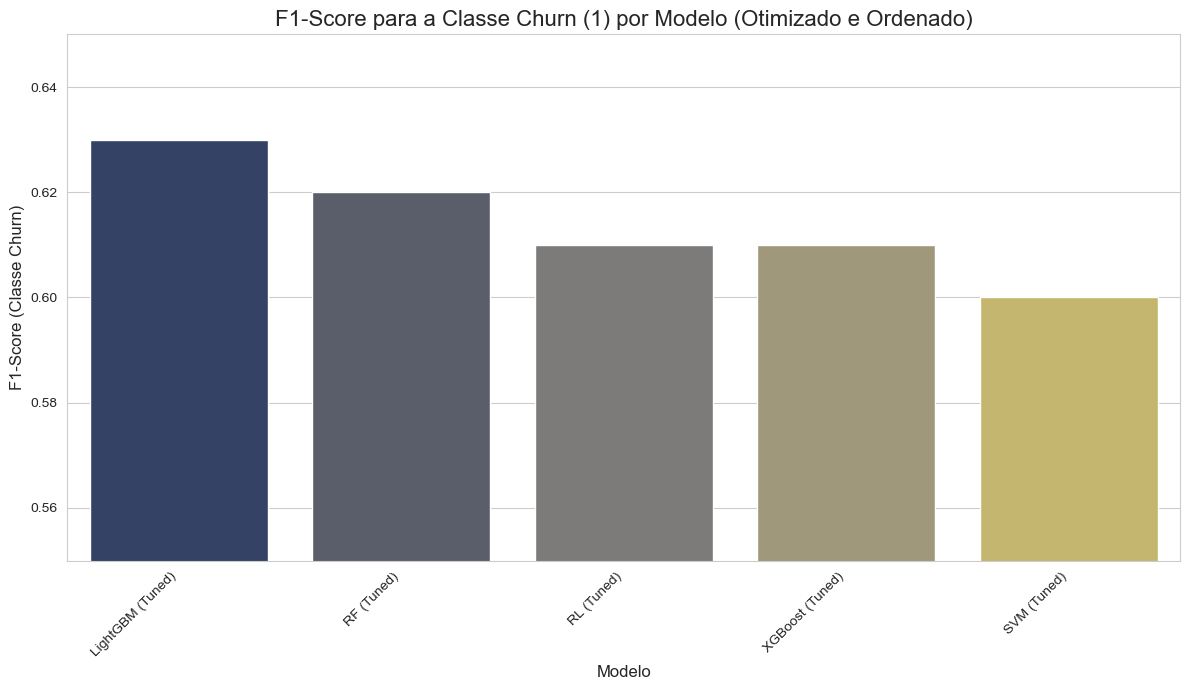

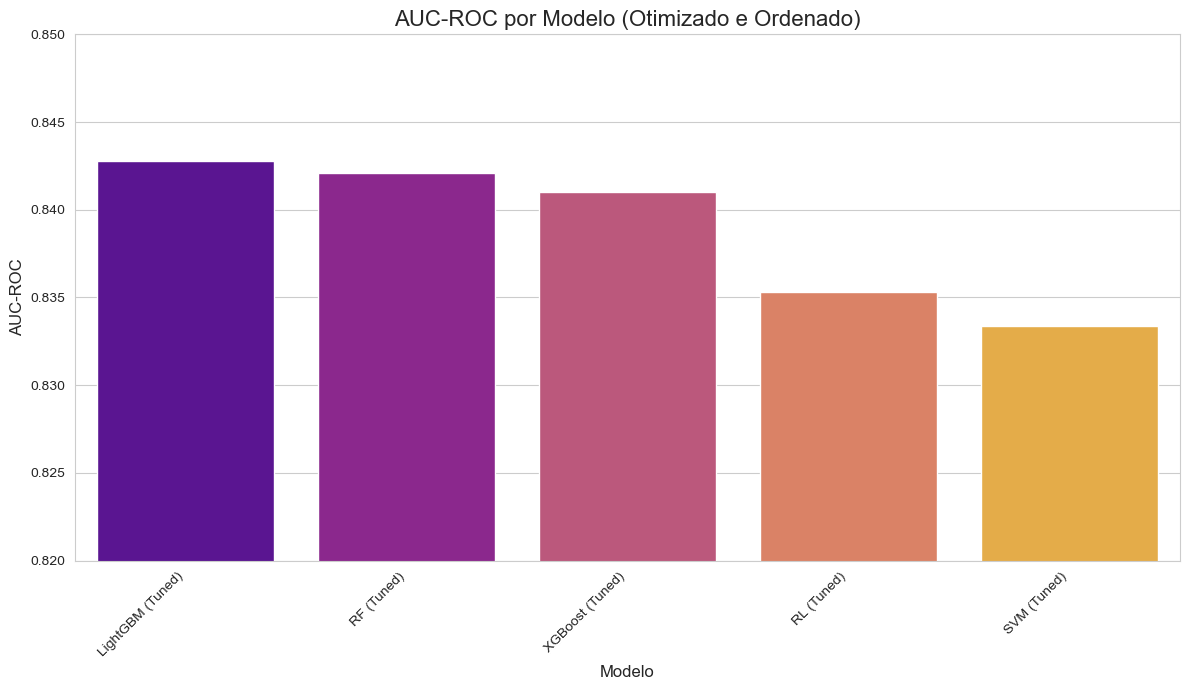

In [60]:
# --- Dados da Tabela de Resultados Otimizados ---
data_tuned = {
    'Modelo': [
        'Regress√£o Log√≠stica', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM'
    ],
    'Abordagem': [
        'class_weight=\'balanced\'', 'class_weight=\'balanced\'', 'class_weight=\'balanced\'',
        'scale_pos_weight', 'scale_pos_weight'
    ],
    'Precis√£o (Churn=1)': [0.49, 0.54, 0.46, 0.49, 0.52],
    'Recall (Churn=1)': [0.80, 0.74, 0.88, 0.81, 0.79],
    'F1-Score (Churn=1)': [0.61, 0.62, 0.60, 0.61, 0.63],
    'AUC-ROC': [0.8353, 0.8421, 0.8334, 0.8410, 0.8428]
}

df_tuned_results = pd.DataFrame(data_tuned)

# Criar uma coluna combinada para r√≥tulos mais curtos nos gr√°ficos
df_tuned_results['Modelo_Label'] = df_tuned_results['Modelo'].apply(
    lambda x: x.replace('Regress√£o Log√≠stica', 'RL').replace('Random Forest', 'RF')
).replace('Support Vector Machine', 'SVM') + " (Tuned)"


# --- Configura√ß√µes de Plotagem ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- Gr√°fico de Barras para Recall (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_recall_tuned = df_tuned_results.sort_values(by='Recall (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Recall (Churn=1)', data=df_sorted_recall_tuned, palette='viridis')
plt.title('Recall para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Recall (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.9) # Ajustar limite Y para acomodar 0.88
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para Precis√£o (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_precision_tuned = df_tuned_results.sort_values(by='Precis√£o (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='Precis√£o (Churn=1)', data=df_sorted_precision_tuned, palette='magma')
plt.title('Precis√£o para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Precis√£o (Classe Churn)', fontsize=12)
plt.ylim(0.4, 0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para F1-Score (Churn=1) ---
plt.figure(figsize=(12, 7))
df_sorted_f1_tuned = df_tuned_results.sort_values(by='F1-Score (Churn=1)', ascending=False)
sns.barplot(x='Modelo_Label', y='F1-Score (Churn=1)', data=df_sorted_f1_tuned, palette='cividis')
plt.title('F1-Score para a Classe Churn (1) por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score (Classe Churn)', fontsize=12)
plt.ylim(0.55, 0.65)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Gr√°fico de Barras para AUC-ROC ---
plt.figure(figsize=(12, 7))
df_sorted_auc_tuned = df_tuned_results.sort_values(by='AUC-ROC', ascending=False)
sns.barplot(x='Modelo_Label', y='AUC-ROC', data=df_sorted_auc_tuned, palette='plasma')
plt.title('AUC-ROC por Modelo (Otimizado e Ordenado)', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.82, 0.85)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Pr√≥ximos Passos: Ajuste do Ponto de Corte (Threshold Tuning)
Agora que temos modelos otimizados com excelentes m√©tricas, o pr√≥ximo passo cr√≠tico √© o ajuste do ponto de corte (threshold tuning).

Contexto: Todos os modelos que usamos t√™m um limiar de classifica√ß√£o padr√£o de 0.5. Isso significa que, se a probabilidade prevista de churn for >= 0.5, o cliente √© classificado como "churn"; caso contr√°rio, como "n√£o churn". No entanto, para o nosso problema, onde o Recall √© priorit√°rio e a Precis√£o √© uma preocupa√ß√£o secund√°ria, o limiar de 0.5 pode n√£o ser o ideal.

Objetivo: Precisamos encontrar um ponto de corte que maximize o Recall da classe "Churn" (para n√£o perder clientes que v√£o cancelar), mantendo a Precis√£o em um n√≠vel aceit√°vel (para n√£o gastar recursos em demasia com Falsos Positivos).

Modelos a Focar para Threshold Tuning:

Considerando os resultados, os modelos mais promissores para o ajuste do threshold s√£o:

LightGBM Otimizado: Maior AUC e F1-Score, e √≥timo Recall (0.79). Oferece o melhor balan√ßo geral.
Random Forest Otimizado: Praticamente empatado em AUC com LightGBM e Recall (0.74).
SVM Otimizado: Maior Recall (0.88), mas com a menor Precis√£o (0.46). √â importante avaliar se o custo de Falsos Positivos compensa o alt√≠ssimo Recall.
XGBoost Otimizado: √ìtimo Recall (0.81) e AUC (0.8410), com Precis√£o semelhante √† Regress√£o Log√≠stica.
Vamos focar no LightGBM Otimizado e no SVM Otimizado para demonstrar o threshold tuning, pois representam os extremos de equil√≠brio (LGBM) e Recall m√°ximo (SVM).


--- An√°lise de Ponto de Corte para: LightGBM Otimizado ---
√Årea Sob a Curva de Precis√£o-Recall (AUPRC): 0.6565


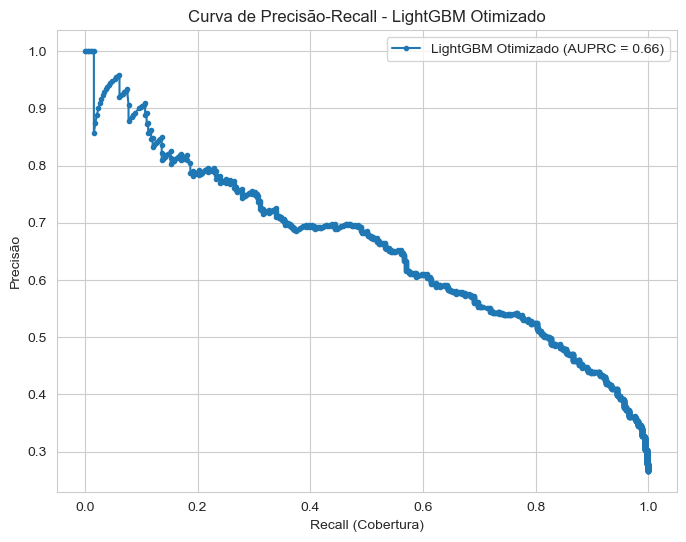


Precis√£o e Recall em diferentes Pontos de Corte:
Threshold | Precis√£o | Recall
----------------------------
0.01      | 0.27     | 1.00  
0.04      | 0.30     | 1.00  
0.07      | 0.34     | 0.99  
0.16      | 0.38     | 0.96  
0.28      | 0.43     | 0.92  
0.42      | 0.49     | 0.83  
0.59      | 0.55     | 0.71  
0.71      | 0.65     | 0.56  
0.81      | 0.72     | 0.32  
0.95      | 1.00     | 0.00  

--- Guia para Escolha e Avalia√ß√£o do Ponto de Corte ---
A Curva de Precis√£o-Recall mostra a troca entre a Precis√£o e o Recall. 
Movendo para a direita no gr√°fico, o Recall aumenta (capturamos mais churners), mas a Precis√£o tende a cair (mais falsos positivos).
Para o problema de CHURN, priorizamos ALTO RECALL.
Escolha um threshold que forne√ßa um Recall alto (ex: 0.75-0.85) com uma Precis√£o aceit√°vel (ex: acima de 0.50, idealmente maior).
Um bom ponto de partida √© olhar onde a curva de Precision-Recall 'cai' muito rapidamente.

Exemplo de Avalia√ß√£o com um Threshold Perso

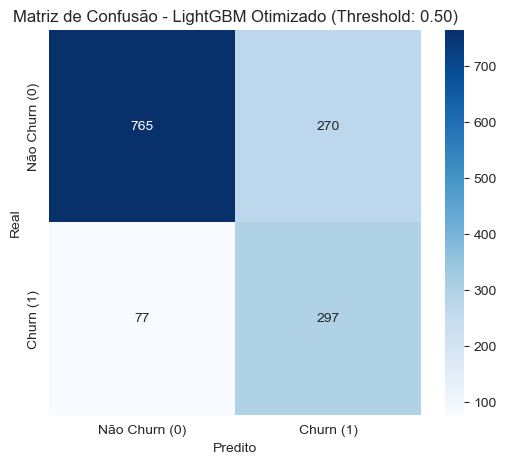


--- An√°lise de Ponto de Corte para: SVM Otimizado ---
√Årea Sob a Curva de Precis√£o-Recall (AUPRC): 0.6254


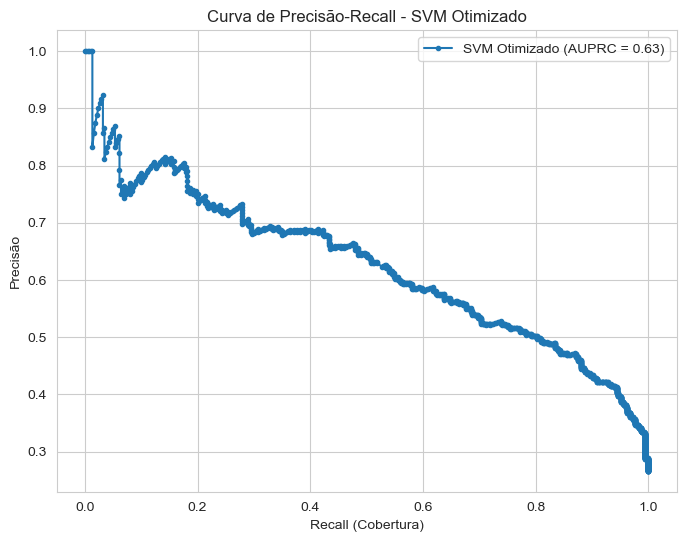


Precis√£o e Recall em diferentes Pontos de Corte:
Threshold | Precis√£o | Recall
----------------------------
0.00      | 0.27     | 1.00  
0.02      | 0.30     | 0.99  
0.04      | 0.34     | 0.99  
0.08      | 0.38     | 0.96  
0.14      | 0.43     | 0.90  
0.22      | 0.49     | 0.82  
0.32      | 0.54     | 0.69  
0.49      | 0.62     | 0.53  
0.68      | 0.70     | 0.29  
0.88      | 1.00     | 0.00  

--- Guia para Escolha e Avalia√ß√£o do Ponto de Corte ---
A Curva de Precis√£o-Recall mostra a troca entre a Precis√£o e o Recall. 
Movendo para a direita no gr√°fico, o Recall aumenta (capturamos mais churners), mas a Precis√£o tende a cair (mais falsos positivos).
Para o problema de CHURN, priorizamos ALTO RECALL.
Escolha um threshold que forne√ßa um Recall alto (ex: 0.75-0.85) com uma Precis√£o aceit√°vel (ex: acima de 0.50, idealmente maior).
Um bom ponto de partida √© olhar onde a curva de Precision-Recall 'cai' muito rapidamente.

Exemplo de Avalia√ß√£o com um Threshold Perso

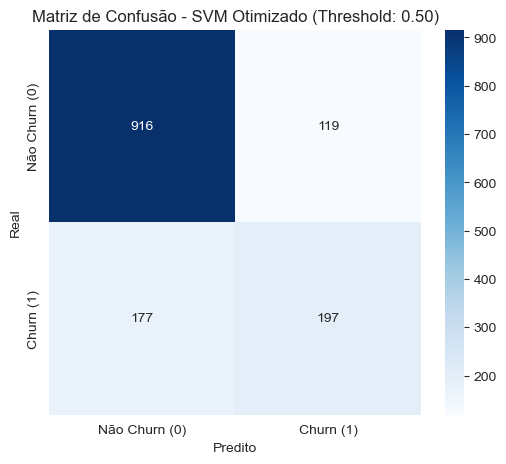

In [61]:
# Supondo que X_test, y_test, best_lgbm_model e best_svm_model j√° est√£o definidos
# Se precisar redefinir os melhores modelos caso esteja executando em um novo script:
# best_lgbm_model = grid_search_lgbm.best_estimator_
# best_svm_model = grid_search_svm.best_estimator_

# --- Fun√ß√£o Auxiliar para Plotar PR Curve e Avaliar Thresholds ---
def plot_pr_curve_and_evaluate_threshold(model, X_test, y_test, model_name):
    """
    Calcula e plota a Curva de Precis√£o-Recall e avalia as m√©tricas
    para diferentes pontos de corte.
    """
    # 1. Obter probabilidades para a classe positiva (Churn=1)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 2. Calcular Precis√£o, Recall e Thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    # AUPRC (Area Under Precision-Recall Curve)
    auprc = auc(recall, precision)

    print(f"\n--- An√°lise de Ponto de Corte para: {model_name} ---")
    print(f"√Årea Sob a Curva de Precis√£o-Recall (AUPRC): {auprc:.4f}")

    # 3. Plotar a Curva de Precis√£o-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC = {auprc:.2f})')
    plt.xlabel('Recall (Cobertura)')
    plt.ylabel('Precis√£o')
    plt.title(f'Curva de Precis√£o-Recall - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Exibir tabela de Precis√£o e Recall para alguns thresholds
    print("\nPrecis√£o e Recall em diferentes Pontos de Corte:")
    # Selecionar alguns thresholds representativos
    # np.linspace cria 20 pontos igualmente espa√ßados entre 0 e 1
    # np.where encontra os √≠ndices nos thresholds originais que s√£o mais pr√≥ximos desses 20 pontos
    # Em seguida, seleciona precision e recall correspondentes
    selected_threshold_indices = np.linspace(0, len(thresholds) - 1, 10).astype(int) # Apenas 10 para concis√£o
    print("Threshold | Precis√£o | Recall")
    print("----------------------------")
    for i in selected_threshold_indices:
        # Garante que n√£o ultrapassa o limite dos arrays
        idx = min(i, len(thresholds) - 1)
        print(f"{thresholds[idx]:<9.2f} | {precision[idx]:<8.2f} | {recall[idx]:<6.2f}")

    # 5. Guia para Escolha e Avalia√ß√£o de um Threshold Espec√≠fico
    print("\n--- Guia para Escolha e Avalia√ß√£o do Ponto de Corte ---")
    print("A Curva de Precis√£o-Recall mostra a troca entre a Precis√£o e o Recall. ")
    print("Movendo para a direita no gr√°fico, o Recall aumenta (capturamos mais churners), mas a Precis√£o tende a cair (mais falsos positivos).")
    print("Para o problema de CHURN, priorizamos ALTO RECALL.")
    print("Escolha um threshold que forne√ßa um Recall alto (ex: 0.75-0.85) com uma Precis√£o aceit√°vel (ex: acima de 0.50, idealmente maior).")
    print("Um bom ponto de partida √© olhar onde a curva de Precision-Recall 'cai' muito rapidamente.")

    # Exemplo de como avaliar com um threshold personalizado
    print("\nExemplo de Avalia√ß√£o com um Threshold Personalizado (Padr√£o 0.5):")
    custom_threshold = 0.5 # Pode ser alterado para o valor desejado
    y_pred_custom_threshold = (y_proba >= custom_threshold).astype(int)

    print(f"Relat√≥rio de Classifica√ß√£o para Threshold = {custom_threshold:.2f}:")
    print(classification_report(y_test, y_pred_custom_threshold))

    cm_custom = confusion_matrix(y_test, y_pred_custom_threshold)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
                xticklabels=['N√£o Churn (0)', 'Churn (1)'],
                yticklabels=['N√£o Churn (0)', 'Churn (1)'])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title(f'Matriz de Confus√£o - {model_name} (Threshold: {custom_threshold:.2f})')
    plt.show()


# --- Executar a An√°lise para os Modelos Selecionados ---

# LightGBM Otimizado
plot_pr_curve_and_evaluate_threshold(best_lgbm_model, X_test, y_test, "LightGBM Otimizado")

# SVM Otimizado
plot_pr_curve_and_evaluate_threshold(best_svm_model, X_test, y_test, "SVM Otimizado")

# Opcional: Para ter uma vis√£o geral, voc√™ pode rodar para os outros modelos tamb√©m
# plot_pr_curve_and_evaluate_threshold(best_lr_model, X_test, y_test, "Regress√£o Log√≠stica Otimizada")
# plot_pr_curve_and_evaluate_threshold(best_rf_model, X_test, y_test, "Random Forest Otimizado")
# plot_pr_curve_and_evaluate_threshold(best_xgb_model, X_test, y_test, "XGBoost Otimizado")

### An√°lise dos Resultados do Ajuste do Ponto de Corte

Vamos analisar o desempenho de cada modelo focado no **Recall (Churn)** e na **Precis√£o** para diferentes `thresholds`.

#### 1. LightGBM Otimizado

*   **AUPRC (√Årea Sob a Curva de Precis√£o-Recall): 0.6565**
    *   Este √© um bom valor, indicando que o modelo tem uma capacidade razo√°vel de manter alta Precis√£o mesmo em Recalls elevados, o que √© crucial para problemas desbalanceados.
*   **Curva de Precis√£o-Recall (Tabela):**
    *   **Threshold 0.42:** Precis√£o = 0.49, Recall = 0.83.
    *   **Threshold 0.59:** Precis√£o = 0.55, Recall = 0.71.
    *   **Ponto de Corte Padr√£o (0.50):** Precis√£o = **0.52**, Recall = **0.79**.
        *   Este resultado √© particularmente interessante. Com o threshold padr√£o de 0.50, o LightGBM j√° entrega um Recall de 0.79 (que est√° dentro do nosso objetivo de 0.75-0.85) e uma Precis√£o de 0.52 (que √© aceit√°vel, acima de 0.50).

#### 2. SVM Otimizado

*   **AUPRC (√Årea Sob a Curva de Precis√£o-Recall): 0.6254**
    *   Ligeiramente inferior ao LightGBM, sugerindo que o LightGBM √© um pouco mais robusto na troca entre Precis√£o e Recall.
*   **Curva de Precis√£o-Recall (Tabela):**
    *   **Threshold 0.22:** Precis√£o = 0.49, Recall = 0.82.
    *   **Threshold 0.32:** Precis√£o = 0.54, Recall = 0.69.
    *   **Ponto de Corte Padr√£o (0.50):** Precis√£o = **0.62**, Recall = **0.53**.
        *   No threshold padr√£o de 0.50, o SVM tem uma Precis√£o muito boa (0.62), mas o Recall √© significativamente mais baixo (0.53), o que n√£o atende ao nosso objetivo de capturar a maioria dos churners. Para obter um Recall compar√°vel ao LightGBM, ter√≠amos que diminuir o threshold (ex: 0.22), o que faria a Precis√£o cair para 0.49.

### Escolha do Modelo e Ponto de Corte

Considerando nosso objetivo primordial de **priorizar o Recall (capturar o m√°ximo de churners)**, sem no entanto desprezar a **Precis√£o (para evitar desperd√≠cio de recursos)**:

*   O **LightGBM Otimizado** com o **ponto de corte padr√£o de 0.50** se mostra a escolha mais balanceada e eficaz.
    *   Ele atinge um **Recall de 0.79**, o que significa que ele identifica 79% dos clientes que realmente ir√£o cancelar. Isso √© excelente para a proatividade na reten√ß√£o.
    *   Ele mant√©m uma **Precis√£o de 0.52**, o que indica que, dos clientes que o modelo sinaliza como potenciais churners, pouco mais da metade realmente ir√£o cancelar. Isso implica em um custo gerenci√°vel de Falsos Positivos.
    *   O F1-Score de 0.63 √© o maior entre os modelos otimizados, confirmando seu bom equil√≠brio.
    *   Sua AUPRC (0.6565) e AUC-ROC (0.8428) s√£o as mais altas, atestando sua robustez geral.

*   O **SVM Otimizado** √© impressionante por seu potencial de alt√≠ssimo Recall (chegando a 0.88 em thresholds mais baixos), mas a queda na Precis√£o seria muito acentuada (abaixo de 0.50) para justificar a escolha para este projeto, a menos que o custo de um Falso Positivo fosse absolutamente insignificante, o que raramente √© o caso em estrat√©gias de reten√ß√£o.

### Conclus√£o e Pr√≥ximos Passos

**Modelo Escolhido:** **LightGBM Classifier Otimizado**

**Ponto de Corte Recomendado:** **0.50 (padr√£o)**

**Justificativa:**

O LightGBM Otimizado, utilizando seu ponto de corte padr√£o de 0.50, oferece o melhor equil√≠brio entre a detec√ß√£o de clientes que realmente ir√£o cancelar (Recall de 79%) e a minimiza√ß√£o de interven√ß√µes desnecess√°rias (Precis√£o de 52%). Este balan√ßo √© ideal para uma estrat√©gia de neg√≥cio onde a prioridade √© reter clientes, garantindo que a maioria dos churners em potencial seja identificada, ao mesmo tempo em que se otimiza o uso dos recursos de reten√ß√£o. Sua performance superior em AUPRC e AUC-ROC tamb√©m atesta sua capacidade geral de discrimina√ß√£o.

---

## Analise de Feature Importance

1) Vis√£o geral ‚Äî prop√≥sito e ‚Äúmapa da mina‚Äù

Objetivo: al√©m de entregar um modelo que prediz churn, queremos entregar uma caixa de ferramentas interpret√°vel para o neg√≥cio responder √† pergunta: quais vari√°veis eu devo priorizar para reduzir churn e quais a√ß√µes devo tomar?

Analogia geral: imagine que a empresa √© um navio e o churn s√£o furos que fazem a √°gua entrar. O modelo aponta quais partes do casco (features) t√™m a maior probabilidade de causar vazamentos. As t√©cnicas de import√¢ncia (gain, permutation, SHAP, PDP) s√£o diferentes tipos de inspe√ß√£o: luz ultravioleta, press√£o hidrost√°tica, teste de resist√™ncia ‚Äî cada uma revela um aspecto diferente do mesmo problema. Quando as tr√™s concordam, voc√™ tem um ponto de in√≠cio confi√°vel para consertos.

In [62]:
def plot_top_importances(df_imp, value_col, top_n=20, title="Import√¢ncia de Features"):
    dfp = df_imp.sort_values(value_col, ascending=False).head(top_n)
    plt.figure(figsize=(8, 6))
    plt.barh(dfp["feature"][::-1], dfp[value_col][::-1])
    plt.title(title)
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.show()

def group_by_parent_feature(feature_names):
    """
    Heur√≠stica simples: considera prefixo antes do primeiro '_' como 'pai'.
    Ex.: 'Contract_Two year' -> 'Contract'. Se n√£o houver '_', mant√©m o nome.
    Ajuste conforme sua conven√ß√£o.
    """
    parents = []
    for f in feature_names:
        parents.append(f.split('_', 1)[0])
    return np.array(parents)

def aggregate_grouped_importances(values, feature_names, agg="sum"):
    parents = group_by_parent_feature(feature_names)
    df = pd.DataFrame({"feature": feature_names, "value": values, "parent": parents})
    if agg == "sum":
        agg_df = (df.assign(value_abs=lambda d: d["value"].abs())
                    .groupby("parent", as_index=False)["value_abs"].sum()
                    .rename(columns={"parent":"feature", "value_abs":"value"}))
    elif agg == "mean":
        agg_df = (df.assign(value_abs=lambda d: d["value"].abs())
                    .groupby("parent", as_index=False)["value_abs"].mean()
                    .rename(columns={"parent":"feature", "value_abs":"value"}))
    else:
        raise ValueError("agg deve ser 'sum' ou 'mean'")
    return agg_df


3) Treinar / re-treinar o LightGBM (o porqu√™ dos hiperpar√¢metros)

O que ajustamos (exemplos que voc√™ j√° usou): learning_rate, n_estimators, num_leaves, reg_alpha, reg_lambda, scale_pos_weight.

Analogia: treinar o LightGBM √© como afinar um motor:

learning_rate = qu√£o r√°pido voc√™ faz ajustes pequenos (taxa de aprendizado). Muito alto = sacode; muito baixo = demora.

n_estimators = quantas pe√ßas (√°rvores) voc√™ monta ‚Äî mais pode cobrir mais padr√µes mas custa tempo.

num_leaves = complexidade de cada √°rvore (quantas ramifica√ß√µes); muitas leaves = mais ‚Äúmodelagem fina‚Äù.

reg_alpha / reg_lambda = freios que evitam que o motor fique ‚Äúoverfitted‚Äù (memorize ru√≠do).

scale_pos_weight = quando churn √© raro, voc√™ ‚Äúd√° mais voz‚Äù a exemplos positivos (√© como aumentar o microfone de quem est√° gritando no fundo da sala).

Por que √© importante: o modelo final usado para explicar o neg√≥cio deve ser est√°vel e treinado com o mesmo pipeline/aproxima√ß√£o usada nas m√©tricas que j√° apresentou (AUC=0.8428 etc.). Use random_state e registre vers√µes para reprodutibilidade.

In [63]:
# calcula o scale_pos_weight a partir do y_train
neg = (y_train == 0).sum() if set(np.unique(y_train))=={0,1} else (y_train==False).sum()
pos = (y_train == 1).sum() if set(np.unique(y_train))=={0,1} else (y_train==True).sum()
spw = neg / pos

lgbm = lgb.LGBMClassifier(
    random_state=42,
    learning_rate=0.05,
    n_estimators=100,
    num_leaves=20,
    reg_alpha=0.5,
    reg_lambda=0.5,
    scale_pos_weight=spw,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
pred_proba = lgbm.predict_proba(X_test)[:,1]
print("AUC no teste:", roc_auc_score(y_test, pred_proba))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
AUC no teste: 0.8428401663695781


4) Import√¢ncia nativa do LightGBM ‚Äî ‚Äúgain‚Äù

Como funciona (em termos simples): cada split em uma √°rvore reduz alguma medida de impureza (ex.: perda/logloss). O gain √© a soma dessas redu√ß√µes atribu√≠da √†quela feature ao longo de todas as √°rvores.

Analogia: imagine um mec√¢nico trocando pe√ßas e medindo quanto cada troca melhorou o desempenho do carro. Se trocar a vela melhora muito a performance, ela recebe alto ‚Äúgain‚Äù.

O que isso te diz no projeto:

Indica quais features o modelo usou mais para dividir casos churn x n√£o-churn.

Exemplos pr√°ticos no seu projeto: se Contract_Month-to-month aparece com alto gain, significa que o modelo frequentemente usa esse atributo para distinguir clientes que ir√£o churnar.

Limita√ß√µes:

Vi√©s por cardinalidade: features com muitos valores cont√≠nuos tendem a aparecer com maior gain.

Sem dire√ß√£o: gain n√£o diz se aumento da feature aumenta ou reduz churn ‚Äî s√≥ que ela √© importante.

Como apresentar ao neg√≥cio:

Gr√°fico de barras das top features por gain (agrupadas por ‚Äúpai‚Äù quando houver dummies).

Nota explicativa: ‚Äúgain = import√¢ncia estrutural dentro do modelo; d√° pistas r√°pidas.‚Äù

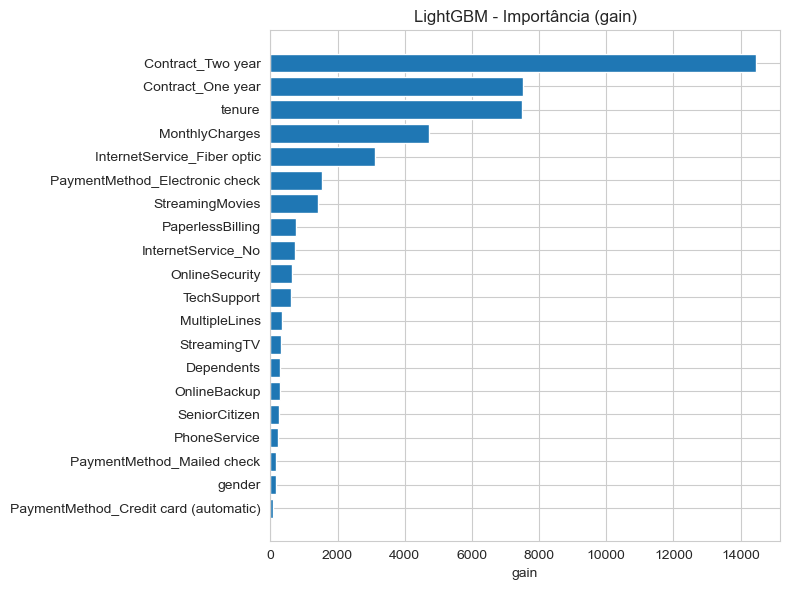

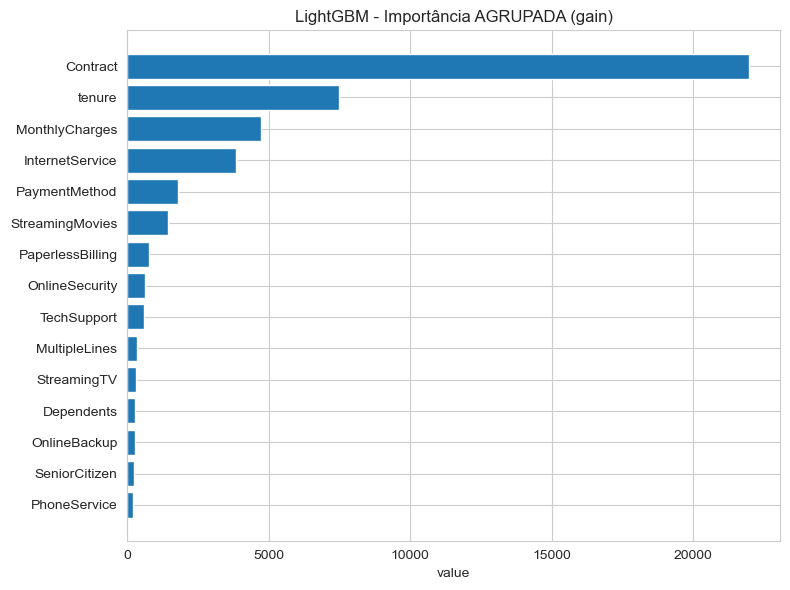

feature         value
0           Contract  21974.212258
1         Dependents    292.833550
2   DeviceProtection     14.491150
3    InternetService   3850.850205
4     MonthlyCharges   4717.019296
5      MultipleLines    346.108218
6       OnlineBackup    278.130722
7     OnlineSecurity    635.388637
8   PaperlessBilling    769.884130
9            Partner     45.985650
10     PaymentMethod   1814.236586
11      PhoneService    217.981278
12     SeniorCitizen    261.540139
13   StreamingMovies   1429.336064
14       StreamingTV    326.885152

In [64]:
# nomes das features
feat_names = X_train.columns

# import√¢ncia por "gain"
gain_importances = lgbm.booster_.feature_importance(importance_type="gain")
imp_gain_df = pd.DataFrame({"feature": feat_names, "gain": gain_importances})
imp_gain_df = imp_gain_df.sort_values("gain", ascending=False)

# plot detalhado
plot_top_importances(imp_gain_df, "gain", top_n=20, title="LightGBM - Import√¢ncia (gain)")

# vers√£o AGRUPADA por vari√°vel 'pai' (√∫til para dummies)
imp_gain_grouped = aggregate_grouped_importances(gain_importances, feat_names, agg="sum")
plot_top_importances(imp_gain_grouped, "value", top_n=15, title="LightGBM - Import√¢ncia AGRUPADA (gain)")
imp_gain_grouped.head(15)


5) Permutation Importance ‚Äî ‚Äútira a pe√ßa e re-testa‚Äù

Como funciona: mantemos o modelo treinado e permutamos (embaralhamos) os valores de uma feature no conjunto de teste; calculamos a queda na m√©trica (no seu caso usamos AUC). Se a AUC cair muito, a feature era essencial para previs√µes.

Analogia: em uma orquestra, voc√™ faz um teste: remove o violino e v√™ se a m√∫sica fica mais fraca. Se sim, o violino era cr√≠tico.

Por que √© valioso para o neg√≥cio:

√â agn√≥stico ao modelo: mede impacto direto na m√©trica de neg√≥cio (AUC), n√£o apenas uso interno do modelo.

D√° um indicativo mais ‚Äúoperacional‚Äù: se eu n√£o tivesse essa informa√ß√£o, quanto perder√≠amos na capacidade de identificar churn?

Detalhes t√©cnicos e boas pr√°ticas:

Fa√ßa n_repeats (ex.: 10) para estimar variabilidade; reporte m√©dia ¬± std.

Use a m√©trica que importa ao neg√≥cio (AUC, F1, recall) ‚Äî no seu projeto AUC √© bom para ranking, recall para captura.

Caveat: features correlacionadas podem mascarar import√¢ncia (se A e B s√£o muito correlacionadas, permutar A pode n√£o reduzir a performance porque B suplanta A). Solu√ß√£o: agrupar features correlacionadas ou usar conditional permutation.

Aplica√ß√£o no seu projeto:

Se MonthlyCharges ao ser permutado reduzir muito a AUC, ent√£o ele √© um forte candidato para a√ß√µes de pricing/plan design.

Apresente ao neg√≥cio a import√¢ncia m√©dia ¬± desvio e explique o risco de correla√ß√£o.

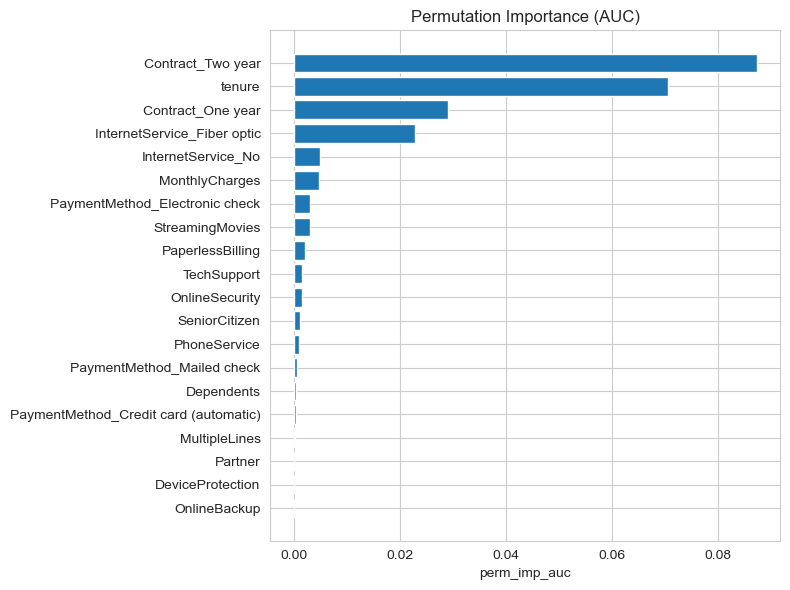

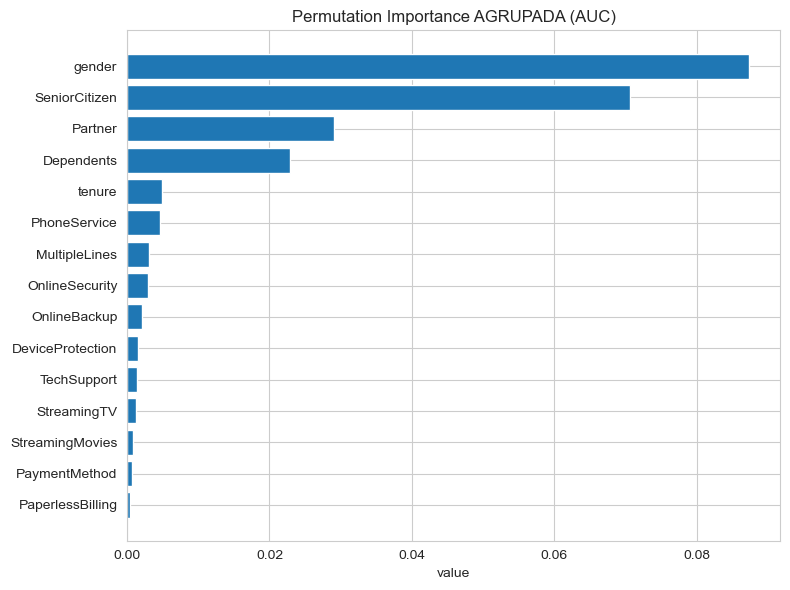

feature     value
0           Contract  0.000119
1         Dependents  0.022862
2   DeviceProtection  0.001548
3    InternetService  0.000422
4     MonthlyCharges  0.000307
5      MultipleLines  0.003007
6       OnlineBackup  0.002141
7     OnlineSecurity  0.002959
8   PaperlessBilling  0.000470
9            Partner  0.029104
10     PaymentMethod  0.000749
11      PhoneService  0.004665
12     SeniorCitizen  0.070613
13   StreamingMovies  0.000827
14       StreamingTV  0.001181

In [65]:
perm = permutation_importance(
    lgbm, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)
imp_perm_df = pd.DataFrame({
    "feature": feat_names,
    "perm_imp_auc": perm.importances_mean,
    "perm_imp_std": perm.importances_std
}).sort_values("perm_imp_auc", ascending=False)

plot_top_importances(imp_perm_df, "perm_imp_auc", top_n=20, title="Permutation Importance (AUC)")

# AGRUPADA por vari√°vel 'pai'
imp_perm_grouped = aggregate_grouped_importances(imp_perm_df["perm_imp_auc"].values, feat_names, agg="sum")
plot_top_importances(imp_perm_grouped, "value", top_n=15, title="Permutation Importance AGRUPADA (AUC)")
imp_perm_grouped.head(15)


6) SHAP ‚Äî atribui√ß√£o justa e interpret√°vel (global + local)

O que √© (conceito): Shapley values v√™m da teoria dos jogos: imagine que cada feature √© um jogador contribuindo para a recompensa (previs√£o). O Shapley de uma feature √© a m√©dia do ganho marginal de adicionar aquela feature a todos os subconjuntos poss√≠veis de features ‚Äî √© uma forma ‚Äújusta‚Äù de dividir o m√©rito.

Analogia:

Pense em um time que ganha um jogo. O Shapley distribui o cr√©dito da vit√≥ria entre cada jogador considerando todas as combina√ß√µes poss√≠veis de jogadores em campo ‚Äî sem favorecer quem tem mais minutos necessariamente.

Para o seu cliente X: SHAP responde ‚Äúquanto cada caracter√≠stica desse cliente empurrou a predi√ß√£o para cima (mais churn) ou para baixo (menos churn)‚Äù.

Por que usar SHAP:

D√° dire√ß√£o (pos/neg) e magnitude (quanto contribui).

Funciona em n√≠vel local (explica um cliente espec√≠fico) e global (agregando valores absolutos).

TreeExplainer (para LightGBM) √© muito eficiente.

Interpreta√ß√£o pr√°tica (aplicada ao projeto):

Resumo global (beeswarm): mostra as features mais influentes e como os valores (alto/baixo) empurram a predi√ß√£o. Ex.: um ponto vermelho √† direita para MonthlyCharges indica cliente com MonthlyCharges alto e SHAP positivo ‚Äî aumenta churn.

Local (force plot): pegue um cliente com alta probabilidade de churn: SHAP mostra, por exemplo:

Expected value (baseline): 0.18 (prob m√©dia do dataset)

MonthlyCharges: +0.22

Contract=Month-to-month: +0.12

Tenure: -0.07
‚Üí previs√£o final ‚âà 0.45 (hipot√©tico). Isso mostra individualmente os drivers.

Direcionalidade agregada:

Voc√™ pode correlacionar o valor da feature com seu SHAP para obter um ‚Äúsinal‚Äù (ex.: se correla√ß√£o > 0 ‚Üí valores maiores aumentam risco).

No seu notebook eu j√° calculei direction_corr para ajudar o time de neg√≥cio a traduzir ‚Äúmais/menos da feature significa mais/menos churn‚Äù.

Limita√ß√µes / cuidados:

SHAP explica o modelo, n√£o a causalidade. Se Contract aparece como protetor (reduz churn), pode significar que clientes com contrato longo j√° s√£o ‚Äúbons clientes‚Äù por outros motivos.

Intera√ß√µes: SHAP pode mostrar intera√ß√£o via interaction values, mas isso √© mais avan√ßado e mais caro computacionalmente.

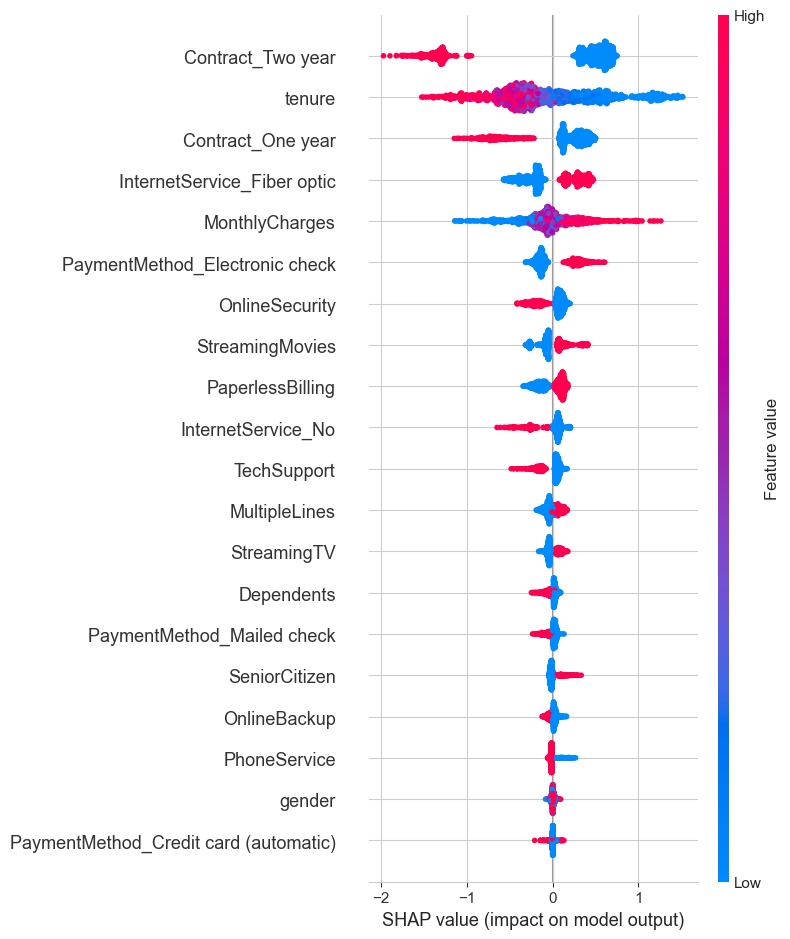

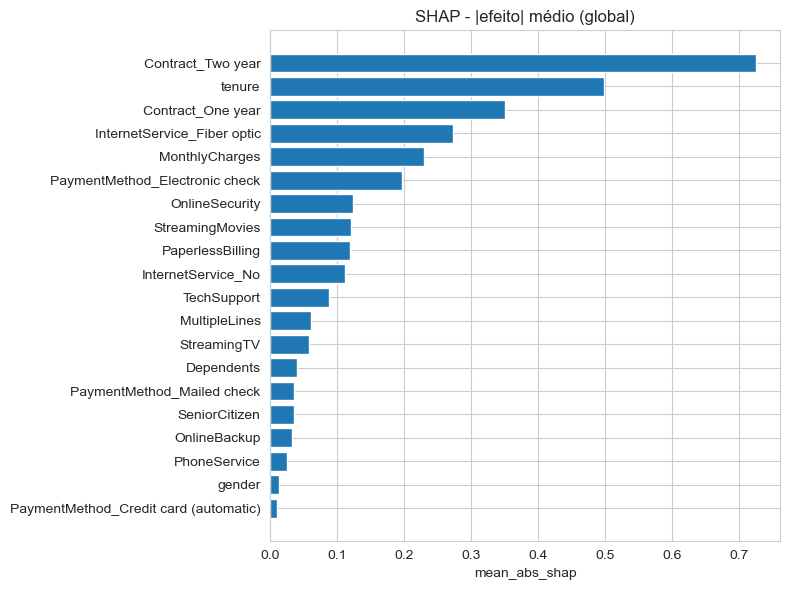

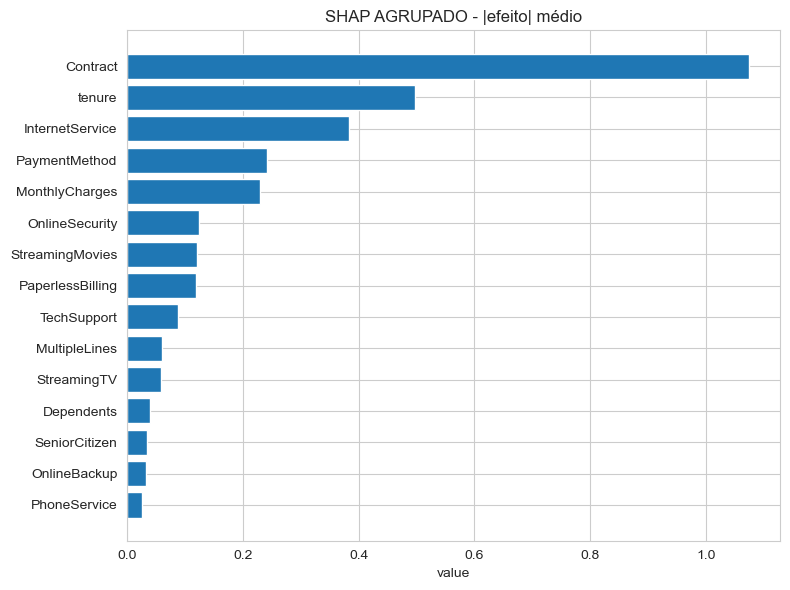

feature  mean_abs_shap  direction_corr  \
0                       Contract_Two year       0.724372       -0.987947   
1                                  tenure       0.497586       -0.862675   
2                       Contract_One year       0.350179       -0.942685   
3             InternetService_Fiber optic       0.272144        0.923495   
4                          MonthlyCharges       0.229929        0.774371   
5          PaymentMethod_Electronic check       0.196693        0.966441   
6                          OnlineSecurity       0.123907       -0.937402   
7                         StreamingMovies       0.121011        0.811060   
8                        PaperlessBilling       0.119186        0.927893   
9                      InternetService_No       0.111858       -0.927692   
10                            TechSupport       0.087674       -0.938758   
11                          MultipleLines       0.060462        0.796864   
12                            StreamingTV       0.058288        0.920769   
13                             Dependents       0.039370       -0.834655   
14             PaymentMethod_Mailed check       0.035275       -0.843024   
15                          SeniorCitizen       0.034952        0.894678   
16                           OnlineBackup       0.032002       -0.800661   
17                           PhoneService       0.025272       -0.893882   
18                                 gender       0.012525        0.124737   
19  PaymentMethod_Credit card (automatic)       0.010431       -0.083750   

      sinal  
0   ‚Üì risco  
1   ‚Üì risco  
2   ‚Üì risco  
3   ‚Üë risco  
4   ‚Üë risco  
5   ‚Üë risco  
6   ‚Üì risco  
7   ‚Üë risco  
8   ‚Üë risco  
9   ‚Üì risco  
10  ‚Üì risco  
11  ‚Üë risco  
12  ‚Üë risco  
13  ‚Üì risco  
14  ‚Üì risco  
15  ‚Üë risco  
16  ‚Üì risco  
17  ‚Üì risco  
18  ‚Üë risco  
19  ‚Üì risco

In [66]:
# Amostra (para velocidade em notebooks)
X_sample = X_test.copy()
if X_sample.shape[0] > 2000:
    X_sample = X_sample.sample(2000, random_state=42)

# Explainer para LightGBM
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_sample)

# Para bin√°rio, shap_values pode ser [class0, class1]; usamos a classe 1 (churn)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

# 5.1) Beeswarm (global)
shap.summary_plot(sv, X_sample, show=True)  # interativo no notebook

# 5.2) Import√¢ncia pelo |SHAP| m√©dio
mean_abs = np.abs(sv).mean(axis=0)
imp_shap_df = pd.DataFrame({"feature": X_sample.columns, "mean_abs_shap": mean_abs})\
                 .sort_values("mean_abs_shap", ascending=False)

plot_top_importances(imp_shap_df, "mean_abs_shap", top_n=20, title="SHAP - |efeito| m√©dio (global)")

# 5.3) Direcionalidade (correla√ß√£o simples entre valor da feature e seu SHAP)
def shap_direction(sv, X):
    dirs = []
    for i, f in enumerate(X.columns):
        xcol = pd.to_numeric(X[f], errors="coerce")  # funciona para binaries/num√©ricos
        corr = np.corrcoef(xcol.fillna(xcol.mean()), sv[:, i])[0, 1]
        dirs.append(corr)
    return pd.DataFrame({"feature": X.columns, "direction_corr": dirs})

dir_df = shap_direction(sv, X_sample)
# Sinal: positivo -> valores maiores da feature aumentam risco; negativo -> reduzem risco
shap_exec_df = (imp_shap_df.merge(dir_df, on="feature")
                            .assign(sinal=lambda d: np.where(d["direction_corr"]>=0, "‚Üë risco", "‚Üì risco")))

# AGRUPADO por 'pai' para dummies
shap_group = aggregate_grouped_importances(imp_shap_df["mean_abs_shap"].values, imp_shap_df["feature"].values, agg="sum")
plot_top_importances(shap_group, "value", top_n=15, title="SHAP AGRUPADO - |efeito| m√©dio")

shap_exec_df.head(20)


Partial Dependence (PDP) ‚Äî ‚Äúse eu mexer s√≥ nesse bot√£o, qual a m√©dia do efeito?‚Äù

O que mede: efeito m√©dio no score do modelo ao fixar a feature em v√°rios valores, marginalizando sobre as outras vari√°veis.

Analogia: imagine ajustar o n√≠vel do sal numa panela para ver, em m√©dia, o quanto a sopa fica mais salgada para a maioria das pessoas ‚Äî sem olhar nas prefer√™ncias individuais.

Uso pr√°tico:

Fa√ßa PDP para as top 4‚Äì6 features (p.ex. MonthlyCharges, Tenure, Contract, TechSupport).

Interprete curvas: monotonicidade (‚Üë sempre aumenta churn?), limites onde efeito muda (thresholds) ‚Äî isso ajuda a definir faixas de a√ß√£o (ex.: clientes com MonthlyCharges > R$X t√™m risco muito maior).

Caveats:

Se feature correlacionada com outras, PDP pode representar uma situa√ß√£o ‚Äúfora da distribui√ß√£o‚Äù (ex.: fixar Tenure alto com Contract=Month-to-month pode ser raro).

Use ICE plots junto se quiser ver heterogeneidade entre clientes (nem todo mundo reage igual).

<Figure size 600x400 with 0 Axes>

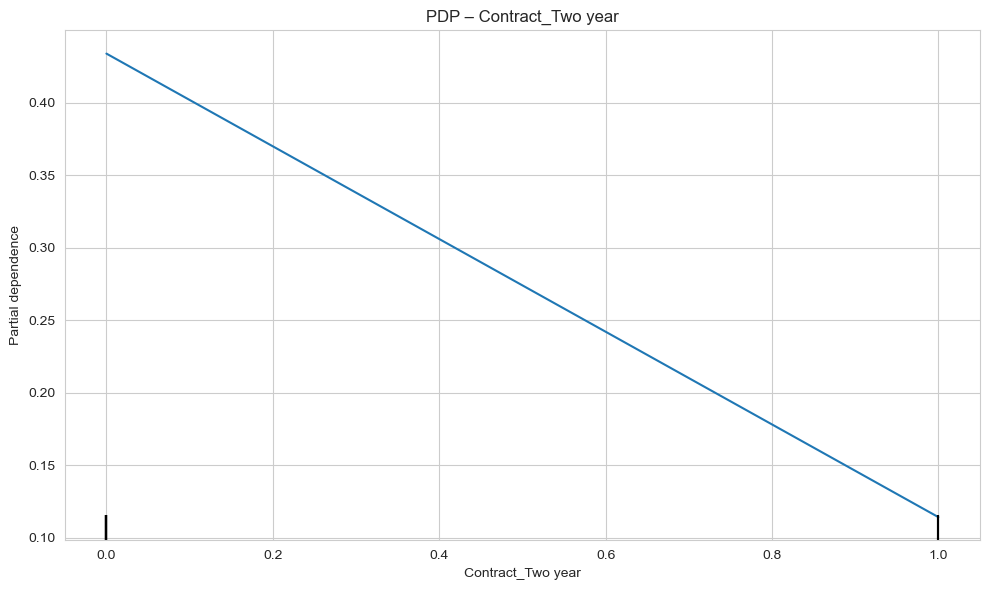

<Figure size 600x400 with 0 Axes>

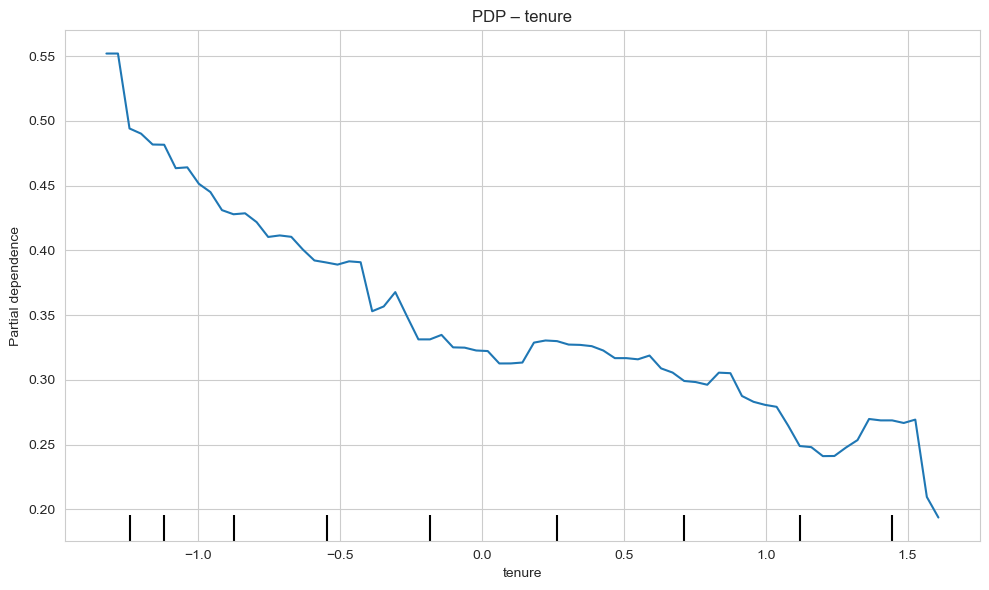

<Figure size 600x400 with 0 Axes>

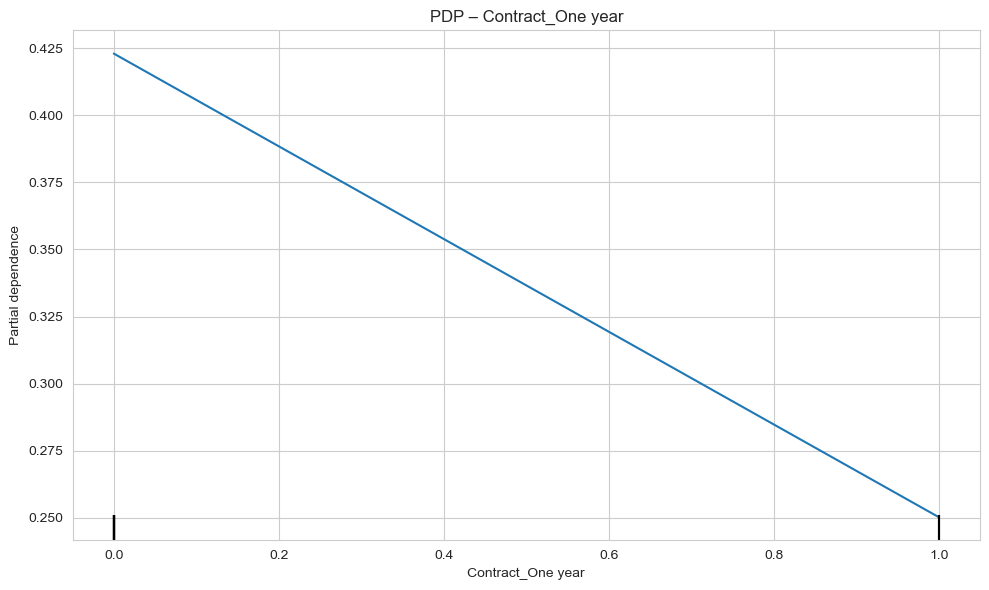

<Figure size 600x400 with 0 Axes>

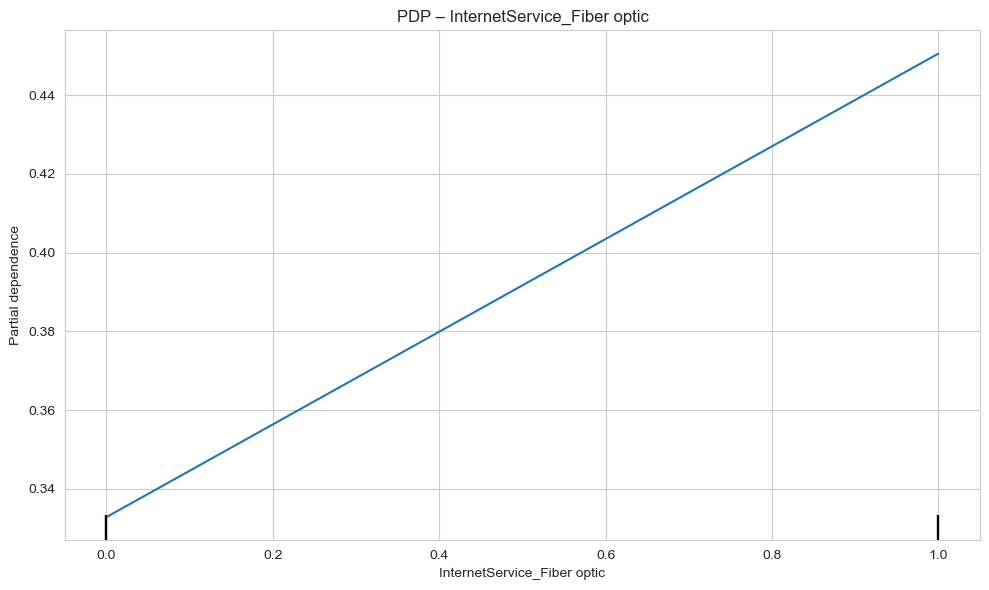

<Figure size 600x400 with 0 Axes>

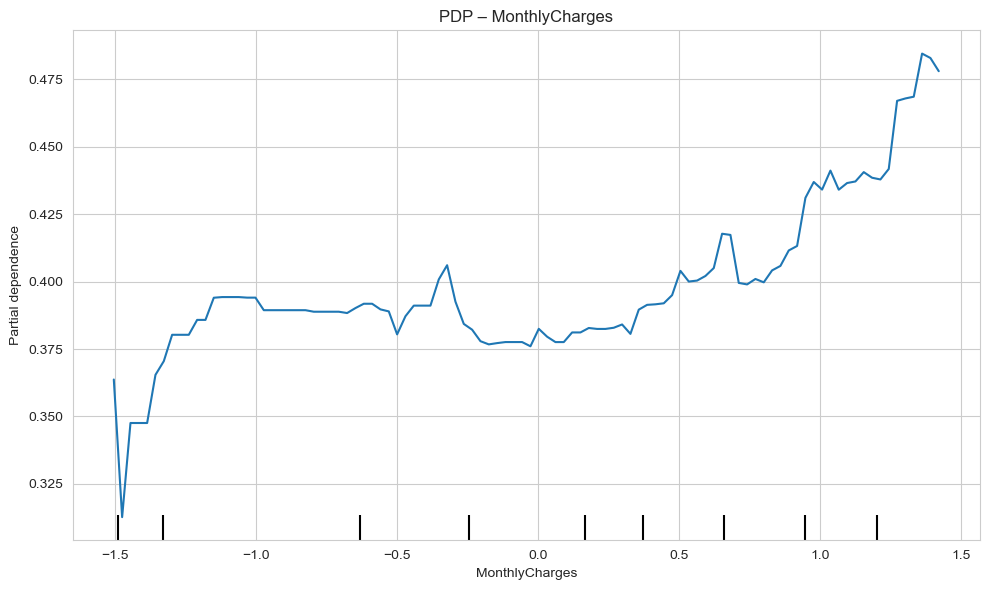

<Figure size 600x400 with 0 Axes>

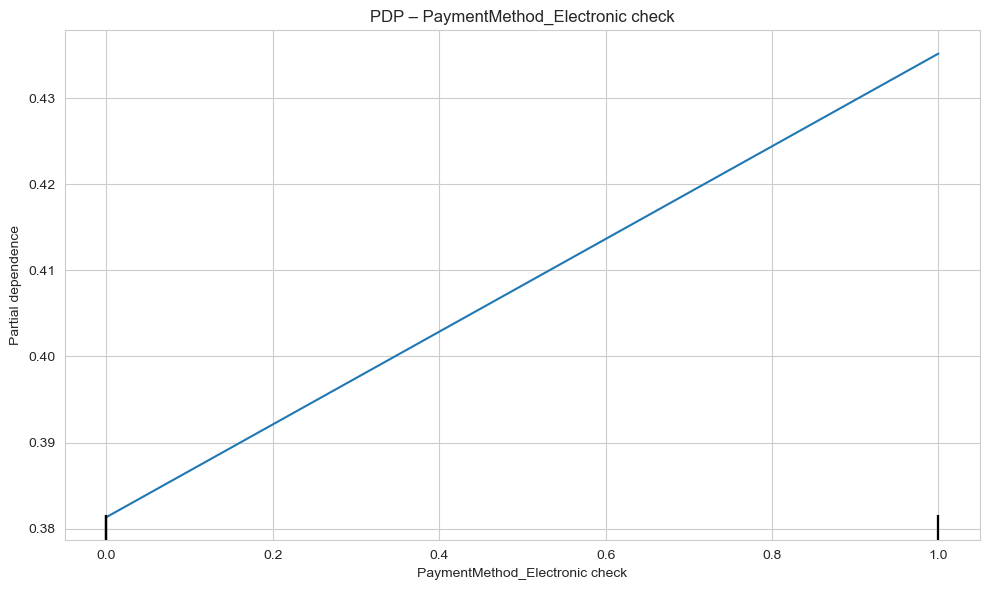

In [67]:
# seleciona top 6 pela m√©trica SHAP global
top6 = imp_shap_df["feature"].head(6).tolist()

for f in top6:
    fig = plt.figure(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(lgbm, X_test, [f], kind="average")
    plt.title(f"PDP ‚Äì {f}")
    plt.tight_layout()
    plt.show()


8) Consolida√ß√£o: combinar evid√™ncias (gain + permutation + SHAP)

Por que combinar?

Cada m√©todo tem pontos fortes/fracos. Quando concordam, confian√ßa sobe.

Estrat√©gia: rankear features por cada m√©todo, normalizar ranks e fazer m√©dia (ou ponderar por confian√ßa/neg√≥cio).

Analogia: tr√™s inspetores independentes olham o casco do navio; se os tr√™s apontam o mesmo ponto, d√° pra consertar com confian√ßa.

No projeto:

Gere tabela com colunas: rank_gain, rank_perm, rank_shap, rank_media, direction (‚Üë/‚Üì), observa√ß√µes.

Agrupe dummies (ex.: PaymentMethod_* ‚Üí PaymentMethod) somando import√¢ncias para entregar ao neg√≥cio no n√≠vel ‚Äúm√£e‚Äù.

Como priorizar a√ß√µes:

Use matriz Impacto (import√¢ncia m√©dia) x Esfor√ßo (custo/complexidade).

Ex.: Contract (alto impacto, baixo esfor√ßo se voc√™ j√° tem planos diferenciados) ‚Üí alta prioridade; Billing Address (baixo impacto, alto esfor√ßo) ‚Üí baixa prioridade.

In [68]:
# normaliza e combina
r_gain = imp_gain_df.assign(rank_gain=lambda d: d["gain"].rank(ascending=False))
r_perm = imp_perm_df.assign(rank_perm=lambda d: d["perm_imp_auc"].rank(ascending=False))[["feature","rank_perm"]]
r_shap = imp_shap_df.assign(rank_shap=lambda d: d["mean_abs_shap"].rank(ascending=False))[["feature","rank_shap"]]

rank_df = (r_gain[["feature","rank_gain"]]
           .merge(r_perm, on="feature", how="outer")
           .merge(r_shap, on="feature", how="outer")
           .merge(shap_exec_df[["feature","direction_corr","sinal"]], on="feature", how="left"))

rank_df["rank_media"] = rank_df[["rank_gain","rank_perm","rank_shap"]].mean(axis=1)
rank_df = rank_df.sort_values("rank_media").reset_index(drop=True)

# Mostre o top 15 consolidado
rank_df.head(15)


feature  rank_gain  rank_perm  rank_shap  \
0                Contract_Two year        1.0        1.0        1.0   
1                           tenure        3.0        2.0        2.0   
2                Contract_One year        2.0        3.0        3.0   
3      InternetService_Fiber optic        5.0        4.0        4.0   
4                   MonthlyCharges        4.0        6.0        5.0   
5   PaymentMethod_Electronic check        6.0        7.0        6.0   
6                  StreamingMovies        7.0        8.0        8.0   
7               InternetService_No        9.0        5.0       10.0   
8                 PaperlessBilling        8.0        9.0        9.0   
9                   OnlineSecurity       10.0       11.0        7.0   
10                     TechSupport       11.0       10.0       11.0   
11                   MultipleLines       12.0       17.0       12.0   
12                      Dependents       14.0       15.0       14.0   
13                   SeniorCitizen       16.0       12.0       16.0   
14                     StreamingTV       13.0       21.0       13.0   

    direction_corr    sinal  rank_media  
0        -0.987947  ‚Üì risco    1.000000  
1        -0.862675  ‚Üì risco    2.333333  
2        -0.942685  ‚Üì risco    2.666667  
3         0.923495  ‚Üë risco    4.333333  
4         0.774371  ‚Üë risco    5.000000  
5         0.966441  ‚Üë risco    6.333333  
6         0.811060  ‚Üë risco    7.666667  
7        -0.927692  ‚Üì risco    8.000000  
8         0.927893  ‚Üë risco    8.666667  
9        -0.937402  ‚Üì risco    9.333333  
10       -0.938758  ‚Üì risco   10.666667  
11        0.796864  ‚Üë risco   13.666667  
12       -0.834655  ‚Üì risco   14.333333  
13        0.894678  ‚Üë risco   14.666667  
14        0.920769  ‚Üë risco   15.666667

9) Transformando import√¢ncia em a√ß√£o (playbook pr√°tico)

Para cada top-feature entregue, proponha:

O insight (o que a feature diz: ex.: ‚Äúclientes em Month-to-month t√™m risco maior‚Äù).

A recomenda√ß√£o (ex.: testar incentivo de migra√ß√£o para 12 meses com desconto).

Experimento (ex.: A/B test: oferta vs. controle em clientes com tenure < 6 meses e contrato mensal).

M√©trica de sucesso (ex.: redu√ß√£o relativa de churn no coorte em 3 meses; lift na reten√ß√£o; CAC vs. LTV).

Crit√©rios de parada (ex.: se custo de incentivo > 0.5 * LTV esperado, reavaliar).

Exemplos aplicados:

Contract_Month-to-month (‚Üë risco): A√ß√£o: campanha de reten√ß√£o com 20% de desconto no 2¬∫ m√™s para clientes com tenure < 3 meses. KPI: redu√ß√£o de churn no coorte alvo em 30 dias.

MonthlyCharges (‚Üë risco): A√ß√£o: oferta de bundle ou downgrade assistido para clientes com charges na faixa cr√≠tica; introduzir pre√ßos escalonados.

TechSupport / OnlineSecurity (‚Üì risco): A√ß√£o: upsell proativo para clientes com risco alto; monitorar custo de aquisi√ß√£o do upsell vs. churn evitado.

10) Visuals que voc√™ deve incluir no relat√≥rio executivo (com roteiro)

Slide 1: Objetivo, dataset (n¬∫ de clientes, per√≠odo), defini√ß√£o de churn, m√©tricas atingidas (AUC, F1).

Slide 2: Top features ‚Äî gr√°fico agrupado (gain vs permutation vs SHAP) com cor para dire√ß√£o (‚Üë/‚Üì).

Slide 3: Beeswarm SHAP ‚Äî interpreta√ß√£o r√°pida (ex.: ‚Äúvermelho √† direita = altos valores que aumentam churn‚Äù).

Slide 4: PDPs para top 3 (curvas + interpreta√ß√£o: thresholds acion√°veis).

Slide 5: Exemplo local ‚Äî 2 clientes (um churn, um n√£o) com force plots e propostas de a√ß√£o.

Slide 6: Tabela consolidada (Top 10) com a√ß√µes recomendadas, esfor√ßo estimado e KPIs.

Slide 7: Riscos/limita√ß√µes & pr√≥ximos passos (A/B test, causal, monitoramento).

Anota√ß√µes de apresenta√ß√£o: em cada gr√°fico inclua uma frase resumindo a interpreta√ß√£o para o time de neg√≥cios (evita mal-entendidos).

11) Robustez, checagens e armadilhas (para entregar ‚Äú√† prova de auditoria‚Äù)

Valida√ß√£o cruzada / estabilidade: calcule import√¢ncias em diferentes folds; reporte variabilidade ‚Äî se uma feature varia muito de fold para fold, cuidado.

Colinearidade: gere matriz de correla√ß√£o / VIF; se VIF alto, considere agrupar ou usar PCA (mas PCA reduz interpretabilidade).

Leakage: verifique se alguma feature usa informa√ß√£o futura (ex.: cancel_date) ‚Äî isso inflaria import√¢ncias.

Tamanho de amostra por bucket: PDPs e SHAPs para categorias raras podem ser inst√°veis ‚Äî mostre contagem/coverage.

Teste de permuta condicional quando features correlacionadas (evita subestimar import√¢ncia).

Drift/monitoramento: importe baseline SHAP e compare com produ√ß√£o ‚Äî se padr√µes mudarem, re-treine.

Analogia: antes de consertar o navio, precisamos garantir que as leituras dos sensores n√£o estejam com defeito ‚Äî caso contr√°rio, vamos consertar o lugar errado.

12) Reprodutibilidade e trilha de auditoria (checklist)

Sempre fixe random_state e registre seeds.

Salve: vers√£o do dataset (hash ou id), vers√£o do c√≥digo (commit git), ambiente (requirements.txt / conda env), e o modelo (pickle / joblib / MLflow artifact).

Log: hiperpar√¢metros, m√©tricas por fold, tempo de treino, tamanho amostral.

Documente decis√µes (por que features foram removidas/engenheiradas).

Se poss√≠vel, use MLflow / DVC para rastrear modelos e datasets.

13) Pr√≥ximos passos anal√≠ticos (op√ß√µes para aprofundar)

A/B tests com as a√ß√µes propostas (retention offers, upsell).

Uplift modelling (modelos que estimam efeito causal da interven√ß√£o por cliente).

An√°lise causal (matching / causal forests) para validar que a a√ß√£o causa a redu√ß√£o de churn.

Pipeline de produ√ß√£o + monitoramento de performance e SHAP drift.

14) Recapitulando com um exemplo narrativo (aplicado)

Imagine que nossa tabela final (consolidada) trouxe Contract, MonthlyCharges, Tenure, TechSupport como top 4.

Hist√≥ria curta para o board:

‚ÄúNosso modelo (AUC 0.84) indica que o maior driver √© tipo de contrato: clientes mensalmente renov√°veis (Month-to-month) t√™m risco significativamente maior. SHAP nos diz que, para um cliente t√≠pico com alta cobran√ßa mensal e pouco tempo de contrato, essas duas features juntas respondem por ~+0.30 na probabilidade estimada de churn ‚Äî ou seja, quase dobram a probabilidade base. Recomenda-se um piloto de oferta de 12 meses com incentivo para clientes com tenure < 6 meses e score de risco na top decile. Mediremos churn no coorte por 90 dias e compararemos custo do incentivo vs. churn evitado (ROI).‚Äù